# Data Wrangling & EDA | US Inflation

# Table of Contents<a id='#home'></a>
* [2.0 Data Wrangling](#data_w)
  * [2.1 Contents](#contents)
  * [2.2 Imports & Others](#imports)
  * [2.3 Pulling in Data](#data_pull)
  * [2.4 Initial Data Cleaning](#data_clean)
  * [2.5 Q on Q Comparison](#q_q)
    * [2.5.2 Cleaning the Q on Q Dataframe for outliers](#q_q_clean)
    * [2.5.3 Q on Q Pearson](#q_q_pearson)
  * [2.6 Monthly Comparison](#m_m)
    * [2.6.2 Cleaning the Monthly Dataframe for outliers](#m_m_clean)
    * [2.6.3 Monthly Pearson](#m_m_pearson)
  * [2.7 Quarterly Changes | Variables ( past ) & Inflation ( forwards )](#q_pf)
    * [2.7.2 Cleaning the Dataframe for outliers](#q_pf_clean)
    * [2.7.3 Quarterly Changes | Variables ( past ) & Inflation ( forwards ) | Pearson](#q_pf_pearson)
  * [2.8 Q on Q Comparison w/ Rolling Averages on Daily, Wkly & Mnthly Variables ( w/ Inflation Scraping & no variable scraping )](#rolling)
    * [2.8.2 Cleaning Q on Q Comparison w/ Rolling Averages](#rolling_clean)
    * [2.8.3 Q on Q Comparison w/ Rolling Averages Pearson](#rolling_pearson)

  * [2.9 Project Initial Summary](#p_initial_summary)
  * [2.10 Winsorization on Variables](#winsor_vars)

  * [2.11 Project Final Summary](#p_final_summary)


## **2.1 Contents**<a id='contents'></a>

The purpose of this Data Science project is to develop a model to explain & understand the phenomenon of the Consumer Price Index for All Urban Consumers in the United States ( “Inflation” ). Inflation is an important component of developing investment strategies for portfolios across the world. The view on inflation becoming positive or negative is not agreed upon nor are the variables which influence it.

In this project, I have shortlisted **nineteen** ( **19** ) **variables** to determine their influence on inflation.

The fundamental **questions to resolve in this notebook** before we move on are:
   * Are the identified variables correlated with inflation?
   * Is there enough data to build out a model?


## 2.2 Imports & Others <a id='imports'></a>

In [3920]:
#Import the necessary tools required in the correct lines below
import quandl
from fredapi import Fred
from getpass import getpass
import investpy


import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import seaborn as sns
import os
import lxml
import datetime
import requests
import json
import collections
import seaborn as sns
from scipy import stats
from scipy.stats.mstats import winsorize

def win(x):
    if x < 0:
        return back_d
    else:
        return back_u

back_d = 'we will keep the old un-Winsorized.'
back_u = 'we will use the new Winsorized.'

import numpy as np
%reload_ext watermark
%watermark -d -t -v -p pandas

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.10.0

pandas: 1.2.4



In [3921]:
# These will be needed later

now = datetime.datetime.now()
year = now.strftime("%Y")
month = now.strftime("%m")
day = now.strftime("%d")
today_y_m_d_dash = now.strftime("%Y-%m-%d")
today_d_m_y_dash = now.strftime("%d/%m/%Y")


In [3922]:
# Importing Quandl API requires a password
# If you don't have one, please see the link below
# https://docs.quandl.com/docs#section-authentication

my_quandl_API = getpass()

········


In [3923]:
quandl.ApiConfig.api_key = my_quandl_API

In [3924]:
# Importing FRED API requires a password ( FRED stands for Federal Reserve Economic Data )
# If you don't have one, please see the link below
# https://fred.stlouisfed.org/docs/api/fred/

my_FRED_API = getpass()

········


In [3925]:
fred = Fred(api_key=my_FRED_API)

In [3926]:
# Here I am structuring a color scale for heatmaps which will be used later

cdict = {'green':  ((0.0, 0.0, 0.0),   # no red at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.8, 0.8)),  # set to 0.8 so its not too bright at 1

        'red': ((0.0, 0.8, 0.8),   # set to 0.8 so its not too bright at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0)),  # no green at 1

        'blue':  ((0.0, 0.0, 0.0),   # no blue at 0
                  (0.5, 1.0, 1.0),   # all channels set to 1.0 at 0.5 to create white
                  (1.0, 0.0, 0.0))   # no blue at 1
       }

# Create the colormap using the dictionary
GnRd = colors.LinearSegmentedColormap('GnRd', cdict)


## 2.3 Pulling in Data<a id='data_pull'></a>

Please note, I may intend to build another USD Index based on the United States actual engagement in the world.
In other words, the USD Index used ( as of now ), is not based on the United States' trade with the world
I listed below FX pairs to possibly build out a "version" of The [USD Index Trade Weighted](https://en.wikipedia.org/wiki/Trade-weighted_US_dollar_index) but given time constraints I will work with the US Dollar Index ( not trade weighted ) for now.

While the Trade Weighted Index can be accessed by an API ( FRED ), it only goes back to 2006 
so something similar would need be created if time permits. 
My major hurdle at this time is accessing trade data & time.

   * Eurozone, Canada, Japan, Mexico, China, United Kingdom, Taiwan, South Korea, Singapore, Hong Kong, Malaysia, Brazil, Switzerland, Thailand, Philippines, Australia, Indonesia, India, Israel, Saudi Arabia, Russia, Sweden, Argentina, Venezuela, Chile & Colombia


In [3927]:
# Daily Data
usd_index = quandl.get('CHRIS/ICE_DX1')
wti = quandl.get('CHRIS/CME_CL1')
copper = investpy.get_commodity_historical_data(commodity='Copper', country='United States', from_date='01/01/1978', to_date=today_d_m_y_dash)
soybeans = investpy.get_commodity_historical_data(commodity='US Soybeans', from_date='01/01/1978', to_date=today_d_m_y_dash)
natgas = investpy.get_commodity_historical_data(commodity='Natural Gas', from_date='01/01/1978', to_date=today_d_m_y_dash)
heatoil = investpy.get_commodity_historical_data(commodity='Heating Oil', from_date='01/01/1978', to_date=today_d_m_y_dash)
corn = investpy.get_commodity_historical_data(commodity='US Corn', from_date='01/01/1978', to_date=today_d_m_y_dash)
wheat = investpy.get_commodity_historical_data(commodity='US Wheat', from_date='01/01/1978', to_date=today_d_m_y_dash)
cattle = investpy.get_commodity_historical_data(commodity='Live Cattle', from_date='01/01/1978', to_date=today_d_m_y_dash)
sugar = investpy.get_commodity_historical_data(commodity='US Sugar #11', from_date='01/01/1978', to_date=today_d_m_y_dash)
lumber = investpy.get_commodity_historical_data(commodity='Lumber', from_date='01/01/1978', to_date=today_d_m_y_dash)
leanhogs = investpy.get_commodity_historical_data(commodity='Lean Hogs', from_date='01/01/1978', to_date=today_d_m_y_dash)

# Weekly Data
int_job_claims = quandl.get('FRED/ICSA')

# Monthly Data
cpi = quandl.get('RATEINF/INFLATION_USA')
wages_cpi = fred.get_series('CWSR0000SA0')
cap_util = fred.get_series('TCU')
unrate = quandl.get('FRED/UNRATE')
comppmi = quandl.get('ISM/MAN_PMI')

# Quarterly Data
m2_velo = fred.get_series('M2V')
gdp = fred.get_series('GDP')


In [3928]:
# As the purpose of this section is to accumulate all the data into one location to cross reference future works integrity,
# I put all here to referance ( if required ) later.

main_df = pd.concat([cpi,wages_cpi,wti['Last'],heatoil['Close'],copper['Close'],sugar['Close'],natgas['Close'],
                     cattle['Close'],leanhogs['Close'],soybeans['Close'],lumber['Close'],
                     cap_util,corn['Close'],m2_velo,gdp,wheat['Close'],comppmi['PMI'],usd_index['Settle'],
                     unrate,int_job_claims],
                    axis = 1, ignore_index=False)

main_df = main_df.fillna(method='ffill')
main_df.columns = ['Inflation','Wages CPI','WTI','Heating Oil','Copper','Sugar','Natural Gas','Cattle',
                   'Lean Hogs','Soybeans','Lumber','Capacity Utilization','Corn','M2 Velocity','GDP',
                   'Wheat','PMI','USD Index','Unemployment Rate','Initial Jobless Claims'
                  ]
main_df['Inflation'].index
main_df.index.names = ["Date"]

main_df = main_df[main_df.index.dayofweek < 5]

main_df.sort_values(by="Date", ascending=False)
main_df.tail(3)

Inflation  Wages CPI    WTI  Heating Oil  Copper  Sugar  \
Date                                                                  
2021-09-01      5.365    266.945  73.44       2.1289   4.278  19.67   
2021-09-02      5.365    266.945  73.44       2.1677   4.304  19.90   
2021-09-03      5.365    266.945  73.44       2.1535   4.337  19.59   

            Natural Gas   Cattle  Lean Hogs  Soybeans  Lumber  \
Date                                                            
2021-09-01        4.615  127.575      90.15   1277.75   477.5   
2021-09-02        4.641  126.050      89.85   1282.75   516.9   
2021-09-03        4.697  124.675      89.60   1290.50   555.0   

            Capacity Utilization    Corn  M2 Velocity        GDP   Wheat  \
Date                                                                       
2021-09-01               76.1152  515.50         1.12  22731.369  713.50   
2021-09-02               76.1152  516.25         1.12  22731.369  717.75   
2021-09-03               76.1152  522.90         1.12  22731.369  726.60   

             PMI  USD Index  Unemployment Rate  Initial Jobless Claims  
Date                                                                    
2021-09-01  59.9     92.041                5.4                340000.0  
2021-09-02  59.9     92.041                5.4                340000.0  
2021-09-03  59.9     92.041                5.4                340000.0

## 2.4 Initial Data Cleaning<a id='data_clean'></a>

Here we will ensure we have homogeneous data to compare with each other.

In [3929]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11583 entries, 1914-03-31 to 2021-09-03
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               11583 non-null  float64
 1   Wages CPI               11297 non-null  float64
 2   WTI                     9905 non-null   float64
 3   Heating Oil             10732 non-null  float64
 4   Copper                  8548 non-null   float64
 5   Sugar                   10732 non-null  float64
 6   Natural Gas             8115 non-null   float64
 7   Cattle                  10727 non-null  float64
 8   Lean Hogs               10732 non-null  float64
 9   Soybeans                8181 non-null   float64
 10  Lumber                  10732 non-null  float64
 11  Capacity Utilization    10953 non-null  float64
 12  Corn                    10732 non-null  float64
 13  M2 Velocity             11091 non-null  float64
 14  GDP                  

`Inflation` has by and large the most data while `Natural Gas` has the least. Let's move forward with using the `Natural Gas` amount limitations.

I will move forward with only the data where all information is present with no null values

In [3930]:
main_df = main_df.loc['1990-04-04':today_y_m_d_dash]

# The reason 1990 was chosen is becuase Natural Gas only goes back that far; take a look if you wish 

In [3931]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8115 entries, 1990-04-04 to 2021-09-03
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               8115 non-null   float64
 1   Wages CPI               8115 non-null   float64
 2   WTI                     8115 non-null   float64
 3   Heating Oil             8115 non-null   float64
 4   Copper                  8115 non-null   float64
 5   Sugar                   8115 non-null   float64
 6   Natural Gas             8115 non-null   float64
 7   Cattle                  8115 non-null   float64
 8   Lean Hogs               8115 non-null   float64
 9   Soybeans                8115 non-null   float64
 10  Lumber                  8115 non-null   float64
 11  Capacity Utilization    8115 non-null   float64
 12  Corn                    8115 non-null   float64
 13  M2 Velocity             8115 non-null   float64
 14  GDP                   

In [3932]:
cd

C:\Users\rands


In [3933]:
# Here I am saving the non-adjusted ( raw ) data to investigate whether the adjustments further along yield correctly

main_df = main_df.sort_values(by="Date", ascending=False)

main_df_csv = pd.DataFrame(main_df)
main_df_csv.to_excel('./_Inflation_Capstone/data/main_df_csv_w_commodities.xlsx')
print('Finished; keep going!')

Finished; keep going!


**Here we will create a summary of the variables.**

In [3934]:
var_sum = main_df.T
var_sum = var_sum.index
var_sum = pd.DataFrame(var_sum)

In [3935]:
reported = [ 'Monthly','Monthly','Daily','Daily','Daily','Daily','Daily','Daily','Daily','Daily',
           'Daily','Monthly','Daily','Quarterly','Quarterly','Daily','Monthly','Daily','Monthly','Weekly']
api = [ 'Quandl','FRED','Quandl','Investpy','Investpy','Investpy','Investpy','Investpy',
              'Investpy','Investpy','Investpy','FRED','Investpy','FRED','FRED',
              'Investpy','Quandl','Quandl','Quandl','Quandl']

api_source = [ 'U.S. Bureau of Labor Statistics',
            'U.S. Bureau of Labor Statistics',
            'CME',
            'Investing.com',
            'Investing.com',
            'Investing.com',
            'Investing.com',
            'Investing.com',
            'Investing.com',
            'Investing.com',
            'Investing.com',
            'Board of Governors of the Federal Reserve',
            'Investing.com',
            'Federal Reserve Bank of St. Louis',
            'U.S. Bureau of Economic Analysis',
            'Investing.com',
            'Institute of Supply Management',
            'Intercontinental Exchange Inc',
            'U.S. Bureau of Labor Statistics',
            'U.S. Employment and Training Administration'
             ]

comments = [ 'The target variable',
            'A component of the target variable',
            'West Texas Intermediate - One of many commodities',
            'One of many commodities',
            'One of many commodities',
            'One of many commodities',
            'One of many commodities',
            'One of many commodities',
            'One of many commodities',
            'One of many commodities',
            'One of many commodities',
            'The % of resources used by corporations',
            'One of many commodities',
            'Movement of money; state of the economy proxy',
            'A proxy for the state of the economy',
            'One of many commodities',
            'Manufacturing PMI - A proxy for the economy',
            '( DXY ) Proxy for potentially importing inflation',
            'A proxy for the state of the economy',
            'A proxy for the state of the economy']


In [3936]:
var_sum['Reported'] = reported
var_sum['API'] = api
var_sum['API Source'] = api_source
var_sum['Comments'] = comments

var_sum = var_sum.rename(columns={0:'Items', 
                                  'Reported':'Reported',
                                  'API':'API',
                                  'API Source':'API Source',
                                  'Comments':'Comments'}
                        )

In [3937]:
var_sum

Items   Reported       API  \
0                Inflation    Monthly    Quandl   
1                Wages CPI    Monthly      FRED   
2                      WTI      Daily    Quandl   
3              Heating Oil      Daily  Investpy   
4                   Copper      Daily  Investpy   
5                    Sugar      Daily  Investpy   
6              Natural Gas      Daily  Investpy   
7                   Cattle      Daily  Investpy   
8                Lean Hogs      Daily  Investpy   
9                 Soybeans      Daily  Investpy   
10                  Lumber      Daily  Investpy   
11    Capacity Utilization    Monthly      FRED   
12                    Corn      Daily  Investpy   
13             M2 Velocity  Quarterly      FRED   
14                     GDP  Quarterly      FRED   
15                   Wheat      Daily  Investpy   
16                     PMI    Monthly    Quandl   
17               USD Index      Daily    Quandl   
18       Unemployment Rate    Monthly    Quandl   
19  Initial Jobless Claims     Weekly    Quandl   

                                     API Source  \
0               U.S. Bureau of Labor Statistics   
1               U.S. Bureau of Labor Statistics   
2                                           CME   
3                                 Investing.com   
4                                 Investing.com   
5                                 Investing.com   
6                                 Investing.com   
7                                 Investing.com   
8                                 Investing.com   
9                                 Investing.com   
10                                Investing.com   
11    Board of Governors of the Federal Reserve   
12                                Investing.com   
13            Federal Reserve Bank of St. Louis   
14             U.S. Bureau of Economic Analysis   
15                                Investing.com   
16               Institute of Supply Management   
17                Intercontinental Exchange Inc   
18              U.S. Bureau of Labor Statistics   
19  U.S. Employment and Training Administration   

                                             Comments  
0                                 The target variable  
1                  A component of the target variable  
2   West Texas Intermediate - One of many commodities  
3                             One of many commodities  
4                             One of many commodities  
5                             One of many commodities  
6                             One of many commodities  
7                             One of many commodities  
8                             One of many commodities  
9                             One of many commodities  
10                            One of many commodities  
11            The % of resources used by corporations  
12                            One of many commodities  
13      Movement of money; state of the economy proxy  
14               A proxy for the state of the economy  
15                            One of many commodities  
16        Manufacturing PMI - A proxy for the economy  
17  ( DXY ) Proxy for potentially importing inflation  
18               A proxy for the state of the economy  
19               A proxy for the state of the economy

## 2.5 Q on Q Comparison<a id='q_q'></a>

In 2.5 I will be setting up the infrastructure for **comparing quarterly changes on all variables** against a **quarterly change in inflation** to ascertain if there's any correlation & if so by which variables are more pronounced. 

In [3938]:
# ( Complete ) Daily | USD & WTI | removed 24 days from 90 ( i.e. weekends ) but doesn't include holidays
Q_usd_index = usd_index['Settle'].pct_change(periods=66)
Q_wti = wti['Last'].pct_change(periods=66)

Q_copper = copper['Close'].pct_change(periods=66)
Q_soybeans = soybeans['Close'].pct_change(periods=66)
Q_natgas = natgas['Close'].pct_change(periods=66)
Q_heatoil = heatoil['Close'].pct_change(periods=66)
Q_corn = corn['Close'].pct_change(periods=66)
Q_wheat = wheat['Close'].pct_change(periods=66)
Q_cattle = cattle['Close'].pct_change(periods=66)
Q_sugar = sugar['Close'].pct_change(periods=66)
Q_lumber = lumber['Close'].pct_change(periods=66)
Q_leanhogs = leanhogs['Close'].pct_change(periods=66)

# ( Complete ) Weekly | Initial Jobless Claims
Q_intjobs = int_job_claims.diff(periods=12)

# ( Complete ) Mnthly | Capacity Utilization, Wages, Inflation
Q_caputil = cap_util.pct_change(periods=3)
Q_wages = wages_cpi.pct_change(periods=3)
Q_cpi = cpi.diff(periods=3)
Q_unrate = unrate.diff(periods=3)
Q_comppmi = comppmi.diff(periods=3)

# ( Complete ) Quarterly | GDP, Velocity of Money
Q_gdp = gdp.pct_change(periods=1)
Q_m2_velo = m2_velo.pct_change(periods=1)


In [3939]:
# ( Complete ) The above were slow reviewed & they all align with the forward fill modus operandi 

QonQ_vars = pd.concat([Q_wages,Q_wti,Q_heatoil,Q_copper,Q_sugar,
                     Q_natgas,Q_cattle,Q_leanhogs,Q_soybeans,Q_lumber,
                     Q_caputil,Q_corn,Q_m2_velo,Q_gdp,Q_wheat,Q_comppmi,
                      Q_usd_index,Q_unrate,Q_intjobs],
                      axis = 1, ignore_index=False)

QonQ_vars = QonQ_vars.fillna(method='ffill')
QonQ_vars.columns = ['Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','M2 Velocity','GDP','Wheat','PMI',
                     'USD Index','Unemployment Rate','Initial Jobless Claims']

QonQ_vars.dropna(how='any')
QonQ_vars.index.names = ["Date"]

QonQ_vars = QonQ_vars[QonQ_vars.index.dayofweek < 5]

QonQ_vars = QonQ_vars.sort_values(by="Date", ascending=True)

In [3940]:
# Determining the null values
QonQ_vars.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 11014 entries, 1946-01-01 to 2021-09-03
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wage CPI                11009 non-null  float64
 1   WTI                     9835 non-null   float64
 2   Heating Oil             10660 non-null  float64
 3   Copper                  8479 non-null   float64
 4   Sugar                   10660 non-null  float64
 5   Natural Gas             8043 non-null   float64
 6   Cattle                  10657 non-null  float64
 7   Lean Hogs               10661 non-null  float64
 8   Soybeans                8112 non-null   float64
 9   Lumber                  10661 non-null  float64
 10  Capacity Utilization    10836 non-null  float64
 11  Corn                    10659 non-null  float64
 12  M2 Velocity             10907 non-null  float64
 13  GDP                     11009 non-null  float64
 14  Wheat                

In [3941]:
# As previously mentioned, Natural Gas limits this Dataframe
# Thus, the reason 1990-07-10 was chosen is becuase Natural Gas only goes back that far 

QonQ_vars = QonQ_vars.loc['1990-07-10':today_y_m_d_dash]

In [3942]:
# Double confirming no null values
QonQ_vars.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8043 entries, 1990-07-10 to 2021-09-03
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wage CPI                8043 non-null   float64
 1   WTI                     8043 non-null   float64
 2   Heating Oil             8043 non-null   float64
 3   Copper                  8043 non-null   float64
 4   Sugar                   8043 non-null   float64
 5   Natural Gas             8043 non-null   float64
 6   Cattle                  8043 non-null   float64
 7   Lean Hogs               8043 non-null   float64
 8   Soybeans                8043 non-null   float64
 9   Lumber                  8043 non-null   float64
 10  Capacity Utilization    8043 non-null   float64
 11  Corn                    8043 non-null   float64
 12  M2 Velocity             8043 non-null   float64
 13  GDP                     8043 non-null   float64
 14  Wheat                 

Saving the Variables for later use to confirm rolling averages.

In [3943]:
QonQ_vars = QonQ_vars.sort_values(by="Date", ascending=False)
QonQ_vars_csv = pd.DataFrame(QonQ_vars)

QonQ_vars_csv.to_excel('./_Inflation_Capstone/data/1.0_Segmented_by_periods/QonQ_vars.xlsx')
print('Finished; keep going!')

Finished; keep going!


Now that the variables are in place, I will pull `Inflation` in with them via a merge to ensure the variables are working off the `Inflation` set. 

In [3944]:
QonQ_main = Q_cpi.merge(QonQ_vars, how='left', on='Date')

# QonQ_forward.loc[:,cols_forward] = QonQ.loc[:,cols_forward].ffill()
QonQ_main.columns = ['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','M2 Velocity','GDP','Wheat','PMI',
                     'USD Index','Unemployment Rate','Initial Jobless Claims']

QonQ_main = QonQ_main.dropna()

In [3945]:
QonQ_main.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 263 entries, 1990-07-31 to 2021-06-30
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               263 non-null    float64
 1   Wage CPI                263 non-null    float64
 2   WTI                     263 non-null    float64
 3   Heating Oil             263 non-null    float64
 4   Copper                  263 non-null    float64
 5   Sugar                   263 non-null    float64
 6   Natural Gas             263 non-null    float64
 7   Cattle                  263 non-null    float64
 8   Lean Hogs               263 non-null    float64
 9   Soybeans                263 non-null    float64
 10  Lumber                  263 non-null    float64
 11  Capacity Utilization    263 non-null    float64
 12  Corn                    263 non-null    float64
 13  M2 Velocity             263 non-null    float64
 14  GDP                    

## 2.5.2 Cleaning the Q on Q Dataframe for outliers<a id='q_q_clean'></a>

Here I begin to determine where outliers are:

In [3946]:
QonQ_main.corr(method='pearson')

Inflation  Wage CPI       WTI  Heating Oil    Copper  \
Inflation                1.000000  0.740419  0.347504     0.425361  0.243461   
Wage CPI                 0.740419  1.000000  0.414039     0.504391  0.338133   
WTI                      0.347504  0.414039  1.000000     0.802648  0.429691   
Heating Oil              0.425361  0.504391  0.802648     1.000000  0.421316   
Copper                   0.243461  0.338133  0.429691     0.421316  1.000000   
Sugar                    0.149234  0.189199  0.183456     0.170735  0.253624   
Natural Gas              0.297083  0.311826  0.254826     0.416147  0.088502   
Cattle                   0.150920  0.193130  0.156326     0.151087  0.115534   
Lean Hogs                0.234788  0.156911  0.139228     0.106418  0.169885   
Soybeans                 0.073215  0.140524  0.153833     0.172924  0.211508   
Lumber                   0.162004  0.117526  0.276986     0.144025  0.220536   
Capacity Utilization     0.294588  0.256493  0.439003     0.375378  0.237258   
Corn                     0.137061  0.113276  0.049593     0.066799  0.125917   
M2 Velocity              0.239981  0.300515  0.185950     0.240058  0.137452   
GDP                      0.308167  0.320423  0.306917     0.266138  0.168029   
Wheat                   -0.018138  0.006694 -0.011314     0.003713  0.086721   
PMI                      0.125417  0.217235  0.391420     0.326834  0.461730   
USD Index               -0.195016 -0.276067 -0.265854    -0.304872 -0.345169   
Unemployment Rate       -0.244847 -0.229997 -0.261154    -0.252454 -0.088837   
Initial Jobless Claims  -0.108800 -0.101529 -0.431617    -0.278046 -0.173248   

                           Sugar  Natural Gas    Cattle  Lean Hogs  Soybeans  \
Inflation               0.149234     0.297083  0.150920   0.234788  0.073215   
Wage CPI                0.189199     0.311826  0.193130   0.156911  0.140524   
WTI                     0.183456     0.254826  0.156326   0.139228  0.153833   
Heating Oil             0.170735     0.416147  0.151087   0.106418  0.172924   
Copper                  0.253624     0.088502  0.115534   0.169885  0.211508   
Sugar                   1.000000     0.154146  0.028564  -0.080746  0.136538   
Natural Gas             0.154146     1.000000  0.014552   0.029104  0.059338   
Cattle                  0.028564     0.014552  1.000000   0.171549  0.087953   
Lean Hogs              -0.080746     0.029104  0.171549   1.000000  0.213798   
Soybeans                0.136538     0.059338  0.087953   0.213798  1.000000   
Lumber                  0.084261    -0.070042  0.185262   0.207079  0.204917   
Capacity Utilization    0.171974     0.124381  0.293488   0.159495  0.138453   
Corn                    0.083086     0.085647  0.030461   0.264801  0.702756   
M2 Velocity             0.111305     0.088869  0.199834   0.120457  0.043484   
GDP                     0.129998     0.109881  0.236815   0.198488  0.070339   
Wheat                   0.088264     0.013645  0.010376   0.041139  0.435447   
PMI                     0.146585     0.029158  0.185417   0.117522  0.148749   
USD Index              -0.138214    -0.237155 -0.049044   0.042927 -0.142929   
Unemployment Rate      -0.119195    -0.065830 -0.286059  -0.134725 -0.068331   
Initial Jobless Claims -0.130318    -0.057882 -0.174793  -0.060119 -0.056970   

                          Lumber  Capacity Utilization      Corn  M2 Velocity  \
Inflation               0.162004              0.294588  0.137061     0.239981   
Wage CPI                0.117526              0.256493  0.113276     0.300515   
WTI                     0.276986              0.439003  0.049593     0.185950   
Heating Oil             0.144025              0.375378  0.066799     0.240058   
Copper                  0.220536              0.237258  0.125917     0.137452   
Sugar                   0.084261              0.171974  0.083086     0.111305   
Natural Gas            -0.070042              0.124381  0.085647     0.088869   
Cattle        

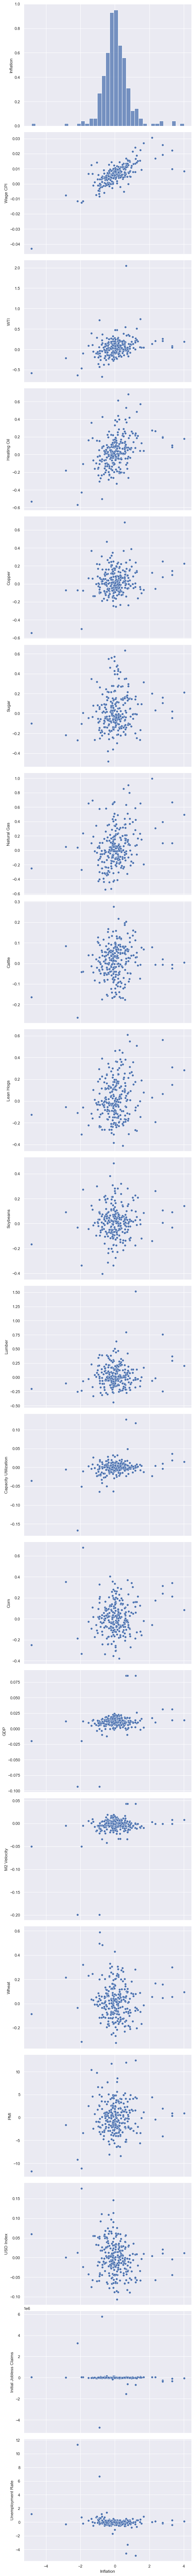

In [3947]:
sns.pairplot(QonQ_main,
            y_vars=['Inflation','Wage CPI','WTI','Heating Oil','Copper',
                'Sugar','Natural Gas','Cattle','Lean Hogs','Soybeans',
                'Lumber','Capacity Utilization','Corn','GDP','M2 Velocity',
                'Wheat','PMI','USD Index','Initial Jobless Claims','Unemployment Rate'], 
             x_vars=['Inflation'],
             height=5, aspect=1.5,
            )

We can see a **notable amount of variation** in `Inflation` on all variables. We will take a look at how this comes out on a histogram.

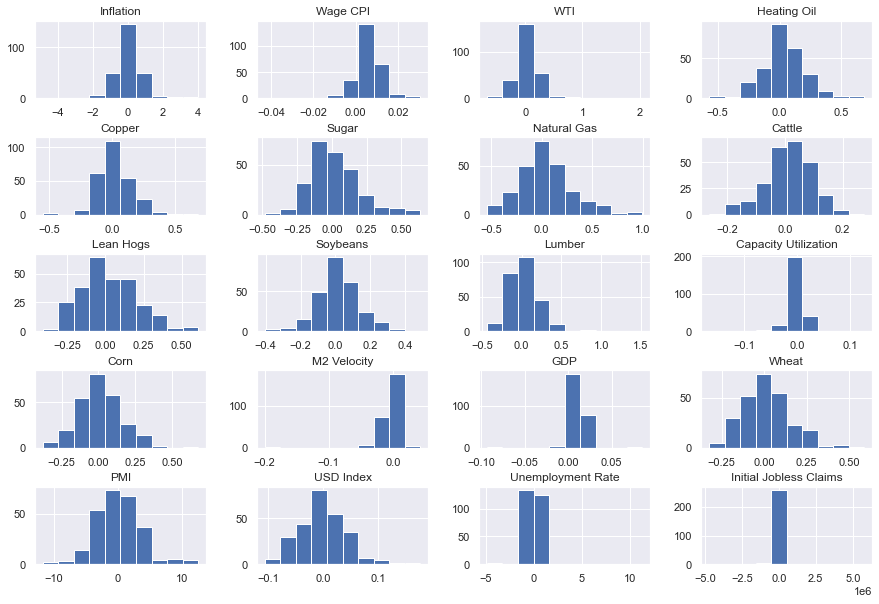

In [3948]:
QonQ_main.hist(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

([<matplotlib.axis.XTick at 0x224312e2d00>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

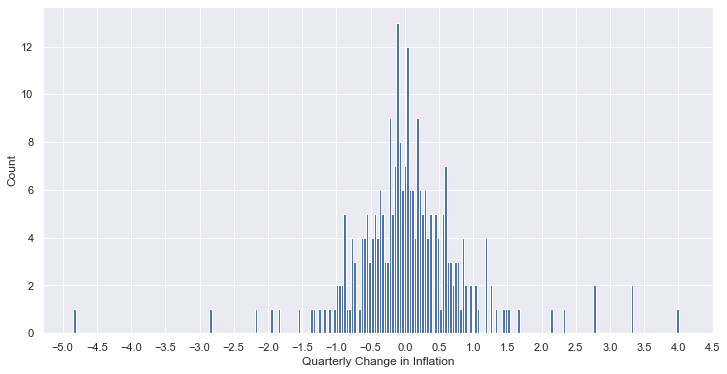

In [3949]:
plt.figure(figsize=(12,6))
plt.hist(QonQ_main['Inflation'], bins=240)
plt.xlabel('Quarterly Change in Inflation')
plt.ylabel('Count')

x_ticks = np.arange(-5, 5, 0.5)
plt.xticks(x_ticks)


Let's clean this up by Winsorization.

In [3950]:
# the numbers for the percentile
u_qoq_inf_per = 99
l_qoq_inf_per = 1

# the actual percentile
u_qoq_inf_num = (((u_qoq_inf_per / 100) - 1) * -1)
l_qoq_inf_num = l_qoq_inf_per / 100

# what would result in the dataframe be in the percentiles 
u_qoq_inf_value = np.percentile(QonQ_main['Inflation'], u_qoq_inf_per)
l_qoq_inf_value = np.percentile(QonQ_main['Inflation'], l_qoq_inf_per)

print('The Upper & Lower Quartiles are:','\n',
    'Upper |',"{:,}%".format(round((u_qoq_inf_value),2)),'\n',
     'Lower |',"{:,}%".format(round((l_qoq_inf_value),2)))

The Upper & Lower Quartiles are: 
 Upper | 2.98% 
 Lower | -2.03%


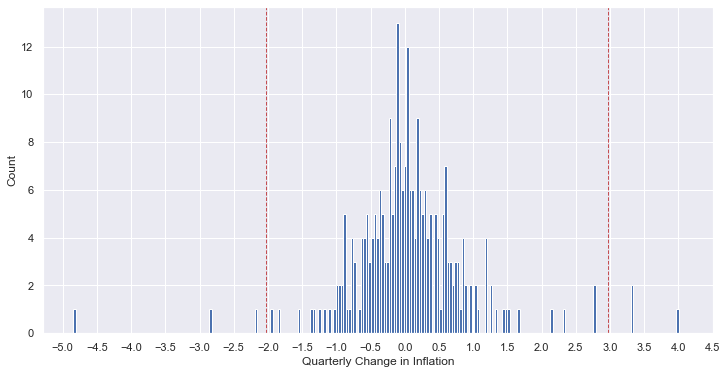

In [3951]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_main['Inflation'], bins=240)
plt.xlabel('Quarterly Change in Inflation')
plt.ylabel('Count')

x_ticks = np.arange(-5, 5, 0.5)
plt.xticks(x_ticks)
plt.axvline(u_qoq_inf_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_qoq_inf_value, color='r', linestyle='dashed', linewidth=1)

In [3952]:
QonQ_main_a = np.count_nonzero(QonQ_main['Inflation']>=u_qoq_inf_value)
QonQ_main_b = np.count_nonzero(QonQ_main['Inflation']<=l_qoq_inf_value)

print('With a dataframe with',len(QonQ_main),'observations, the Winsorization breakdown would be','\n',
     QonQ_main_a,'|', "{:,}%".format(round(((QonQ_main_a/len(QonQ_main))*100),2)),'|','Above','\n',
     QonQ_main_b,'|', "{:,}%".format(round(((QonQ_main_b/len(QonQ_main))*100),2)),'|','Below','\n',
     (QonQ_main_a + QonQ_main_b),'|', "{:,}%".format(round((((QonQ_main_a + QonQ_main_b)/len(QonQ_main))*100),2)),'|',
      'in Total')

With a dataframe with 263 observations, the Winsorization breakdown would be 
 3 | 1.14% | Above 
 3 | 1.14% | Below 
 6 | 2.28% | in Total


That's manageable; we will proceed.

In [3953]:
# Winsorize
QonQ_main["Inflation"] = winsorize(QonQ_main["Inflation"], limits=[l_qoq_inf_num, u_qoq_inf_num])

Text(0, 0.5, 'Count')

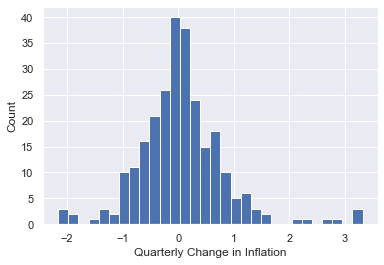

In [3954]:
plt.hist(QonQ_main['Inflation'], bins=30)
plt.xlabel('Quarterly Change in Inflation')
plt.ylabel('Count')

After Winsorizing on Inflation, let's see how the pair plots & histograms hold up.

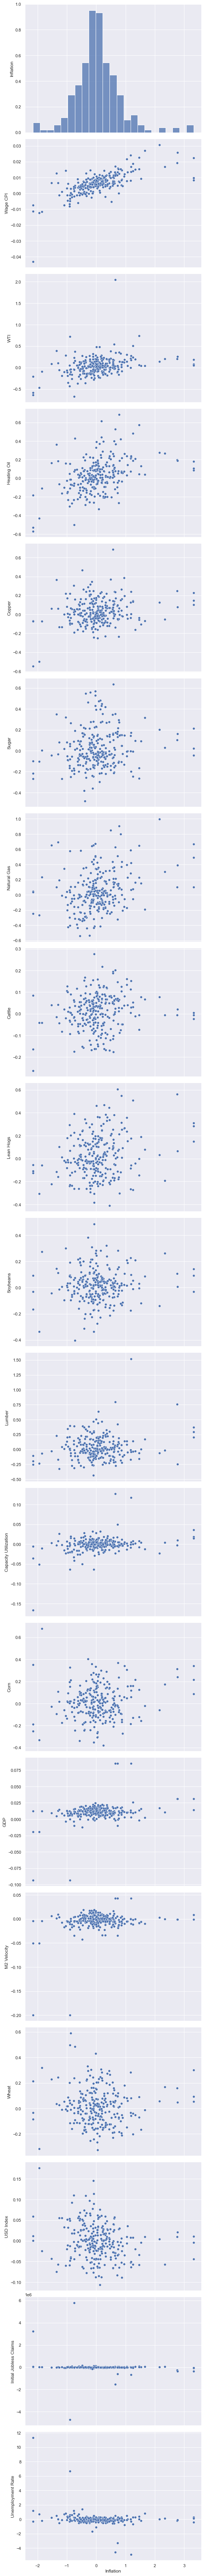

In [3955]:
sns.pairplot(QonQ_main,
            y_vars=['Inflation','Wage CPI','WTI','Heating Oil','Copper',
                'Sugar','Natural Gas','Cattle','Lean Hogs','Soybeans',
                'Lumber','Capacity Utilization','Corn','GDP','M2 Velocity',
                'Wheat','USD Index','Initial Jobless Claims','Unemployment Rate'], 
             x_vars=['Inflation'],
             height=5, aspect=1.5,
            )

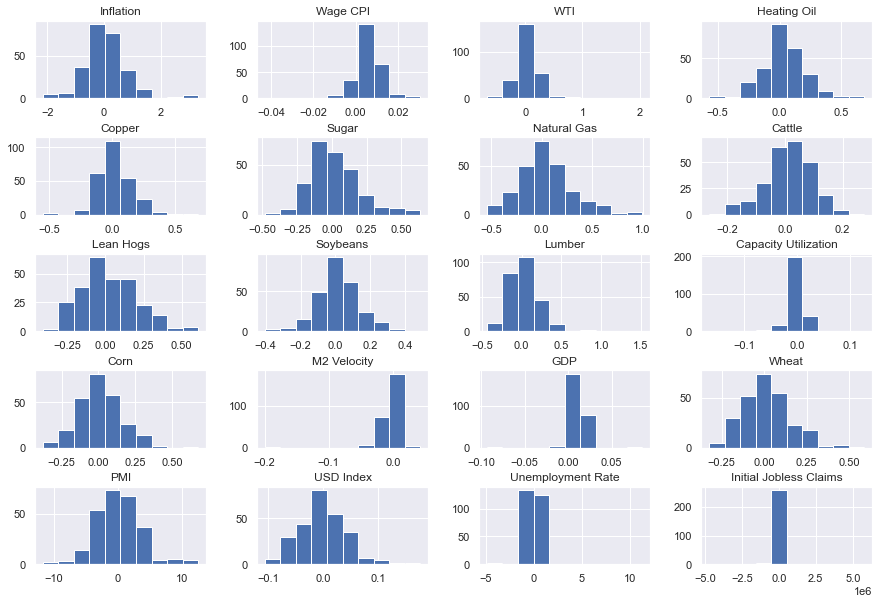

In [3956]:
QonQ_main.hist(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

In [3957]:
QonQ_main.corr(method='pearson')

Inflation  Wage CPI       WTI  Heating Oil    Copper  \
Inflation                1.000000  0.696483  0.333754     0.412341  0.201764   
Wage CPI                 0.696483  1.000000  0.414039     0.504391  0.338133   
WTI                      0.333754  0.414039  1.000000     0.802648  0.429691   
Heating Oil              0.412341  0.504391  0.802648     1.000000  0.421316   
Copper                   0.201764  0.338133  0.429691     0.421316  1.000000   
Sugar                    0.145100  0.189199  0.183456     0.170735  0.253624   
Natural Gas              0.301112  0.311826  0.254826     0.416147  0.088502   
Cattle                   0.138612  0.193130  0.156326     0.151087  0.115534   
Lean Hogs                0.237145  0.156911  0.139228     0.106418  0.169885   
Soybeans                 0.058665  0.140524  0.153833     0.172924  0.211508   
Lumber                   0.155501  0.117526  0.276986     0.144025  0.220536   
Capacity Utilization     0.292689  0.256493  0.439003     0.375378  0.237258   
Corn                     0.131061  0.113276  0.049593     0.066799  0.125917   
M2 Velocity              0.228008  0.300515  0.185950     0.240058  0.137452   
GDP                      0.304007  0.320423  0.306917     0.266138  0.168029   
Wheat                   -0.026351  0.006694 -0.011314     0.003713  0.086721   
PMI                      0.090324  0.217235  0.391420     0.326834  0.461730   
USD Index               -0.193628 -0.276067 -0.265854    -0.304872 -0.345169   
Unemployment Rate       -0.250314 -0.229997 -0.261154    -0.252454 -0.088837   
Initial Jobless Claims  -0.115989 -0.101529 -0.431617    -0.278046 -0.173248   

                           Sugar  Natural Gas    Cattle  Lean Hogs  Soybeans  \
Inflation               0.145100     0.301112  0.138612   0.237145  0.058665   
Wage CPI                0.189199     0.311826  0.193130   0.156911  0.140524   
WTI                     0.183456     0.254826  0.156326   0.139228  0.153833   
Heating Oil             0.170735     0.416147  0.151087   0.106418  0.172924   
Copper                  0.253624     0.088502  0.115534   0.169885  0.211508   
Sugar                   1.000000     0.154146  0.028564  -0.080746  0.136538   
Natural Gas             0.154146     1.000000  0.014552   0.029104  0.059338   
Cattle                  0.028564     0.014552  1.000000   0.171549  0.087953   
Lean Hogs              -0.080746     0.029104  0.171549   1.000000  0.213798   
Soybeans                0.136538     0.059338  0.087953   0.213798  1.000000   
Lumber                  0.084261    -0.070042  0.185262   0.207079  0.204917   
Capacity Utilization    0.171974     0.124381  0.293488   0.159495  0.138453   
Corn                    0.083086     0.085647  0.030461   0.264801  0.702756   
M2 Velocity             0.111305     0.088869  0.199834   0.120457  0.043484   
GDP                     0.129998     0.109881  0.236815   0.198488  0.070339   
Wheat                   0.088264     0.013645  0.010376   0.041139  0.435447   
PMI                     0.146585     0.029158  0.185417   0.117522  0.148749   
USD Index              -0.138214    -0.237155 -0.049044   0.042927 -0.142929   
Unemployment Rate      -0.119195    -0.065830 -0.286059  -0.134725 -0.068331   
Initial Jobless Claims -0.130318    -0.057882 -0.174793  -0.060119 -0.056970   

                          Lumber  Capacity Utilization      Corn  M2 Velocity  \
Inflation               0.155501              0.292689  0.131061     0.228008   
Wage CPI                0.117526              0.256493  0.113276     0.300515   
WTI                     0.276986              0.439003  0.049593     0.185950   
Heating Oil             0.144025              0.375378  0.066799     0.240058   
Copper                  0.220536              0.237258  0.125917     0.137452   
Sugar                   0.084261              0.171974  0.083086     0.111305   
Natural Gas            -0.070042              0.124381  0.085647     0.088869   
Cattle        

{'whiskers': [<matplotlib.lines.Line2D at 0x2245d8e1130>,
 'caps': [<matplotlib.lines.Line2D at 0x2245d8f3520>,
 'boxes': [<matplotlib.lines.Line2D at 0x2245d8e1430>],
 'medians': [<matplotlib.lines.Line2D at 0x2245d8f3bb0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2245d8f3ee0>],
 'means': []}

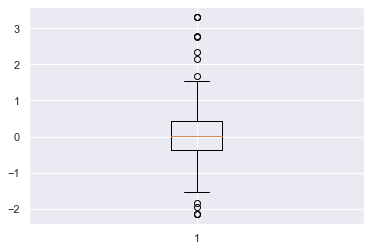

In [3958]:
plt.boxplot(QonQ_main['Inflation'])

### 2.5.3 Q on Q Pearson<a id='q_q_pearson'></a>

Text(0.5, 1.0, 'Quarter on Quarter Comparison')

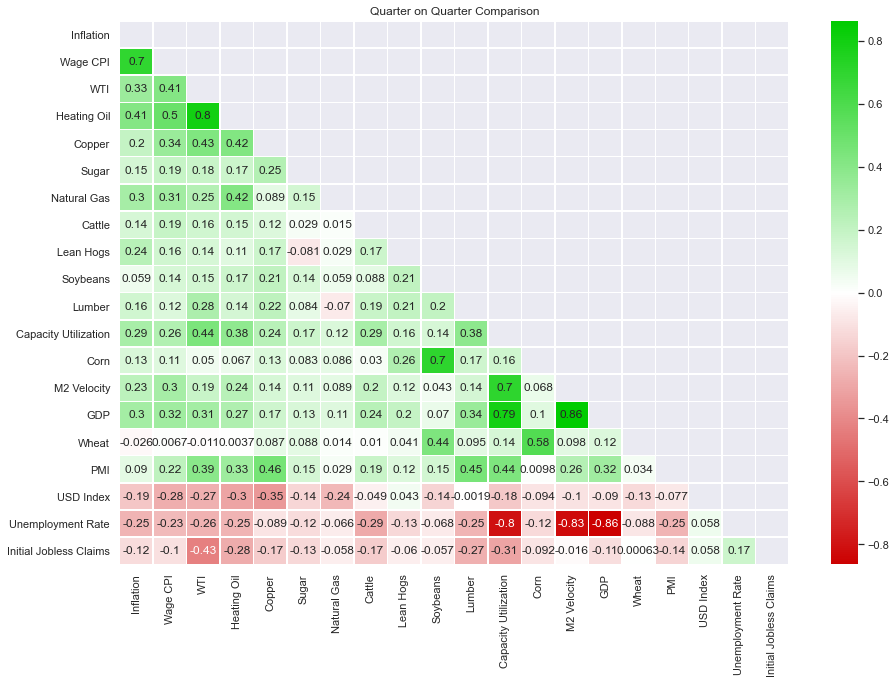

In [3959]:
plt.subplots(figsize=(15,10))
matrix = np.triu(QonQ_main.corr())
sns.heatmap(QonQ_main.corr(), mask=matrix, linewidths=.5, cmap=GnRd, annot=True)
plt.title('Quarter on Quarter Comparison')

In [3960]:
# looking at the average pearson coefficient
q_q_main = QonQ_main.corr(method='pearson')
q_q_main = pd.DataFrame(q_q_main['Inflation'])
q_q_main = q_q_main.iloc[1: , :]
q_q_main['AbsAmount'] = q_q_main['Inflation'].abs()
q_q_main_av = q_q_main['AbsAmount'].mean()


In [3961]:
QonQ_main = QonQ_main.sort_values(by="Date", ascending=True)
QonQ_main_csv = pd.DataFrame(QonQ_main)

QonQ_main_csv.to_excel('./_Inflation_Capstone/data/1.0_Segmented_by_periods/QonQ_main.xlsx')
print('Finished')

Finished


## 2.6 Monthly Comparison<a id='m_m'></a>

In 2.6 I will be setting up the infrastructure for **comparing monthly changes on all variables** against a **monthly change in inflation** to ascertain if there's any correlation & if so by which variables are more pronounced. 

In [3962]:
# ( Complete ) Daily | USD & WTI 
M_usd_index = usd_index['Settle'].pct_change(periods=30)
M_wti = wti['Last'].pct_change(periods=30)
M_copper = copper['Close'].pct_change(periods=30)
M_soybeans = soybeans['Close'].pct_change(periods=30)
M_natgas = natgas['Close'].pct_change(periods=30)
M_heatoil = heatoil['Close'].pct_change(periods=30)
M_corn = corn['Close'].pct_change(periods=30)
M_wheat = wheat['Close'].pct_change(periods=30)
M_cattle = cattle['Close'].pct_change(periods=30)
M_sugar = sugar['Close'].pct_change(periods=30)
M_lumber = lumber['Close'].pct_change(periods=30)
M_leanhogs = leanhogs['Close'].pct_change(periods=30)

# ( Complete ) Weekly | Initial Jobless Claims
M_intjobs = int_job_claims.diff(periods=4)

# ( Complete ) Mnthly | Capacity Utilization, Wages, Inflation
M_caputil = cap_util.pct_change(periods=1)
M_wages = wages_cpi.pct_change(periods=1)
M_cpi = cpi.diff(periods=1)
M_unrate = unrate.diff(periods=1)
M_pmi = comppmi.diff(periods=3)


# ( Complete ) Quarterly | GDP, Velocity of Money
# M_gdp = us_gdp.pct_change(periods=1)
# M_m2_velo = m2_velo.pct_change(periods=1)

In [3963]:
# Building out the variables first with a forward fill
MonM_vars = pd.concat([M_wages,M_wti,M_heatoil,M_copper,M_sugar,M_natgas,
                       M_cattle,M_leanhogs,M_soybeans,M_lumber,M_caputil,M_corn,
                       M_wheat,M_pmi,M_usd_index,M_unrate,M_intjobs],
                      axis = 1, ignore_index=False)

MonM_vars.columns= ['Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','Wheat','PMI',
                     'USD Index','Unemployment Rate','Initial Jobless Claims'
                   ]

MonM_vars.index.names = ["Date"]
MonM_vars = MonM_vars.fillna(method='ffill')

# vars_mnth.tail()

In [3964]:
MonM_vars.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14298 entries, 1947-01-01 to 2021-09-03
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wage CPI                14297 non-null  float64
 1   WTI                     12210 non-null  float64
 2   Heating Oil             13210 non-null  float64
 3   Copper                  10565 non-null  float64
 4   Sugar                   13212 non-null  float64
 5   Natural Gas             10041 non-null  float64
 6   Cattle                  13207 non-null  float64
 7   Lean Hogs               13212 non-null  float64
 8   Soybeans                10122 non-null  float64
 9   Lumber                  13212 non-null  float64
 10  Capacity Utilization    14053 non-null  float64
 11  Corn                    13209 non-null  float64
 12  Wheat                   10122 non-null  float64
 13  PMI                     14283 non-null  float64
 14  USD Index            

In [3965]:
# As before, working backwards off of Natural Gas to bring the data together
# MonM_vars['Natural Gas'].tail(8302)

MonM_vars = MonM_vars.loc['1990-05-17':today_y_m_d_dash]

In [3966]:
MonM_vars.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10041 entries, 1990-05-17 to 2021-09-03
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wage CPI                10041 non-null  float64
 1   WTI                     10041 non-null  float64
 2   Heating Oil             10041 non-null  float64
 3   Copper                  10041 non-null  float64
 4   Sugar                   10041 non-null  float64
 5   Natural Gas             10041 non-null  float64
 6   Cattle                  10041 non-null  float64
 7   Lean Hogs               10041 non-null  float64
 8   Soybeans                10041 non-null  float64
 9   Lumber                  10041 non-null  float64
 10  Capacity Utilization    10041 non-null  float64
 11  Corn                    10041 non-null  float64
 12  Wheat                   10041 non-null  float64
 13  PMI                     10041 non-null  float64
 14  USD Index            

In [3967]:
# Putting them together with inflation
MonM_main = M_cpi.merge(MonM_vars, how='left', on='Date')

MonM_main = MonM_main[MonM_main.index.dayofweek < 5]

MonM_main.columns = ['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                    'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber','Capacity Utilization',
                    'Corn','Wheat','PMI','USD Index','Initial Jobless Claims','Unemployment Rate'
                    ]

MonM_main = MonM_main.dropna()

In [3968]:
MonM_main.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 264 entries, 1990-05-31 to 2021-06-30
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               264 non-null    float64
 1   Wage CPI                264 non-null    float64
 2   WTI                     264 non-null    float64
 3   Heating Oil             264 non-null    float64
 4   Copper                  264 non-null    float64
 5   Sugar                   264 non-null    float64
 6   Natural Gas             264 non-null    float64
 7   Cattle                  264 non-null    float64
 8   Lean Hogs               264 non-null    float64
 9   Soybeans                264 non-null    float64
 10  Lumber                  264 non-null    float64
 11  Capacity Utilization    264 non-null    float64
 12  Corn                    264 non-null    float64
 13  Wheat                   264 non-null    float64
 14  PMI                    

## 2.6.2 Cleaning the Monthly Dataframe for outliers<a id='m_m_clean'></a>

Here I begin to determine where outliers are:

In [3969]:
MonM_main.corr(method='pearson')

Inflation  Wage CPI       WTI  Heating Oil    Copper  \
Inflation                1.000000  0.719317  0.284739     0.301772  0.134604   
Wage CPI                 0.719317  1.000000  0.362659     0.384036  0.205808   
WTI                      0.284739  0.362659  1.000000     0.828404  0.380620   
Heating Oil              0.301772  0.384036  0.828404     1.000000  0.341413   
Copper                   0.134604  0.205808  0.380620     0.341413  1.000000   
Sugar                    0.142635  0.137539  0.115132     0.107551  0.198624   
Natural Gas              0.145422  0.157792  0.234927     0.321547  0.003167   
Cattle                   0.020434  0.081558  0.083975     0.074420  0.118645   
Lean Hogs                0.087625  0.027427  0.066280     0.024780  0.159879   
Soybeans                 0.092269  0.078868  0.121114     0.137642  0.247743   
Lumber                   0.231314  0.140826  0.147076     0.090268  0.207197   
Capacity Utilization     0.262611  0.243037  0.196182     0.215683  0.085581   
Corn                     0.118470  0.047979  0.061199     0.071455  0.106870   
Wheat                   -0.027582 -0.001913 -0.031101     0.026412  0.056017   
PMI                      0.178149  0.231893  0.227651     0.237449  0.355606   
USD Index               -0.096727 -0.153332 -0.263972    -0.185865 -0.269604   
Initial Jobless Claims  -0.252745 -0.246046 -0.137167    -0.169833 -0.014818   
Unemployment Rate       -0.051280 -0.027778 -0.258514    -0.143787 -0.137258   

                           Sugar  Natural Gas    Cattle  Lean Hogs  Soybeans  \
Inflation               0.142635     0.145422  0.020434   0.087625  0.092269   
Wage CPI                0.137539     0.157792  0.081558   0.027427  0.078868   
WTI                     0.115132     0.234927  0.083975   0.066280  0.121114   
Heating Oil             0.107551     0.321547  0.074420   0.024780  0.137642   
Copper                  0.198624     0.003167  0.118645   0.159879  0.247743   
Sugar                   1.000000     0.087627  0.071865  -0.039755  0.157809   
Natural Gas             0.087627     1.000000 -0.053282   0.061311  0.047395   
Cattle                  0.071865    -0.053282  1.000000   0.176026  0.087446   
Lean Hogs              -0.039755     0.061311  0.176026   1.000000  0.170448   
Soybeans                0.157809     0.047395  0.087446   0.170448  1.000000   
Lumber                  0.041547    -0.042052  0.114045   0.090664  0.174476   
Capacity Utilization    0.082324    -0.018265  0.105308   0.034324  0.073083   
Corn                    0.108316     0.084930 -0.033038   0.144774  0.655359   
Wheat                   0.106298     0.032203  0.031942   0.033162  0.422737   
PMI                     0.079476     0.063723  0.108916   0.041630  0.094046   
USD Index              -0.086497    -0.132420 -0.016352   0.016811 -0.145941   
Initial Jobless Claims -0.040838     0.022428 -0.067568  -0.036974 -0.067806   
Unemployment Rate      -0.161886    -0.081708 -0.137898  -0.095106  0.003433   

                          Lumber  Capacity Utilization      Corn     Wheat  \
Inflation               0.231314              0.262611  0.118470 -0.027582   
Wage CPI                0.140826              0.243037  0.047979 -0.001913   
WTI                     0.147076              0.196182  0.061199 -0.031101   
Heating Oil             0.090268              0.215683  0.071455  0.026412   
Copper                  0.207197              0.085581  0.106870  0.056017   
Sugar                   0.041547              0.082324  0.108316  0.106298   
Natural Gas            -0.042052             -0.018265  0.084930  0.032203   
Cattle                  0.114045              0.105308 -0.033038  0.031942   
Lean Hogs               0.090664              0.034324  0.144774  0.033162   
Soybeans                0.174476              0.073083  0.655359  0.422737   
Lumber                  1.000000              0.183119  0.130514  0.094288   
Capacity Utilization    0.183119              

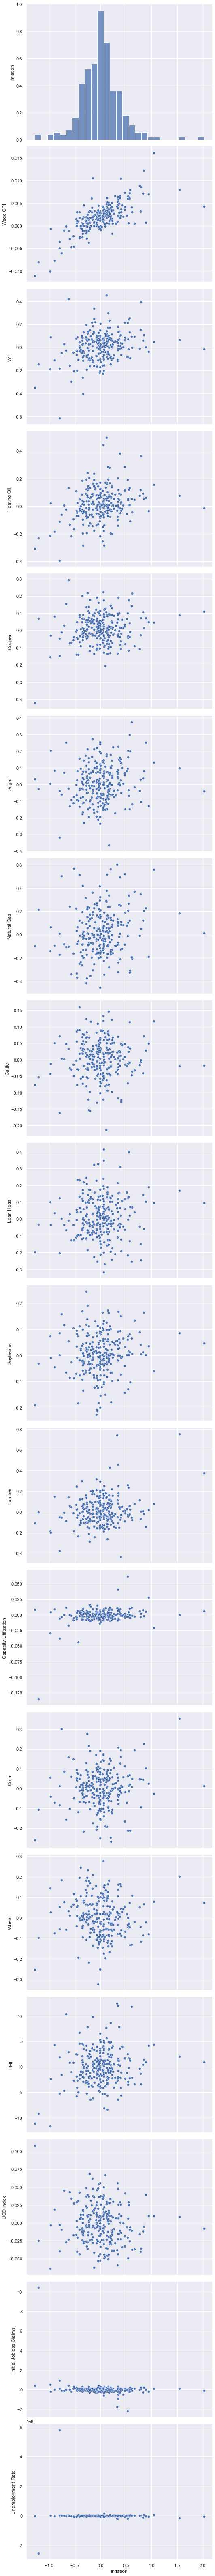

In [3970]:
sns.pairplot(MonM_main,
            y_vars=['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                    'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber','Capacity Utilization',
                    'Corn','Wheat','PMI','USD Index','Initial Jobless Claims','Unemployment Rate'], 
             x_vars=['Inflation'],
             height=5, aspect=1.5,
            )

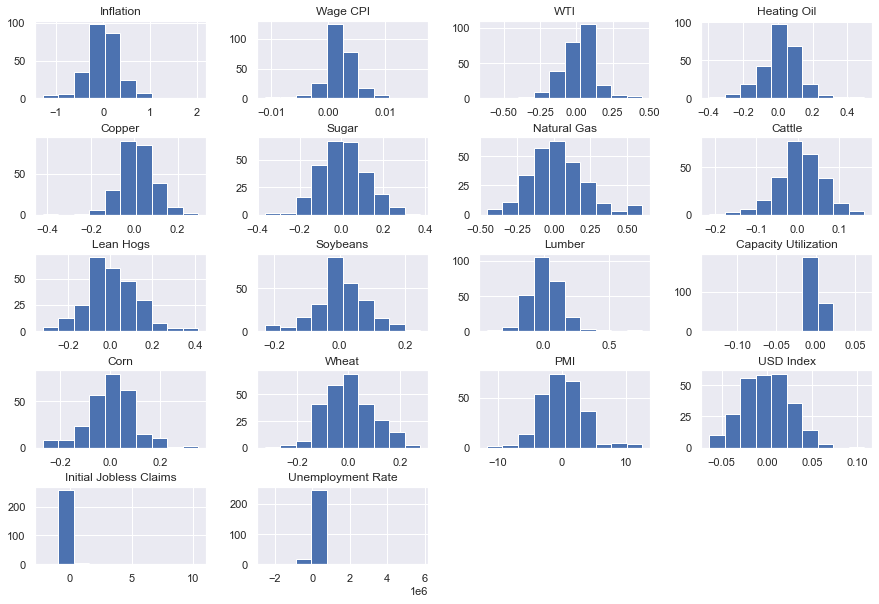

In [3971]:
MonM_main.hist(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

We see **"some" amount of variation** in `Inflation` on all variables. We will take a look at how this comes out on a histogram again.

([<matplotlib.axis.XTick at 0x224606f2a60>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

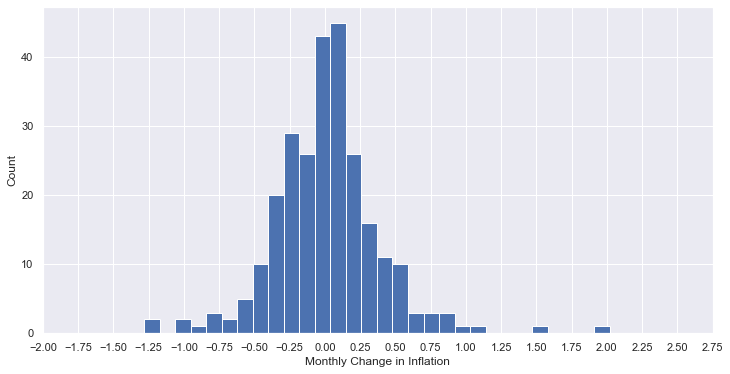

In [3972]:
plt.figure(figsize=(12,6))
plt.hist(MonM_main['Inflation'], bins=30)
plt.xlabel('Monthly Change in Inflation')
plt.ylabel('Count')

x_ticks = np.arange(-2, 3, 0.25)
plt.xticks(x_ticks)

Let's clean this up by Winsorization

In [3973]:
# the numbers for the percentile
u_MoM_inf_per = 99
l_MoM_inf_per = 1

# the actual percentile
u_MoM_inf_num = (((u_MoM_inf_per / 100) - 1) * -1)
l_MoM_inf_num = l_MoM_inf_per / 100

# what would result in the dataframe be in the percentiles 
u_MoM_inf_value = np.percentile(MonM_main['Inflation'], u_MoM_inf_per)
l_MoM_inf_value = np.percentile(MonM_main['Inflation'], l_MoM_inf_per)

print('The Upper & Lower Quartiles are:','\n',
    'Upper |',"{:,}%".format(round((u_MoM_inf_value),2)),'\n',
     'Lower |',"{:,}%".format(round((l_MoM_inf_value),2)))

The Upper & Lower Quartiles are: 
 Upper | 0.98% 
 Lower | -0.97%


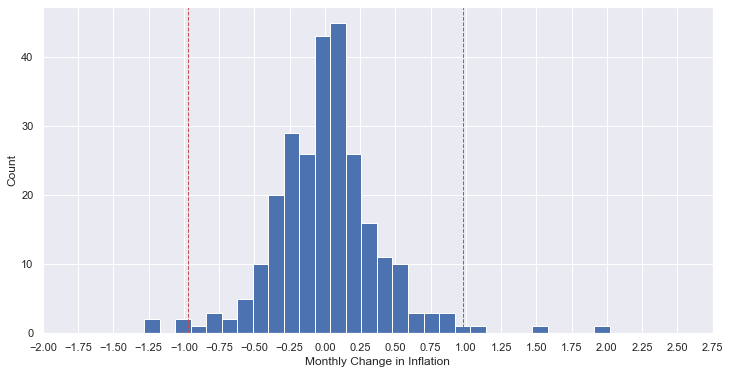

In [3974]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(MonM_main['Inflation'], bins=30)
plt.xlabel('Monthly Change in Inflation')
plt.ylabel('Count')

x_ticks = np.arange(-2, 3, 0.25)
plt.xticks(x_ticks)
plt.axvline(u_MoM_inf_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_MoM_inf_value, color='r', linestyle='dashed', linewidth=1)

In [3975]:
MonM_main_a = np.count_nonzero(MonM_main['Inflation']>=u_MoM_inf_value)
MonM_main_b = np.count_nonzero(MonM_main['Inflation']<=l_MoM_inf_value)

print('With a dataframe with',len(MonM_main),'observations, the Winsorization breakdown would be','\n',
     MonM_main_a,'|', "{:,}%".format(round(((MonM_main_a/len(MonM_main))*100),2)),'|','Above','\n',
     MonM_main_b,'|', "{:,}%".format(round(((MonM_main_b/len(MonM_main))*100),2)),'|','Below','\n',
     (MonM_main_a + MonM_main_b),'|', "{:,}%".format(round((((MonM_main_a + MonM_main_b)/len(MonM_main))*100),2)),'|',
      'in Total')

With a dataframe with 264 observations, the Winsorization breakdown would be 
 3 | 1.14% | Above 
 3 | 1.14% | Below 
 6 | 2.27% | in Total


That's manageable; we will proceed.

In [3976]:
# Winsorize
MonM_main["Inflation"] = winsorize(MonM_main["Inflation"], limits=[l_MoM_inf_num, u_MoM_inf_num])

Text(0, 0.5, 'Count')

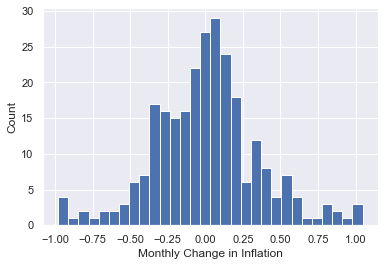

In [3977]:
plt.hist(MonM_main['Inflation'], bins=30)
plt.xlabel('Monthly Change in Inflation')
plt.ylabel('Count')

Checking the pair plots & histogram once more.

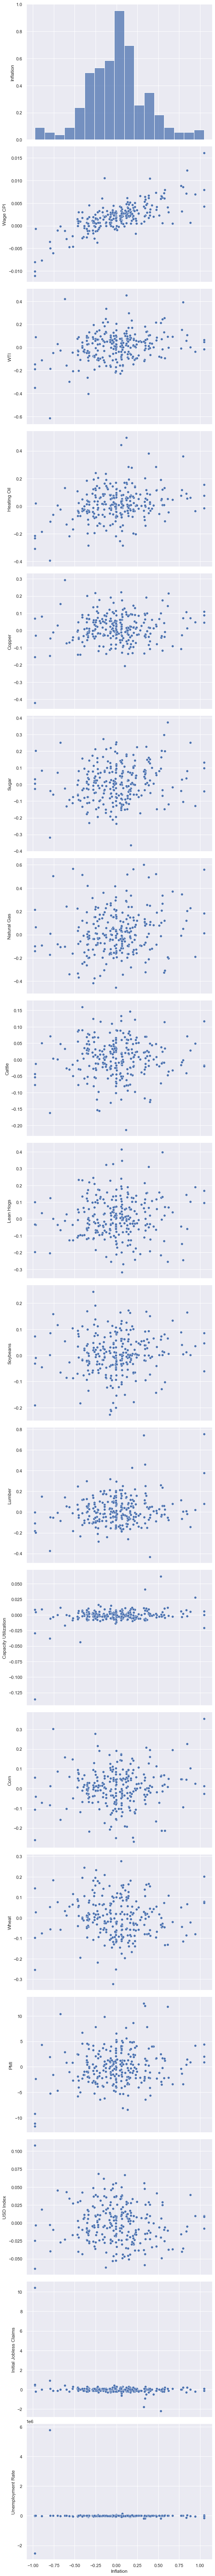

In [3978]:
sns.pairplot(MonM_main,
            y_vars=['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                    'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber','Capacity Utilization',
                    'Corn','Wheat','PMI','USD Index','Initial Jobless Claims','Unemployment Rate'], 
             x_vars=['Inflation'],
             height=5, aspect=1.5,
            )

Text(0, 0.5, 'Probability')

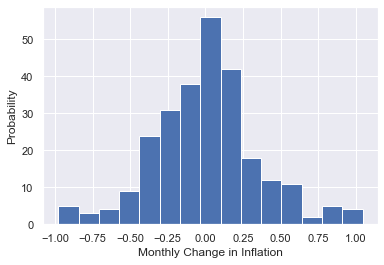

In [3979]:
plt.hist(MonM_main['Inflation'], bins=15)
plt.xlabel('Monthly Change in Inflation')
plt.ylabel('Probability')

Not perfectly normal but we will proceed.

In [3980]:
MonM_main.corr(method='pearson')

Inflation  Wage CPI       WTI  Heating Oil    Copper  \
Inflation                1.000000  0.735427  0.294497     0.311518  0.112331   
Wage CPI                 0.735427  1.000000  0.362659     0.384036  0.205808   
WTI                      0.294497  0.362659  1.000000     0.828404  0.380620   
Heating Oil              0.311518  0.384036  0.828404     1.000000  0.341413   
Copper                   0.112331  0.205808  0.380620     0.341413  1.000000   
Sugar                    0.154075  0.137539  0.115132     0.107551  0.198624   
Natural Gas              0.153449  0.157792  0.234927     0.321547  0.003167   
Cattle                   0.021154  0.081558  0.083975     0.074420  0.118645   
Lean Hogs                0.073607  0.027427  0.066280     0.024780  0.159879   
Soybeans                 0.078876  0.078868  0.121114     0.137642  0.247743   
Lumber                   0.191207  0.140826  0.147076     0.090268  0.207197   
Capacity Utilization     0.251826  0.243037  0.196182     0.215683  0.085581   
Corn                     0.095614  0.047979  0.061199     0.071455  0.106870   
Wheat                   -0.060035 -0.001913 -0.031101     0.026412  0.056017   
PMI                      0.170057  0.231893  0.227651     0.237449  0.355606   
USD Index               -0.093001 -0.153332 -0.263972    -0.185865 -0.269604   
Initial Jobless Claims  -0.232367 -0.246046 -0.137167    -0.169833 -0.014818   
Unemployment Rate       -0.068129 -0.027778 -0.258514    -0.143787 -0.137258   

                           Sugar  Natural Gas    Cattle  Lean Hogs  Soybeans  \
Inflation               0.154075     0.153449  0.021154   0.073607  0.078876   
Wage CPI                0.137539     0.157792  0.081558   0.027427  0.078868   
WTI                     0.115132     0.234927  0.083975   0.066280  0.121114   
Heating Oil             0.107551     0.321547  0.074420   0.024780  0.137642   
Copper                  0.198624     0.003167  0.118645   0.159879  0.247743   
Sugar                   1.000000     0.087627  0.071865  -0.039755  0.157809   
Natural Gas             0.087627     1.000000 -0.053282   0.061311  0.047395   
Cattle                  0.071865    -0.053282  1.000000   0.176026  0.087446   
Lean Hogs              -0.039755     0.061311  0.176026   1.000000  0.170448   
Soybeans                0.157809     0.047395  0.087446   0.170448  1.000000   
Lumber                  0.041547    -0.042052  0.114045   0.090664  0.174476   
Capacity Utilization    0.082324    -0.018265  0.105308   0.034324  0.073083   
Corn                    0.108316     0.084930 -0.033038   0.144774  0.655359   
Wheat                   0.106298     0.032203  0.031942   0.033162  0.422737   
PMI                     0.079476     0.063723  0.108916   0.041630  0.094046   
USD Index              -0.086497    -0.132420 -0.016352   0.016811 -0.145941   
Initial Jobless Claims -0.040838     0.022428 -0.067568  -0.036974 -0.067806   
Unemployment Rate      -0.161886    -0.081708 -0.137898  -0.095106  0.003433   

                          Lumber  Capacity Utilization      Corn     Wheat  \
Inflation               0.191207              0.251826  0.095614 -0.060035   
Wage CPI                0.140826              0.243037  0.047979 -0.001913   
WTI                     0.147076              0.196182  0.061199 -0.031101   
Heating Oil             0.090268              0.215683  0.071455  0.026412   
Copper                  0.207197              0.085581  0.106870  0.056017   
Sugar                   0.041547              0.082324  0.108316  0.106298   
Natural Gas            -0.042052             -0.018265  0.084930  0.032203   
Cattle                  0.114045              0.105308 -0.033038  0.031942   
Lean Hogs               0.090664              0.034324  0.144774  0.033162   
Soybeans                0.174476              0.073083  0.655359  0.422737   
Lumber                  1.000000              0.183119  0.130514  0.094288   
Capacity Utilization    0.183119              

{'whiskers': [<matplotlib.lines.Line2D at 0x22462bcfd30>,
 'caps': [<matplotlib.lines.Line2D at 0x22462bf8430>,
 'boxes': [<matplotlib.lines.Line2D at 0x22462bcf9d0>],
 'medians': [<matplotlib.lines.Line2D at 0x22462bf8af0>],
 'fliers': [<matplotlib.lines.Line2D at 0x22462bf8e50>],
 'means': []}

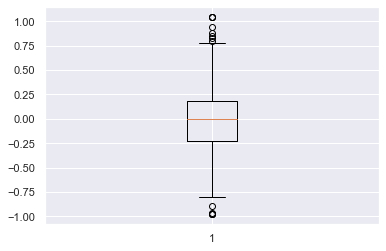

In [3981]:
plt.boxplot(MonM_main['Inflation'])

## 2.6.3 Monthly Pearson<a id='m_m_pearson'></a>

Text(0.5, 1.0, 'Month on Month Comparison')

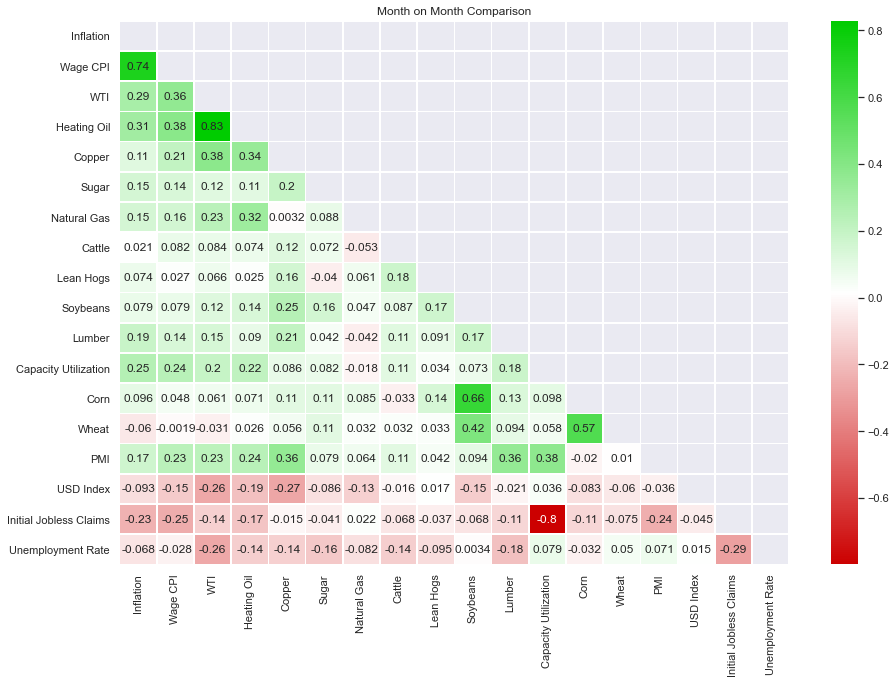

In [3982]:
plt.subplots(figsize=(15,10))
matrix = np.triu(MonM_main.corr())
sns.heatmap(MonM_main.corr(), mask=matrix, linewidths=.5, cmap=GnRd, annot=True)
plt.title('Month on Month Comparison')

In [3983]:
# looking at the average pearson coefficient
m_m_main = MonM_main.corr(method='pearson')
m_m_main = pd.DataFrame(m_m_main['Inflation'])
m_m_main = m_m_main.iloc[1: , :]
m_m_main['AbsAmount'] = m_m_main['Inflation'].abs()
m_m_main_av = m_m_main['AbsAmount'].mean()

In [3984]:
MonM_main = MonM_main.sort_values(by="Date", ascending=True)
MonM_main_csv = pd.DataFrame(MonM_main)

MonM_main_csv.to_excel('./_Inflation_Capstone/data/1.0_Segmented_by_periods/MonM_main.xlsx')
print('Finished')

Finished


## 2.7 Quarterly Changes | Variables ( past ) & Inflation ( forwards )<a id='q_pf'></a>

In 2.7 I will be setting up the infrastructure to **compare quarterly changes on all variables ( one quarter in the past )** against a **quarterly change in inflation ( one quarter in the future )** to ascertain if there's any relationship to **predict** `Inflation` one quarter in advance.  

In [3985]:
# ( Complete ) Daily | USD & WTI | removed 24 days from 90 ( i.e. weekends ) but doesn't include holidays
Q_usd_index = usd_index['Settle'].pct_change(periods=66)
Q_wti = wti['Last'].pct_change(periods=66)

Q_copper = copper['Close'].pct_change(periods=66)
Q_soybeans = soybeans['Close'].pct_change(periods=66)
Q_natgas = natgas['Close'].pct_change(periods=66)
Q_heatoil = heatoil['Close'].pct_change(periods=66)
Q_corn = corn['Close'].pct_change(periods=66)
Q_wheat = wheat['Close'].pct_change(periods=66)
Q_cattle = cattle['Close'].pct_change(periods=66)
Q_sugar = sugar['Close'].pct_change(periods=66)
Q_lumber = lumber['Close'].pct_change(periods=66)
Q_leanhogs = leanhogs['Close'].pct_change(periods=66)

# ( Complete ) Weekly | Initial Jobless Claims
Q_intjobs = int_job_claims.diff(periods=12)

# ( Complete ) Mnthly | Capacity Utilization, Wages, Inflation
Q_caputil = cap_util.pct_change(periods=3)
Q_wages = wages_cpi.pct_change(periods=3)
Q_cpi_past = cpi.diff(periods=-3)
Q_unrate = unrate.diff(periods=3)

# ( Complete ) Quarterly | GDP, Velocity of Money
Q_gdp = gdp.pct_change(periods=1)
Q_m2_velo = m2_velo.pct_change(periods=1)

Checking to see if the `Inflation` function works as I intend 

In [3986]:
# To compare what the function is returning
Q_cpi_past.tail(5)

Value
Date             
2021-03-31 -2.771
2021-04-30 -1.205
2021-05-31    NaN
2021-06-30    NaN
2021-07-31    NaN

In [3987]:
# I start with the actual data
cpi.tail(10)

Value
Date             
2020-10-31  1.182
2020-11-30  1.175
2020-12-31  1.362
2021-01-31  1.400
2021-02-28  1.676
2021-03-31  2.620
2021-04-30  4.160
2021-05-31  4.993
2021-06-30  5.391
2021-07-31  5.365

In [3988]:
print('The 31 May 2021 # of 4.993 minus 3 months before ( 2021-02-28 ) show: ', round((4.993-1.676),3) )

The 31 May 2021 # of 4.993 minus 3 months before ( 2021-02-28 ) show:  3.317


This **appears to be incorrect,** meaning it should be a positive number but shows a negative number in the `Q_cpi_p` tail. **Let's check the one behind to see what that shows.**

In [3989]:
print('The 30 Apr 2021 # of 4.160 minus 3 months before ( 31 Jan 2021 ) show: ', round((4.160-1.400),3) )

The 30 Apr 2021 # of 4.160 minus 3 months before ( 31 Jan 2021 ) show:  2.76


This shows a negative number while the function shows a positive. It appears as though the function need to be multiplied by -1 to show the correct #. 

**We will change the** `Q_cpi_p` **# below.**

In [3990]:
Q_cpi_past = cpi.diff(periods=-3) * -1

Double check:

In [3991]:
Q_cpi_past.tail(5)

Value
Date             
2021-03-31  2.771
2021-04-30  1.205
2021-05-31    NaN
2021-06-30    NaN
2021-07-31    NaN

We have "righted the wrong"; ready to proceed.

In [3992]:
# Putting them together with inflation
QonQ_main_cpi_past = Q_cpi_past.merge(QonQ_vars, how='left', on='Date')

# QonQ_main_cpi_past= QonQ_main_cpi_past[QonQ_main_cpi_past.index.dayofweek < 5]

QonQ_main_cpi_past.columns = ['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','M2 Velocity','GDP','Wheat','PMI',
                     'USD Index','Unemployment Rate','Initial Jobless Claims']

QonQ_main_cpi_past = QonQ_main_cpi_past.dropna()

In [3993]:
QonQ_main_cpi_past.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 1990-07-31 to 2021-04-30
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               261 non-null    float64
 1   Wage CPI                261 non-null    float64
 2   WTI                     261 non-null    float64
 3   Heating Oil             261 non-null    float64
 4   Copper                  261 non-null    float64
 5   Sugar                   261 non-null    float64
 6   Natural Gas             261 non-null    float64
 7   Cattle                  261 non-null    float64
 8   Lean Hogs               261 non-null    float64
 9   Soybeans                261 non-null    float64
 10  Lumber                  261 non-null    float64
 11  Capacity Utilization    261 non-null    float64
 12  Corn                    261 non-null    float64
 13  M2 Velocity             261 non-null    float64
 14  GDP                    

### 2.7.2 Cleaning the Dataframe for outliers<a id='q_pf_clean'></a>

Here's where are will see if this Dataframe needs cleaning for outliers.

In [3994]:
QonQ_main_cpi_past.corr(method='pearson')

Inflation  Wage CPI       WTI  Heating Oil    Copper  \
Inflation                1.000000  0.020265  0.202834     0.239641  0.283831   
Wage CPI                 0.020265  1.000000  0.414612     0.505661  0.336077   
WTI                      0.202834  0.414612  1.000000     0.802174  0.429657   
Heating Oil              0.239641  0.505661  0.802174     1.000000  0.420210   
Copper                   0.283831  0.336077  0.429657     0.420210  1.000000   
Sugar                    0.202728  0.189328  0.181202     0.169234  0.254498   
Natural Gas              0.102653  0.305084  0.251183     0.413592  0.086512   
Cattle                  -0.029647  0.199579  0.156316     0.151389  0.116325   
Lean Hogs                0.040494  0.144853  0.138941     0.103899  0.165519   
Soybeans                 0.219984  0.139632  0.154361     0.172629  0.210084   
Lumber                   0.092620  0.125443  0.284352     0.147896  0.220066   
Capacity Utilization     0.185139  0.242810  0.440530     0.374084  0.232589   
Corn                     0.198386  0.087165  0.043940     0.060164  0.120580   
M2 Velocity              0.032219  0.306511  0.185817     0.239897  0.137113   
GDP                      0.056860  0.301383  0.304085     0.261520  0.162802   
Wheat                    0.100102  0.002030 -0.012189     0.002607  0.085733   
PMI                      0.141373  0.236320  0.397585     0.332026  0.464943   
USD Index               -0.228561 -0.288980 -0.268361    -0.307117 -0.346322   
Unemployment Rate       -0.021004 -0.231785 -0.261284    -0.252047 -0.087571   
Initial Jobless Claims  -0.074609 -0.089831 -0.430315    -0.275542 -0.170626   

                           Sugar  Natural Gas    Cattle  Lean Hogs  Soybeans  \
Inflation               0.202728     0.102653 -0.029647   0.040494  0.219984   
Wage CPI                0.189328     0.305084  0.199579   0.144853  0.139632   
WTI                     0.181202     0.251183  0.156316   0.138941  0.154361   
Heating Oil             0.169234     0.413592  0.151389   0.103899  0.172629   
Copper                  0.254498     0.086512  0.116325   0.165519  0.210084   
Sugar                   1.000000     0.151332  0.028021  -0.079794  0.137859   
Natural Gas             0.151332     1.000000  0.014281   0.027053  0.059449   
Cattle                  0.028021     0.014281  1.000000   0.173604  0.088567   
Lean Hogs              -0.079794     0.027053  0.173604   1.000000  0.211359   
Soybeans                0.137859     0.059449  0.088567   0.211359  1.000000   
Lumber                  0.090738    -0.064923  0.188127   0.202990  0.203073   
Capacity Utilization    0.174389     0.121844  0.296844   0.150052  0.135344   
Corn                    0.081171     0.078057  0.031255   0.258810  0.706068   
M2 Velocity             0.111268     0.088463  0.199924   0.120194  0.043261   
GDP                     0.128901     0.102762  0.239489   0.190999  0.067893   
Wheat                   0.088148     0.012473  0.010521   0.039597  0.435295   
PMI                     0.150731     0.034962  0.186446   0.118738  0.148684   
USD Index              -0.140042    -0.240417 -0.049329   0.043220 -0.142777   
Unemployment Rate      -0.119656    -0.065298 -0.286479  -0.132950 -0.067492   
Initial Jobless Claims -0.129504    -0.054066 -0.175435  -0.055848 -0.055722   

                          Lumber  Capacity Utilization      Corn  M2 Velocity  \
Inflation               0.092620              0.185139  0.198386     0.032219   
Wage CPI                0.125443              0.242810  0.087165     0.306511   
WTI                     0.284352              0.440530  0.043940     0.185817   
Heating Oil             0.147896              0.374084  0.060164     0.239897   
Copper                  0.220066              0.232589  0.120580     0.137113   
Sugar                   0.090738              0.174389  0.081171     0.111268   
Natural Gas            -0.064923              0.121844  0.078057     0.088463   
Cattle        

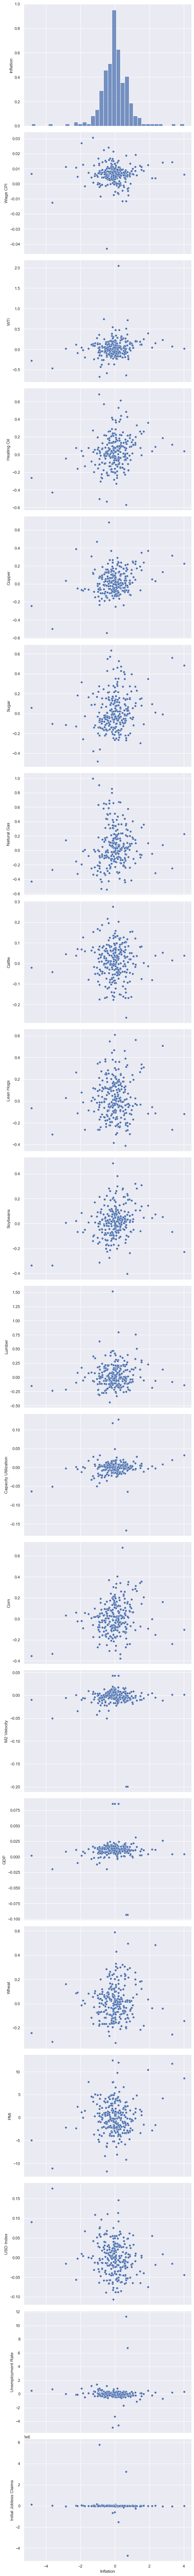

In [3995]:
sns.pairplot(QonQ_main_cpi_past,
            y_vars = ['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','M2 Velocity','GDP','Wheat','PMI',
                     'USD Index','Unemployment Rate','Initial Jobless Claims'],
            x_vars = ['Inflation'],
             height=5, aspect=1.5,
            )

Let's check this out on a histogram

([<matplotlib.axis.XTick at 0x224645e6dc0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

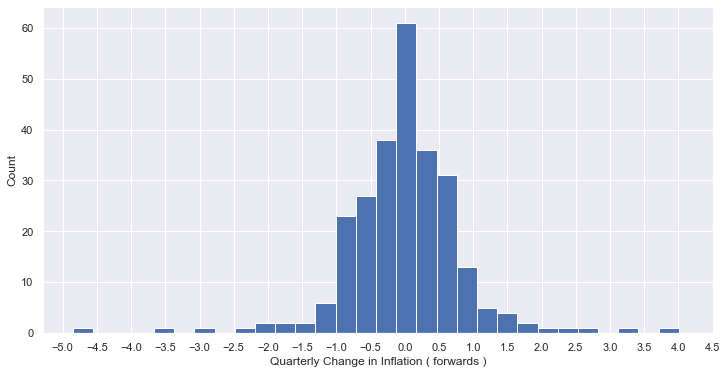

In [3996]:
plt.figure(figsize=(12,6))
plt.hist(QonQ_main_cpi_past['Inflation'], bins=30)
plt.xlabel('Quarterly Change in Inflation ( forwards )')
plt.ylabel('Count')

x_ticks = np.arange(-5, 5, 0.5)
plt.xticks(x_ticks)

Noticeable outliers; let's clean this up by Winsorization.

In [3997]:
# the numbers for the percentile
u_qoq_pf_inf_per = 99
l_qoq_pf_inf_per = 1

# the actual percentile
u_qoq_pf_inf_num = (((u_qoq_pf_inf_per / 100) - 1) * -1)
l_qoq_pf_inf_num = l_qoq_pf_inf_per / 100

# what would result in the dataframe be in the percentiles 
u_qoq_pf_inf_value = np.percentile(QonQ_main_cpi_past['Inflation'], u_qoq_pf_inf_per)
l_qoq_pf_inf_value = np.percentile(QonQ_main_cpi_past['Inflation'], l_qoq_pf_inf_per)

print('The Upper & Lower Quartiles may be:','\n',
    'Upper |',"{:,}%".format(round((u_qoq_pf_inf_value),2)),'\n',
     'Lower |',"{:,}%".format(round((l_qoq_pf_inf_value),2)))


The Upper & Lower Quartiles may be: 
 Upper | 2.51% 
 Lower | -2.49%


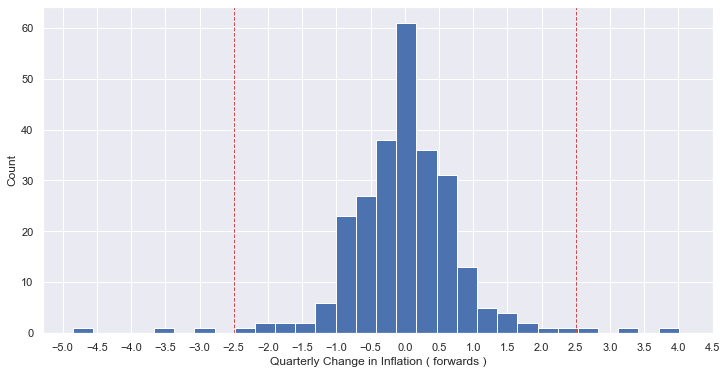

In [3998]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_main_cpi_past['Inflation'], bins=30)
plt.xlabel('Quarterly Change in Inflation ( forwards )')
plt.ylabel('Count')

x_ticks = np.arange(-5, 5, 0.5)
plt.xticks(x_ticks)
plt.axvline(u_qoq_pf_inf_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_qoq_pf_inf_value, color='r', linestyle='dashed', linewidth=1)

In [3999]:
QonQ_main_cpi_past_a = np.count_nonzero(QonQ_main_cpi_past['Inflation']>=u_qoq_pf_inf_value)
QonQ_main_cpi_past_b = np.count_nonzero(QonQ_main_cpi_past['Inflation']<=l_qoq_pf_inf_value)

print('With a dataframe with',len(QonQ_main_cpi_past),'observations, the Winsorization breakdown would be','\n',
     QonQ_main_cpi_past_a,'|', "{:,}%".format(round(((QonQ_main_cpi_past_a/len(QonQ_main_cpi_past))*100),2)),'|','Above',
      '\n',
     QonQ_main_cpi_past_b,'|', "{:,}%".format(round(((QonQ_main_cpi_past_b/len(QonQ_main_cpi_past))*100),2)),'|','Below',
      '\n',
     (QonQ_main_cpi_past_a + QonQ_main_cpi_past_b),'|',
      "{:,}%".format(round((((QonQ_main_cpi_past_a + QonQ_main_cpi_past_b)/len(QonQ_main_cpi_past))*100),2)),'|','in Total')

With a dataframe with 261 observations, the Winsorization breakdown would be 
 3 | 1.15% | Above 
 3 | 1.15% | Below 
 6 | 2.3% | in Total


That's manageable; we will proceed.

In [4000]:
# Winsorize
QonQ_main_cpi_past["Inflation"] = winsorize(QonQ_main_cpi_past["Inflation"], limits=[l_qoq_pf_inf_num, u_qoq_pf_inf_num])

Text(0, 0.5, 'Count')

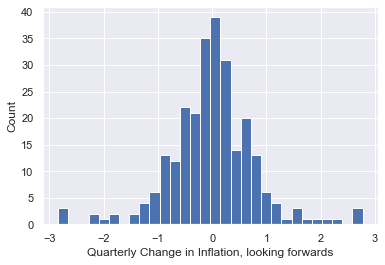

In [4001]:
plt.hist(QonQ_main_cpi_past['Inflation'], bins=30)
plt.xlabel('Quarterly Change in Inflation, looking forwards')
plt.ylabel('Count')


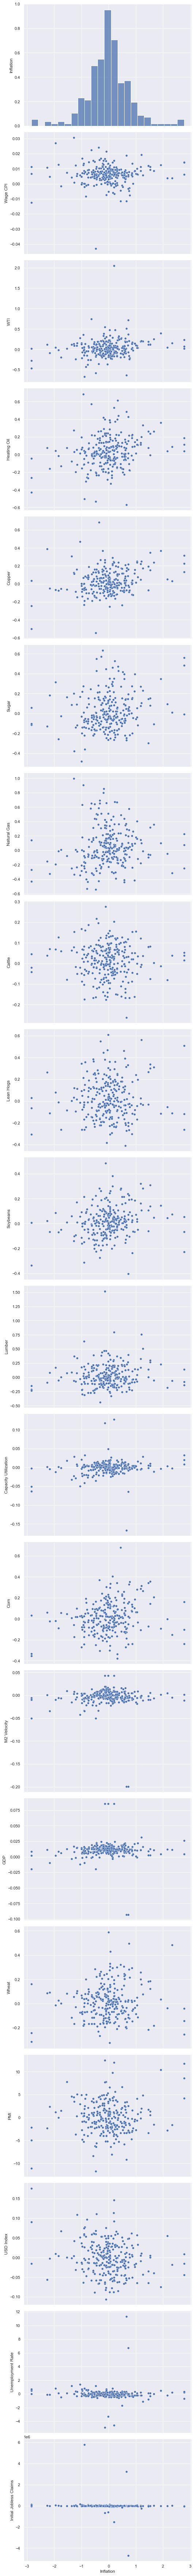

In [4002]:
sns.pairplot(QonQ_main_cpi_past,
            y_vars = ['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','M2 Velocity','GDP','Wheat','PMI',
                     'USD Index','Unemployment Rate','Initial Jobless Claims'],
            x_vars = ['Inflation'],
             height=5, aspect=1.5,
            )

Text(0, 0.5, 'Probability')

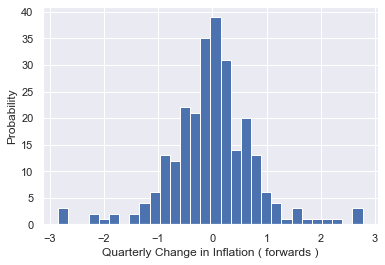

In [4003]:
plt.hist(QonQ_main_cpi_past['Inflation'], bins=30)
plt.xlabel('Quarterly Change in Inflation ( forwards )')
plt.ylabel('Probability')

In [4004]:
QonQ_main_cpi_past.corr(method='pearson')

Inflation  Wage CPI       WTI  Heating Oil    Copper  \
Inflation                1.000000  0.008648  0.199461     0.234855  0.262653   
Wage CPI                 0.008648  1.000000  0.414612     0.505661  0.336077   
WTI                      0.199461  0.414612  1.000000     0.802174  0.429657   
Heating Oil              0.234855  0.505661  0.802174     1.000000  0.420210   
Copper                   0.262653  0.336077  0.429657     0.420210  1.000000   
Sugar                    0.198081  0.189328  0.181202     0.169234  0.254498   
Natural Gas              0.089197  0.305084  0.251183     0.413592  0.086512   
Cattle                  -0.040658  0.199579  0.156316     0.151389  0.116325   
Lean Hogs                0.041595  0.144853  0.138941     0.103899  0.165519   
Soybeans                 0.215658  0.139632  0.154361     0.172629  0.210084   
Lumber                   0.094102  0.125443  0.284352     0.147896  0.220066   
Capacity Utilization     0.150179  0.242810  0.440530     0.374084  0.232589   
Corn                     0.193544  0.087165  0.043940     0.060164  0.120580   
M2 Velocity              0.021786  0.306511  0.185817     0.239897  0.137113   
GDP                      0.051533  0.301383  0.304085     0.261520  0.162802   
Wheat                    0.094922  0.002030 -0.012189     0.002607  0.085733   
PMI                      0.105913  0.236320  0.397585     0.332026  0.464943   
USD Index               -0.207212 -0.288980 -0.268361    -0.307117 -0.346322   
Unemployment Rate       -0.017719 -0.231785 -0.261284    -0.252047 -0.087571   
Initial Jobless Claims  -0.078858 -0.089831 -0.430315    -0.275542 -0.170626   

                           Sugar  Natural Gas    Cattle  Lean Hogs  Soybeans  \
Inflation               0.198081     0.089197 -0.040658   0.041595  0.215658   
Wage CPI                0.189328     0.305084  0.199579   0.144853  0.139632   
WTI                     0.181202     0.251183  0.156316   0.138941  0.154361   
Heating Oil             0.169234     0.413592  0.151389   0.103899  0.172629   
Copper                  0.254498     0.086512  0.116325   0.165519  0.210084   
Sugar                   1.000000     0.151332  0.028021  -0.079794  0.137859   
Natural Gas             0.151332     1.000000  0.014281   0.027053  0.059449   
Cattle                  0.028021     0.014281  1.000000   0.173604  0.088567   
Lean Hogs              -0.079794     0.027053  0.173604   1.000000  0.211359   
Soybeans                0.137859     0.059449  0.088567   0.211359  1.000000   
Lumber                  0.090738    -0.064923  0.188127   0.202990  0.203073   
Capacity Utilization    0.174389     0.121844  0.296844   0.150052  0.135344   
Corn                    0.081171     0.078057  0.031255   0.258810  0.706068   
M2 Velocity             0.111268     0.088463  0.199924   0.120194  0.043261   
GDP                     0.128901     0.102762  0.239489   0.190999  0.067893   
Wheat                   0.088148     0.012473  0.010521   0.039597  0.435295   
PMI                     0.150731     0.034962  0.186446   0.118738  0.148684   
USD Index              -0.140042    -0.240417 -0.049329   0.043220 -0.142777   
Unemployment Rate      -0.119656    -0.065298 -0.286479  -0.132950 -0.067492   
Initial Jobless Claims -0.129504    -0.054066 -0.175435  -0.055848 -0.055722   

                          Lumber  Capacity Utilization      Corn  M2 Velocity  \
Inflation               0.094102              0.150179  0.193544     0.021786   
Wage CPI                0.125443              0.242810  0.087165     0.306511   
WTI                     0.284352              0.440530  0.043940     0.185817   
Heating Oil             0.147896              0.374084  0.060164     0.239897   
Copper                  0.220066              0.232589  0.120580     0.137113   
Sugar                   0.090738              0.174389  0.081171     0.111268   
Natural Gas            -0.064923              0.121844  0.078057     0.088463   
Cattle        

Looks fairly similar to a normal distribution; I will continue as such.

{'whiskers': [<matplotlib.lines.Line2D at 0x22468d8da00>,
 'caps': [<matplotlib.lines.Line2D at 0x22468d99100>,
 'boxes': [<matplotlib.lines.Line2D at 0x22468d8d670>],
 'medians': [<matplotlib.lines.Line2D at 0x22468d997c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x22468d99b20>],
 'means': []}

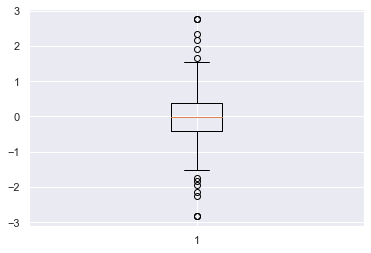

In [4005]:
plt.boxplot(QonQ_main_cpi_past['Inflation'])

## 2.7.3 Quarterly Changes | Variables ( past ) & Inflation ( forwards ) | Pearson<a id='q_pf_pearson'></a>

Text(0.5, 1.0, 'Inflation ( 1 Quarter Forwards ) vs. Variables ( 1 Quarter Backwards)')

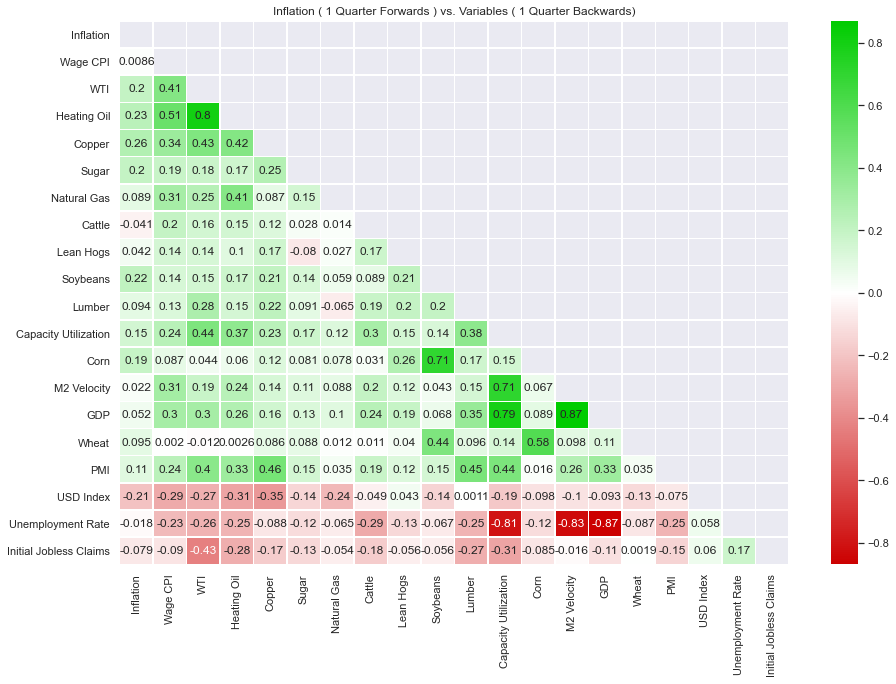

In [4006]:
plt.subplots(figsize=(15,10))
matrix = np.triu(QonQ_main_cpi_past.corr())
sns.heatmap(QonQ_main_cpi_past.corr(), mask=matrix, linewidths=.5, cmap=GnRd, annot=True)
plt.title('Inflation ( 1 Quarter Forwards ) vs. Variables ( 1 Quarter Backwards)')

In [4007]:
# looking at the average pearson coefficient
q_q_pf = QonQ_main_cpi_past.corr(method='pearson')
q_q_pf = pd.DataFrame(q_q_pf['Inflation'])
q_q_pf = q_q_pf.iloc[1: , :]
q_q_pf['AbsAmount'] = q_q_pf['Inflation'].abs()
q_q_pf_av = q_q_pf['AbsAmount'].mean()


In [4008]:
QonQ_main_cpi_past = QonQ_main_cpi_past.sort_values(by="Date", ascending=True)
QonQ_main_cpi_past_csv = pd.DataFrame(QonQ_main_cpi_past)

QonQ_main_cpi_past_csv.to_excel('./_Inflation_Capstone/data/1.0_Segmented_by_periods/QonQ_main_cpi_past.xlsx')
print('Finished')

Finished


##  2.8 Q on Q Comparison w/ Rolling Averages on Daily, Wkly & Mnthly Variables ( w/ Inflation Scraping & no variable scraping )<a id='rolling'></a>

**This dataframe is being constructed a similar way 2.5 was created with the exception that the daily, weekly & monthly variables are taking a rolling average.** The rational with this interest is based on the idea that one of the variables would have had a bad day / week at the end of the term. If so, they may not properly display the impact they may have on inflation.

In [4009]:
# ( Complete ) Daily | USD & WTI | removed 24 days from 90 ( i.e. weekends ) but doesn't include holidays
Q_usd_index_roll = Q_usd_index.rolling(66).mean()
Q_wti_roll = Q_wti.rolling(66).mean()

Q_copper_roll = Q_copper.rolling(66).mean()
Q_soybeans_roll = Q_soybeans.rolling(66).mean()
Q_natgas_roll = Q_natgas.rolling(66).mean()
Q_heatoil_roll = Q_heatoil.rolling(66).mean()
Q_corn_roll = Q_corn.rolling(66).mean()
Q_wheat_roll = Q_wheat.rolling(66).mean()
Q_cattle_roll = Q_cattle.rolling(66).mean()
Q_sugar_roll = Q_sugar.rolling(66).mean()
Q_lumber_roll = Q_lumber.rolling(66).mean()
Q_leanhogs_roll = Q_leanhogs.rolling(66).mean()

# ( Complete ) Weekly | Initial Jobless Claims
Q_intjobs_roll = Q_intjobs.rolling(12).mean()

# ( Complete ) Mnthly | Capacity Utilization, Wages, Inflation
Q_caputil_roll = Q_caputil.rolling(3).mean()
Q_wages_roll = Q_wages.rolling(3).mean()
Q_unrate_roll = Q_unrate.rolling(3).mean()
Q_comppmi_roll =Q_comppmi.rolling(3).mean()

Q_cpi = cpi.diff(periods=3)

# ( Complete ) Quarterly | GDP, Velocity of Money
Q_gdp = gdp.pct_change(periods=1)
Q_m2_velo = m2_velo.pct_change(periods=1)

In [4010]:
# Building out the variables first with a roll & forward fill
QonQ_vars_roll = pd.concat([Q_wages_roll,Q_wti_roll,Q_heatoil_roll,Q_copper_roll,Q_sugar_roll,
                            Q_natgas_roll,Q_cattle_roll,Q_leanhogs_roll,Q_soybeans_roll,Q_lumber_roll,
                            Q_caputil_roll,Q_corn_roll,Q_m2_velo,Q_gdp,Q_wheat_roll,Q_comppmi_roll,
                            Q_usd_index_roll,Q_unrate_roll,Q_intjobs_roll],
                      axis = 1, ignore_index=False)

QonQ_vars_roll.columns= ['Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','M2 Velocity','GDP','Wheat','PMI',
                     'USD Index','Unemployment Rate','Initial Jobless Claims'
                   ]

QonQ_vars_roll.index.names = ["Date"]
QonQ_vars_roll = QonQ_vars_roll.fillna(method='ffill')

# vars_mnth.tail()

In [4011]:
QonQ_vars_roll.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14302 entries, 1946-01-01 to 2021-09-03
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wage CPI                14293 non-null  float64
 1   WTI                     12088 non-null  float64
 2   Heating Oil             13087 non-null  float64
 3   Copper                  10440 non-null  float64
 4   Sugar                   13087 non-null  float64
 5   Natural Gas             9915 non-null   float64
 6   Cattle                  13084 non-null  float64
 7   Lean Hogs               13089 non-null  float64
 8   Soybeans                9999 non-null   float64
 9   Lumber                  13089 non-null  float64
 10  Capacity Utilization    14033 non-null  float64
 11  Corn                    13086 non-null  float64
 12  M2 Velocity             14151 non-null  float64
 13  GDP                     14295 non-null  float64
 14  Wheat                

In [4012]:
# As before, working backwards off of Natural Gas to bring the data together
# QonQ_vars_roll['Natural Gas'].tail(9565)

QonQ_vars_roll = QonQ_vars_roll.loc['1991-04-18':today_y_m_d_dash]

In [4013]:
QonQ_vars_roll.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9752 entries, 1991-04-18 to 2021-09-03
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Wage CPI                9752 non-null   float64
 1   WTI                     9752 non-null   float64
 2   Heating Oil             9752 non-null   float64
 3   Copper                  9752 non-null   float64
 4   Sugar                   9752 non-null   float64
 5   Natural Gas             9752 non-null   float64
 6   Cattle                  9752 non-null   float64
 7   Lean Hogs               9752 non-null   float64
 8   Soybeans                9752 non-null   float64
 9   Lumber                  9752 non-null   float64
 10  Capacity Utilization    9752 non-null   float64
 11  Corn                    9752 non-null   float64
 12  M2 Velocity             9752 non-null   float64
 13  GDP                     9752 non-null   float64
 14  Wheat                 

In [4014]:
QonQ_vars_roll = QonQ_vars_roll.sort_values(by="Date", ascending=False)
QonQ_vars_roll_csv = pd.DataFrame(QonQ_vars_roll)

QonQ_vars_roll_csv.to_excel('./_Inflation_Capstone/data/1.0_Segmented_by_periods/QonQ_roll_wout_CPImerge.xlsx')
print('Finished')

Finished


In [4015]:
QonQ_vars_roll.describe()

Wage CPI          WTI  Heating Oil       Copper        Sugar  \
count  9752.000000  9752.000000  9752.000000  9752.000000  9752.000000   
mean      0.005736     0.027185     0.024068     0.021811     0.019902   
std       0.005969     0.152706     0.138250     0.119340     0.144612   
min      -0.034864    -0.539073    -0.462821    -0.505766    -0.393969   
25%       0.003979    -0.057289    -0.047060    -0.052394    -0.077954   
50%       0.006402     0.032678     0.022382     0.008907    -0.005334   
75%       0.008293     0.117444     0.110680     0.091639     0.101036   
max       0.023646     0.619696     0.388113     0.530210     0.610680   

       Natural Gas       Cattle    Lean Hogs     Soybeans       Lumber  \
count  9752.000000  9752.000000  9752.000000  9752.000000  9752.000000   
mean      0.035621     0.007883     0.023240     0.015413     0.035858   
std       0.194337     0.066845     0.145421     0.100766     0.164186   
min      -0.398806    -0.215529    -0.331947    -0.359508    -0.379919   
25%      -0.091737    -0.036773    -0.076621    -0.041561    -0.070437   
50%       0.010952     0.013329     0.012237     0.011476     0.021719   
75%       0.165141     0.055351     0.122944     0.070711     0.122528   
max       0.646182     0.256356     0.476227     0.293121     0.933175   

       Capacity Utilization         Corn  M2 Velocity          GDP  \
count           9752.000000  9752.000000  9752.000000  9752.000000   
mean              -0.000107     0.019170    -0.004085     0.011197   
std                0.017879     0.123363     0.022277     0.014213   
min               -0.127837    -0.340215    -0.199418    -0.093287   
25%               -0.005030    -0.051556    -0.007308     0.008607   
50%                0.001483     0.009191    -0.001716     0.011900   
75%                0.006937     0.084070     0.004639     0.015786   
max                0.098203     0.480516     0.042727     0.085285   

             Wheat          PMI    USD Index  Unemployment Rate  \
count  9752.000000  9752.000000  9752.000000        9752.000000   
mean      0.017091     0.169524     0.001494          -0.004488   
std       0.108521     2.995884     0.035053           0.868335   
min      -0.303035   -11.833333    -0.078002          -4.266667   
25%      -0.054448    -1.700000    -0.023174          -0.200000   
50%       0.010126     0.000000     0.001376          -0.100000   
75%       0.076934     1.841667     0.022262           0.066667   
max       0.444586    10.666667     0.120729           9.266667   

       Initial Jobless Claims  
count            9.752000e+03  
mean            -2.622539e+01  
std              2.749160e+05  
min             -2.113167e+06  
25%             -1.191667e+04  
50%             -3.583333e+03  
75%              5.166667e+03  
max              3.105333e+06

In [4016]:
# Putting them together with inflation
QonQ_main_roll = Q_cpi.merge(QonQ_vars_roll, how='left', on='Date')

# QonQ_main_roll = QonQ_main_roll[Q_cpi.index.dayofweek < 5]

QonQ_main_roll.columns = ['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','M2 Velocity','GDP','Wheat','PMI',
                     'USD Index','Unemployment Rate','Initial Jobless Claims']

QonQ_main_roll = QonQ_main_roll.dropna()

In [4017]:
QonQ_main_roll.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 321 entries, 1991-04-30 to 2021-07-31
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Inflation               321 non-null    float64
 1   Wage CPI                321 non-null    float64
 2   WTI                     321 non-null    float64
 3   Heating Oil             321 non-null    float64
 4   Copper                  321 non-null    float64
 5   Sugar                   321 non-null    float64
 6   Natural Gas             321 non-null    float64
 7   Cattle                  321 non-null    float64
 8   Lean Hogs               321 non-null    float64
 9   Soybeans                321 non-null    float64
 10  Lumber                  321 non-null    float64
 11  Capacity Utilization    321 non-null    float64
 12  Corn                    321 non-null    float64
 13  M2 Velocity             321 non-null    float64
 14  GDP                    

## 2.8.2 Cleaning Q on Q Comparison w/ Rolling Averages<a id='rolling_clean'></a>

In [4018]:
QonQ_main_roll.corr(method='pearson')

Inflation  Wage CPI       WTI  Heating Oil    Copper  \
Inflation                1.000000  0.595358  0.540347     0.542445  0.372813   
Wage CPI                 0.595358  1.000000  0.711271     0.725743  0.517990   
WTI                      0.540347  0.711271  1.000000     0.907525  0.572057   
Heating Oil              0.542445  0.725743  0.907525     1.000000  0.550684   
Copper                   0.372813  0.517990  0.572057     0.550684  1.000000   
Sugar                    0.219235  0.232025  0.224900     0.265150  0.299395   
Natural Gas              0.289579  0.398030  0.340139     0.461199  0.170079   
Cattle                   0.162077  0.249568  0.178526     0.233310  0.127142   
Lean Hogs                0.291943  0.296192  0.323611     0.201871  0.215793   
Soybeans                 0.199634  0.250109  0.286400     0.257833  0.268939   
Lumber                   0.255493  0.238664  0.357568     0.243150  0.253336   
Capacity Utilization     0.349075  0.399539  0.495389     0.477165  0.336573   
Corn                     0.293481  0.246192  0.164411     0.156077  0.171532   
M2 Velocity              0.281344  0.335991  0.425799     0.390383  0.265222   
GDP                      0.343129  0.336609  0.487894     0.408146  0.267596   
Wheat                    0.125293  0.144276  0.049868     0.068688  0.155670   
PMI                      0.223222  0.320950  0.482193     0.383965  0.463192   
USD Index               -0.307158 -0.383304 -0.408671    -0.402501 -0.413288   
Unemployment Rate       -0.215974 -0.303951 -0.332687    -0.330504 -0.153170   
Initial Jobless Claims  -0.272464 -0.226721 -0.433206    -0.332311 -0.192797   

                           Sugar  Natural Gas    Cattle  Lean Hogs  Soybeans  \
Inflation               0.219235     0.289579  0.162077   0.291943  0.199634   
Wage CPI                0.232025     0.398030  0.249568   0.296192  0.250109   
WTI                     0.224900     0.340139  0.178526   0.323611  0.286400   
Heating Oil             0.265150     0.461199  0.233310   0.201871  0.257833   
Copper                  0.299395     0.170079  0.127142   0.215793  0.268939   
Sugar                   1.000000     0.234116  0.099031  -0.109234  0.149229   
Natural Gas             0.234116     1.000000  0.140962   0.086910  0.097459   
Cattle                  0.099031     0.140962  1.000000   0.135960  0.083687   
Lean Hogs              -0.109234     0.086910  0.135960   1.000000  0.232522   
Soybeans                0.149229     0.097459  0.083687   0.232522  1.000000   
Lumber                  0.048953    -0.064291  0.259605   0.304108  0.235838   
Capacity Utilization    0.170191     0.255544  0.365794   0.184867  0.168027   
Corn                    0.101551     0.108413  0.076798   0.248014  0.727726   
M2 Velocity             0.126922     0.145839  0.265988   0.120134  0.070406   
GDP                     0.091278     0.143606  0.259918   0.179888  0.103825   
Wheat                   0.087425     0.035037  0.059626  -0.085270  0.459035   
PMI                     0.127598     0.049954  0.197677   0.158024  0.177084   
USD Index              -0.162864    -0.236789 -0.080543  -0.010782 -0.275479   
Unemployment Rate      -0.132256    -0.163262 -0.358740  -0.175335 -0.129275   
Initial Jobless Claims -0.125677    -0.130046 -0.258990  -0.111882 -0.102582   

                          Lumber  Capacity Utilization      Corn  M2 Velocity  \
Inflation               0.255493              0.349075  0.293481     0.281344   
Wage CPI                0.238664              0.399539  0.246192     0.335991   
WTI                     0.357568              0.495389  0.164411     0.425799   
Heating Oil             0.243150              0.477165  0.156077     0.390383   
Copper                  0.253336              0.336573  0.171532     0.265222   
Sugar                   0.048953              0.170191  0.101551     0.126922   
Natural Gas            -0.064291              0.255544  0.108413     0.145839   
Cattle        

Text(0.5, 1.0, 'Quarter on Quarter Comparison ( with Rolling Averages on Daily & Weekly Variables )')

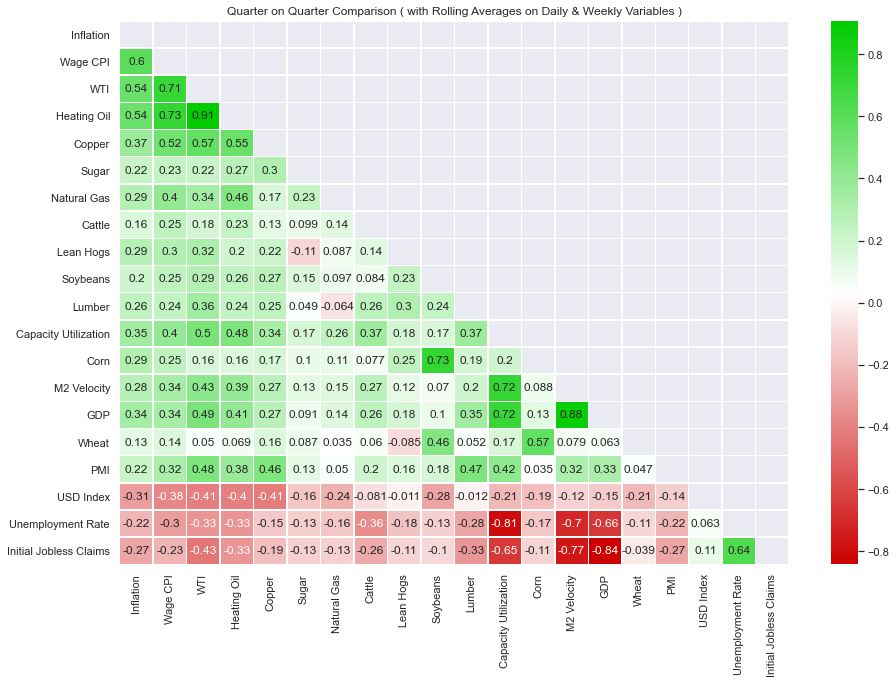

In [4019]:
plt.subplots(figsize=(15,10))
matrix = np.triu(QonQ_main_roll.corr())
sns.heatmap(QonQ_main_roll.corr(), mask=matrix, linewidths=.5, cmap=GnRd, annot=True)
plt.title('Quarter on Quarter Comparison ( with Rolling Averages on Daily & Weekly Variables )')

In [4020]:
QonQ_main_roll_side = QonQ_main_roll.copy()

In [4021]:
# looking at the average pearson coefficient
q_q_roll_bf = QonQ_main_roll.corr(method='pearson')
q_q_roll_bf = pd.DataFrame(q_q_roll_bf['Inflation'])
q_q_roll_bf = q_q_roll_bf.iloc[1: , :]
q_q_roll_bf['AbsAmount'] = q_q_roll_bf['Inflation'].abs()
q_q_roll_bf_av = q_q_roll_bf['AbsAmount'].mean()

In [4022]:
df = QonQ_main_roll.sort_values(by="Date", ascending=False)
df_csv = pd.DataFrame(QonQ_main_roll)

df_csv.to_csv('./_Inflation_Capstone/data/1.0_MAIN/inflation_df.csv')
print('finished')


finished


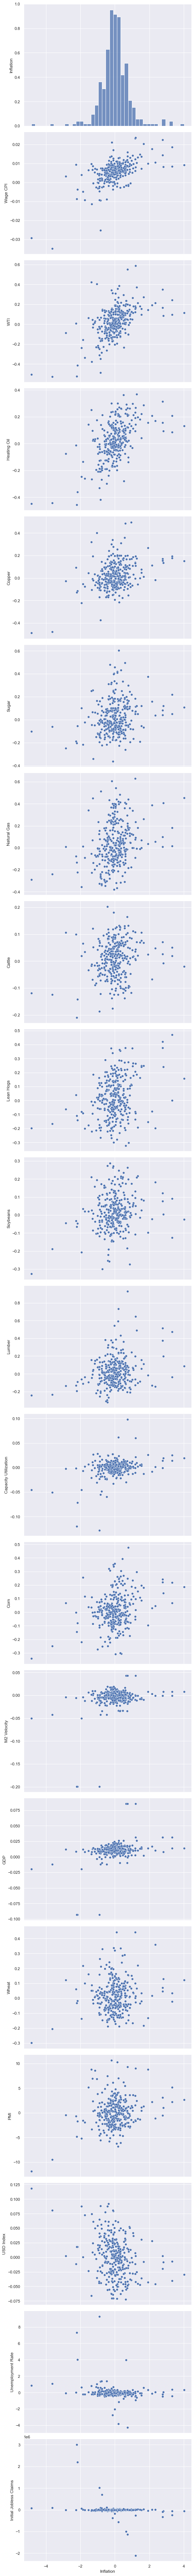

In [4023]:
sns.pairplot(QonQ_main_roll,
            y_vars=['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','M2 Velocity','GDP','Wheat','PMI',
                     'USD Index','Unemployment Rate','Initial Jobless Claims'],
            x_vars=['Inflation'],
            height=5, aspect=1.5,)

In [4024]:
QonQ_main_roll = QonQ_main_roll.sort_values(by="Date", ascending=False)
QonQ_main_roll_csv = pd.DataFrame(QonQ_main_roll)

QonQ_main_roll_csv.to_excel('./_Inflation_Capstone/data/1.0_Segmented_by_periods/QonQ_roll_wCPI_merge.xlsx')
print('Finished')

Finished


([<matplotlib.axis.XTick at 0x22423082d00>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

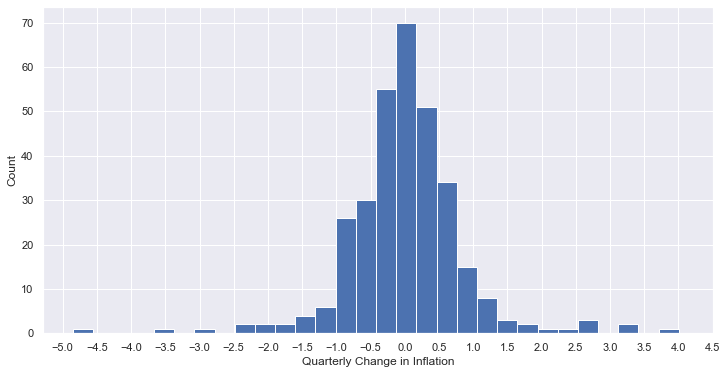

In [4025]:
plt.figure(figsize=(12,6))
plt.hist(QonQ_main_roll['Inflation'], bins=30)
plt.xlabel('Quarterly Change in Inflation')
plt.ylabel('Count')

x_ticks = np.arange(-5, 5, 0.5)
plt.xticks(x_ticks)


Let's clean this up by Winsorization.

In [4026]:
# the numbers for the percentile
u_qoq_r_inf_per = 99.18
l_qoq_r_inf_per = 0.56

# the actual percentile
u_qoq_r_inf_num = (((u_qoq_r_inf_per / 100) - 1) * -1)
l_qoq_r_inf_num = l_qoq_r_inf_per / 100

# what would result in the dataframe be in the percentiles 
u_qoq_r_inf_value = np.percentile(QonQ_main_roll['Inflation'], u_qoq_r_inf_per)
l_qoq_r_inf_value = np.percentile(QonQ_main_roll['Inflation'], l_qoq_r_inf_per)

print('The Upper & Lower Quartiles may be:','\n',
    'Upper |',"{:,}%".format(round((u_qoq_r_inf_value),2)),'\n',
     'Lower |',"{:,}%".format(round((l_qoq_r_inf_value),2)))


The Upper & Lower Quartiles may be: 
 Upper | 3.0% 
 Lower | -3.0%


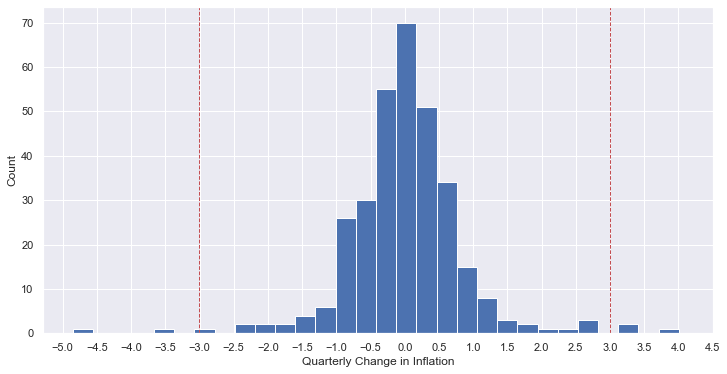

In [4027]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_main_roll['Inflation'], bins=30)
plt.xlabel('Quarterly Change in Inflation')
plt.ylabel('Count')

x_ticks = np.arange(-5, 5, 0.5)
plt.xticks(x_ticks)
plt.axvline(u_qoq_r_inf_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_qoq_r_inf_value, color='r', linestyle='dashed', linewidth=1)

In [4028]:
QonQ_main_roll_a = np.count_nonzero(QonQ_main_roll['Inflation']>=u_qoq_r_inf_value)
QonQ_main_roll_b = np.count_nonzero(QonQ_main_roll['Inflation']<=l_qoq_r_inf_value)

print('With a dataframe with',len(QonQ_main_roll),'observations, the Winsorization breakdown would be','\n',
     QonQ_main_roll_a,'|', "{:,}%".format(round(((QonQ_main_roll_a/len(QonQ_main_roll))*100),1)),'|','Above','\n',
     QonQ_main_roll_b,'|', "{:,}%".format(round(((QonQ_main_roll_b/len(QonQ_main_roll))*100),1)),'|','Below','\n',
     (QonQ_main_roll_a + QonQ_main_roll_b),'|',
      "{:,}%".format(round((((QonQ_main_roll_a + QonQ_main_roll_b)/len(QonQ_main_roll))*100),1)),'|','in Total')

With a dataframe with 321 observations, the Winsorization breakdown would be 
 3 | 0.9% | Above 
 2 | 0.6% | Below 
 5 | 1.6% | in Total


Visually, ±3% looks reasonable; let's see how many observations present themselves.

In [4029]:
QonQ_main_roll_plus = np.count_nonzero(QonQ_main_roll['Inflation']>3)
QonQ_main_roll_minus = np.count_nonzero(QonQ_main_roll['Inflation']<=-3)

print((QonQ_main_roll_plus+QonQ_main_roll_minus),'|',
      "{:,}%".format(round((((QonQ_main_roll_plus + QonQ_main_roll_minus)/len(QonQ_main_roll))*100),1)),
      '| Observations ±3%')

5 | 1.6% | Observations ±3%


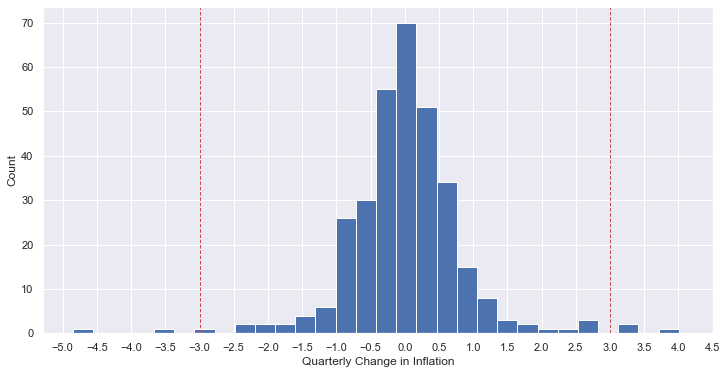

In [4030]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_main_roll['Inflation'], bins=30)
plt.xlabel('Quarterly Change in Inflation')
plt.ylabel('Count')

x_ticks = np.arange(-5, 5, 0.5)
plt.xticks(x_ticks)
plt.axvline(3, color='r', linestyle='dashed', linewidth=1)
plt.axvline(-3, color='r', linestyle='dashed', linewidth=1)

In [4031]:
# the numbers for the percentile
u_qoq_r_inf_per_rev = 99.18
l_qoq_r_inf_per_rev = 0.56

# the actual percentile
u_qoq_r_inf_num_rev = (((u_qoq_r_inf_per_rev / 100) - 1) * -1)
l_qoq_r_inf_num_rev = l_qoq_r_inf_per_rev / 100

# what would result in the dataframe be in the percentiles 
u_qoq_r_inf_value_rev = np.percentile(QonQ_main_roll['Inflation'], u_qoq_r_inf_per_rev)
l_qoq_r_inf_value_rev = np.percentile(QonQ_main_roll['Inflation'], l_qoq_r_inf_per_rev)

print('The Upper & Lower Quartiles may be:','\n',
    'Upper |',"{:,}%".format(round((u_qoq_r_inf_value_rev),2)),'\n',
     'Lower |',"{:,}%".format(round((l_qoq_r_inf_value_rev),2)))


The Upper & Lower Quartiles may be: 
 Upper | 3.0% 
 Lower | -3.0%


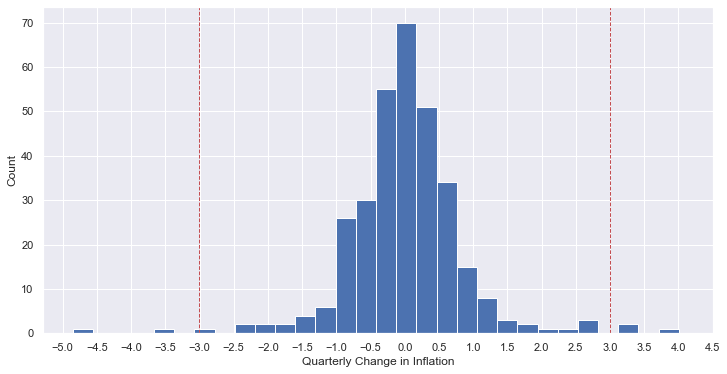

In [4032]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_main_roll['Inflation'], bins=30)
plt.xlabel('Quarterly Change in Inflation')
plt.ylabel('Count')

x_ticks = np.arange(-5, 5, 0.5)
plt.xticks(x_ticks)
plt.axvline(u_qoq_r_inf_value_rev, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_qoq_r_inf_value_rev, color='r', linestyle='dashed', linewidth=1)

In [4033]:
QonQ_main_roll_plus_r = np.count_nonzero(QonQ_main_roll['Inflation']>u_qoq_r_inf_value_rev)
QonQ_main_roll_minus_r = np.count_nonzero(QonQ_main_roll['Inflation']<=l_qoq_r_inf_value_rev)

print((QonQ_main_roll_plus_r+QonQ_main_roll_minus_r),'|',
      "{:,}%".format(round((((QonQ_main_roll_plus_r + QonQ_main_roll_minus_r)/len(QonQ_main_roll))*100),1)),
      '| Observations on new structure')

5 | 1.6% | Observations on new structure


That's manageable; we will proceed.

In [4034]:
# Winsorize
QonQ_main_roll["Inflation"] = winsorize(QonQ_main_roll["Inflation"], limits=[l_qoq_r_inf_num_rev, u_qoq_r_inf_num_rev])

Text(0, 0.5, 'Count')

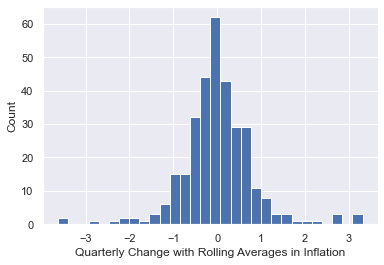

In [4035]:
plt.hist(QonQ_main_roll['Inflation'], bins=30)
plt.xlabel('Quarterly Change with Rolling Averages in Inflation')
plt.ylabel('Count')

That does not appear to have worked; let's manually do it.

In [4036]:
QonQ_main_roll.loc[QonQ_main_roll['Inflation'] > 4, 'Inflation'] = 4
QonQ_main_roll.loc[QonQ_main_roll['Inflation'] < -4, 'Inflation'] = -4

Text(0, 0.5, 'Count')

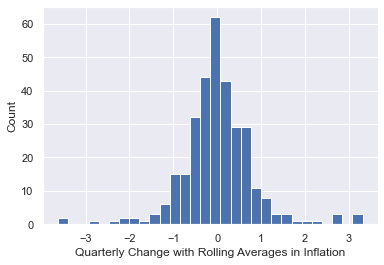

In [4037]:
plt.hist(QonQ_main_roll['Inflation'], bins=30)
plt.xlabel('Quarterly Change with Rolling Averages in Inflation')
plt.ylabel('Count')

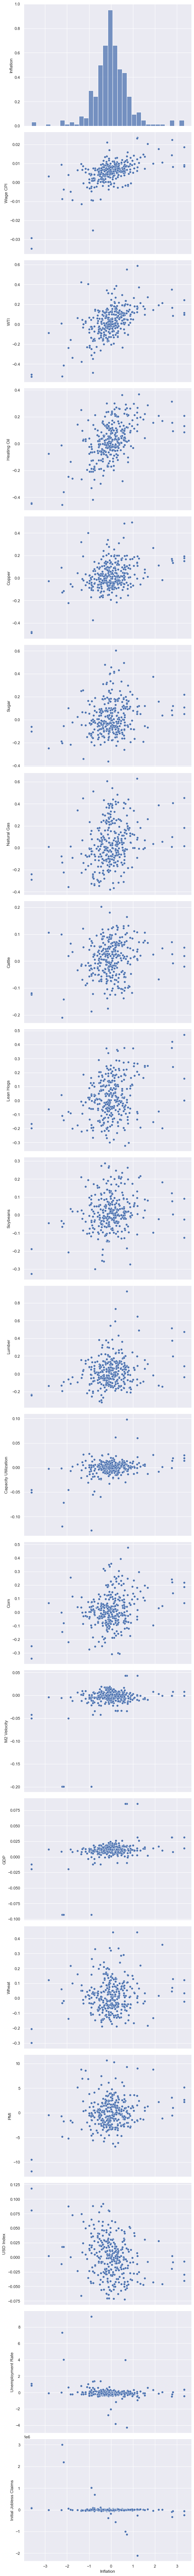

In [4038]:
sns.pairplot(QonQ_main_roll,
            y_vars = ['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','M2 Velocity','GDP','Wheat','PMI',
                     'USD Index','Unemployment Rate','Initial Jobless Claims'],
            x_vars = ['Inflation'],
             height=5, aspect=1.5,
            )

{'whiskers': [<matplotlib.lines.Line2D at 0x2246c969c40>,
 'caps': [<matplotlib.lines.Line2D at 0x2246c978340>,
 'boxes': [<matplotlib.lines.Line2D at 0x2246c9698e0>],
 'medians': [<matplotlib.lines.Line2D at 0x2246c978a00>],
 'fliers': [<matplotlib.lines.Line2D at 0x2246c978d00>],
 'means': []}

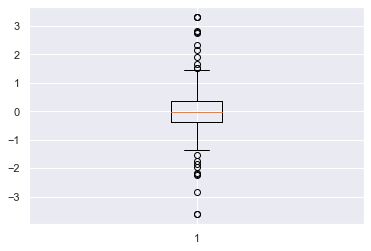

In [4039]:
plt.boxplot(QonQ_main_roll['Inflation'])

## 2.8.3 Q on Q Comparison w/ Rolling Averages Pearson<a id='rolling_pearson'></a>

In [4040]:
QonQ_main_roll.corr(method='pearson')

Inflation  Wage CPI       WTI  Heating Oil    Copper  \
Inflation                1.000000  0.587224  0.541055     0.543237  0.363120   
Wage CPI                 0.587224  1.000000  0.711271     0.725743  0.517990   
WTI                      0.541055  0.711271  1.000000     0.907525  0.572057   
Heating Oil              0.543237  0.725743  0.907525     1.000000  0.550684   
Copper                   0.363120  0.517990  0.572057     0.550684  1.000000   
Sugar                    0.221181  0.232025  0.224900     0.265150  0.299395   
Natural Gas              0.286229  0.398030  0.340139     0.461199  0.170079   
Cattle                   0.159910  0.249568  0.178526     0.233310  0.127142   
Lean Hogs                0.292454  0.296192  0.323611     0.201871  0.215793   
Soybeans                 0.191792  0.250109  0.286400     0.257833  0.268939   
Lumber                   0.255531  0.238664  0.357568     0.243150  0.253336   
Capacity Utilization     0.346349  0.399539  0.495389     0.477165  0.336573   
Corn                     0.286714  0.246192  0.164411     0.156077  0.171532   
M2 Velocity              0.279930  0.335991  0.425799     0.390383  0.265222   
GDP                      0.344224  0.336609  0.487894     0.408146  0.267596   
Wheat                    0.113850  0.144276  0.049868     0.068688  0.155670   
PMI                      0.210191  0.320950  0.482193     0.383965  0.463192   
USD Index               -0.299621 -0.383304 -0.408671    -0.402501 -0.413288   
Unemployment Rate       -0.219548 -0.303951 -0.332687    -0.330504 -0.153170   
Initial Jobless Claims  -0.279706 -0.226721 -0.433206    -0.332311 -0.192797   

                           Sugar  Natural Gas    Cattle  Lean Hogs  Soybeans  \
Inflation               0.221181     0.286229  0.159910   0.292454  0.191792   
Wage CPI                0.232025     0.398030  0.249568   0.296192  0.250109   
WTI                     0.224900     0.340139  0.178526   0.323611  0.286400   
Heating Oil             0.265150     0.461199  0.233310   0.201871  0.257833   
Copper                  0.299395     0.170079  0.127142   0.215793  0.268939   
Sugar                   1.000000     0.234116  0.099031  -0.109234  0.149229   
Natural Gas             0.234116     1.000000  0.140962   0.086910  0.097459   
Cattle                  0.099031     0.140962  1.000000   0.135960  0.083687   
Lean Hogs              -0.109234     0.086910  0.135960   1.000000  0.232522   
Soybeans                0.149229     0.097459  0.083687   0.232522  1.000000   
Lumber                  0.048953    -0.064291  0.259605   0.304108  0.235838   
Capacity Utilization    0.170191     0.255544  0.365794   0.184867  0.168027   
Corn                    0.101551     0.108413  0.076798   0.248014  0.727726   
M2 Velocity             0.126922     0.145839  0.265988   0.120134  0.070406   
GDP                     0.091278     0.143606  0.259918   0.179888  0.103825   
Wheat                   0.087425     0.035037  0.059626  -0.085270  0.459035   
PMI                     0.127598     0.049954  0.197677   0.158024  0.177084   
USD Index              -0.162864    -0.236789 -0.080543  -0.010782 -0.275479   
Unemployment Rate      -0.132256    -0.163262 -0.358740  -0.175335 -0.129275   
Initial Jobless Claims -0.125677    -0.130046 -0.258990  -0.111882 -0.102582   

                          Lumber  Capacity Utilization      Corn  M2 Velocity  \
Inflation               0.255531              0.346349  0.286714     0.279930   
Wage CPI                0.238664              0.399539  0.246192     0.335991   
WTI                     0.357568              0.495389  0.164411     0.425799   
Heating Oil             0.243150              0.477165  0.156077     0.390383   
Copper                  0.253336              0.336573  0.171532     0.265222   
Sugar                   0.048953              0.170191  0.101551     0.126922   
Natural Gas            -0.064291              0.255544  0.108413     0.145839   
Cattle        

Text(0.5, 1.0, 'Quarter on Quarter Comparison ( with Rolling Averages on Daily, Weekly & Monthly Data )')

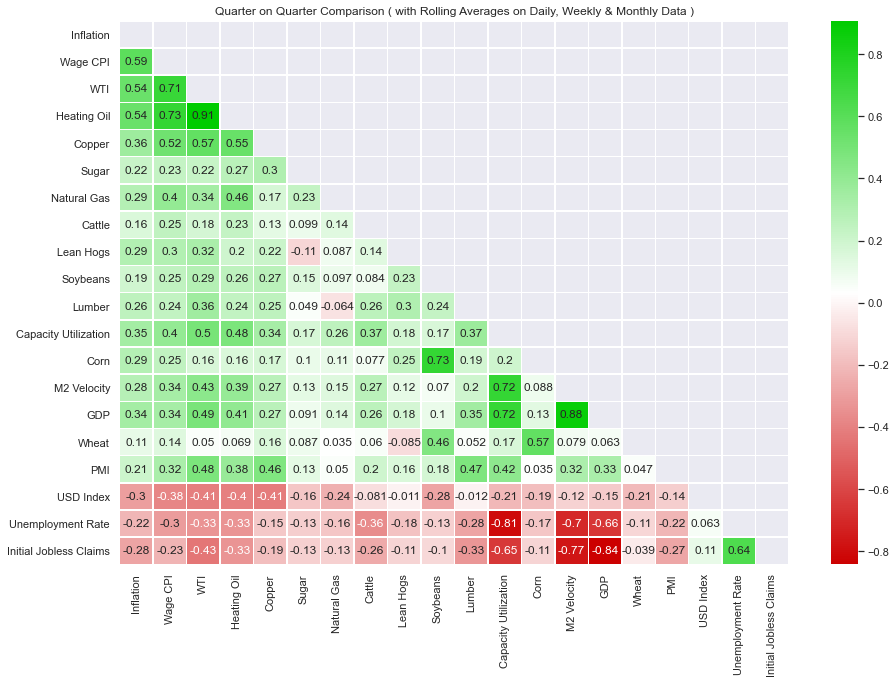

In [4041]:
plt.subplots(figsize=(15,10))
matrix = np.triu(QonQ_main_roll.corr())
sns.heatmap(QonQ_main_roll.corr(), mask=matrix, linewidths=.5, cmap=GnRd, annot=True)
plt.title('Quarter on Quarter Comparison ( with Rolling Averages on Daily, Weekly & Monthly Data )')

In [4042]:
# looking at the average pearson coefficient
q_q_roll = QonQ_main_roll.corr(method='pearson')
q_q_roll = pd.DataFrame(q_q_roll['Inflation'])
q_q_roll = q_q_roll.iloc[1: , :]
q_q_roll['AbsAmount'] = q_q_roll['Inflation'].abs()
q_q_roll_av = q_q_roll['AbsAmount'].mean()

In [4043]:
QonQ_main_roll = QonQ_main_roll.sort_values(by="Date", ascending=False)
QonQ_main_roll_csv = pd.DataFrame(QonQ_main_roll)

QonQ_main_roll_csv.to_excel('./_Inflation_Capstone/data/1.0_Segmented_by_periods/QonQ_main_roll.xlsx')
print('Finished')

Finished


## 2.9 Project Initial Summary<a id='p_initial_summary'></a>

After review of various structures, I believe **the best Pearson Coefficient is with the Quarter on Quarter change with the rolling averages of the variables**. Let's take a look.

In [4044]:
print('The Average Pearson coefficients below:','\n','\n',
     "{:,}%".format(round((q_q_main_av*100),2)),'| Quarter on Quarter','\n', 
     "{:,}%".format(round((m_m_main_av*100),2)),'| Month on Month','\n',
     "{:,}%".format(round((q_q_pf_av*100),2)),' | Quarterly Changes | Variables ( past ) & Inflation ( forwards )','\n',
     "{:,}%".format(round((q_q_roll_av*100),2)),' | Quarter on Quarter with Rolling Averages','\n',)

The Average Pearson coefficients below: 
 
 22.7% | Quarter on Quarter 
 18.22% | Month on Month 
 12.14%  | Quarterly Changes | Variables ( past ) & Inflation ( forwards ) 
 30.64%  | Quarter on Quarter with Rolling Averages 



**Confirmed.** In short, there's an understand that rolling the variables produce better results. An interesting observation may be that Winsorization on `Inflation` is not required. Let's add in what Pearson score the Quarter on Quarter with Rolling Averages had before Winsorization.

In [4045]:
print('The Average Pearson coefficients below:','\n','\n',
     "{:,}%".format(round((q_q_main_av*100),2)),'| Quarter on Quarter','\n', 
     "{:,}%".format(round((m_m_main_av*100),2)),'| Month on Month','\n',
     "{:,}%".format(round((q_q_pf_av*100),2)),' | Quarterly Changes | Variables ( past ) & Inflation ( forwards )','\n',
     "{:,}%".format(round((q_q_roll_av*100),2)),' | Quarter on Quarter with Rolling Averages','\n','\n',
     "{:,}%".format(round((q_q_roll_bf_av*100),2)),' | Quarter on Quarter with Rolling Averages before Winsorization')

The Average Pearson coefficients below: 
 
 22.7% | Quarter on Quarter 
 18.22% | Month on Month 
 12.14%  | Quarterly Changes | Variables ( past ) & Inflation ( forwards ) 
 30.64%  | Quarter on Quarter with Rolling Averages 
 
 30.95%  | Quarter on Quarter with Rolling Averages before Winsorization


Interesting. I believe Winsorization is important, it did not present the best Pearson on our best performing data Structure. Although we could check what removing Winsorization on the others would output, the spread is high enough to feel comfortable not doing so.

**We will proceed forward with:**
   * Quarter on Quarter with Rolling Averages before Winsorization

# 2.10 Winsorization on Variables<a id='winsor_vars'></a>

In [4046]:
QonQ_r_v_win = pd.DataFrame([])
QonQ_r_v_win = QonQ_main_roll_side.copy()
q_q_roll_bf_T = q_q_roll_bf.T

In [4047]:
print('Checking to see it looks correct; all the numbers below should be Zero:','\n',
     len(QonQ_r_v_win) - len(QonQ_main_roll),'| the Length','\n',
     (QonQ_r_v_win.Inflation.max() - QonQ_main_roll_side.Inflation.max()),'| Max Inflation','\n',
     (QonQ_r_v_win.Inflation.min() - QonQ_main_roll_side.Inflation.min()),'| Min Inflation'
     )

Checking to see it looks correct; all the numbers below should be Zero: 
 0 | the Length 
 0.0 | Max Inflation 
 0.0 | Min Inflation


In [4048]:
QonQ_r_v_win.columns

Index(['Inflation', 'Wage CPI', 'WTI', 'Heating Oil', 'Copper', 'Sugar',
       'Natural Gas', 'Cattle', 'Lean Hogs', 'Soybeans', 'Lumber',
       'Capacity Utilization', 'Corn', 'M2 Velocity', 'GDP', 'Wheat', 'PMI',
       'USD Index', 'Unemployment Rate', 'Initial Jobless Claims'],
      dtype='object')

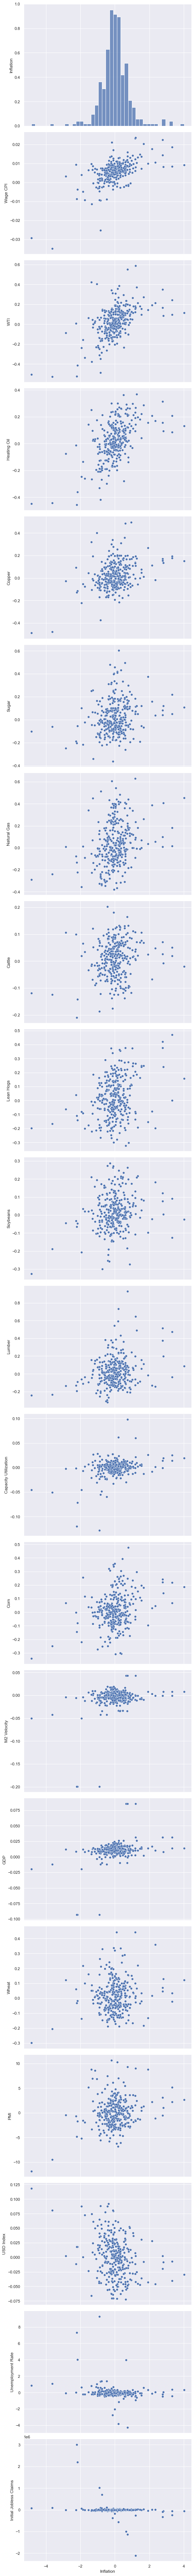

In [4049]:
sns.pairplot(QonQ_r_v_win,
            y_vars = ['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','M2 Velocity','GDP','Wheat','PMI',
                     'USD Index','Unemployment Rate','Initial Jobless Claims'],
            x_vars = ['Inflation'],
             height=5, aspect=1.5,
            )

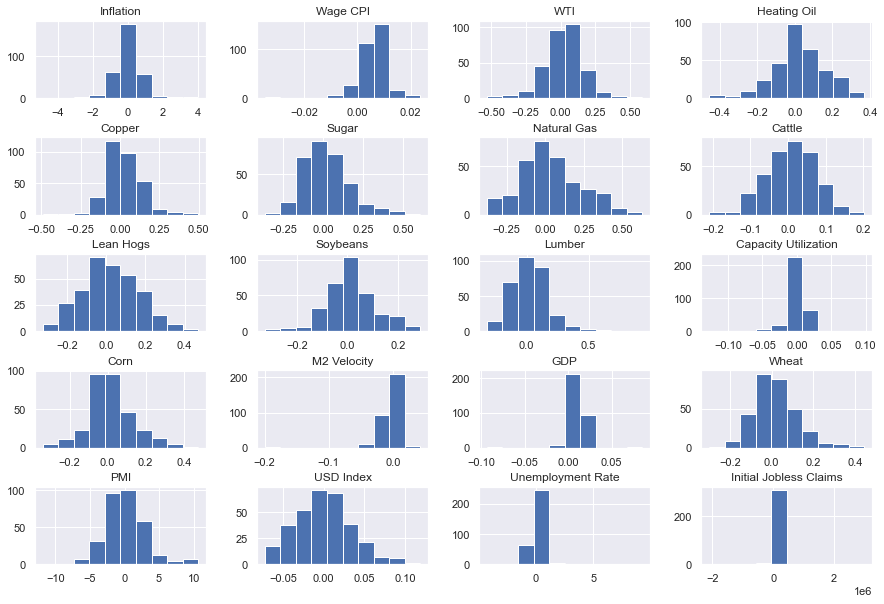

In [4050]:
QonQ_r_v_win.hist(figsize=(15, 10))
plt.subplots_adjust(hspace=0.5)

Looking at each individually.

**Wage CPI**

C:\Users\rands\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


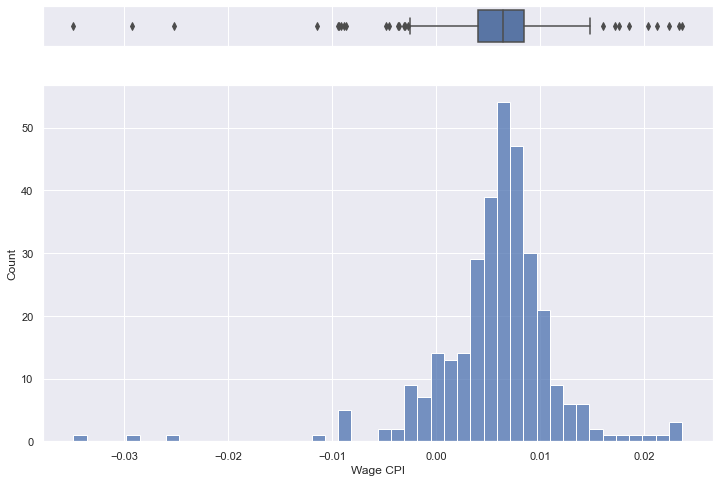

<Figure size 720x432 with 0 Axes>

In [4051]:
sns.set(style="darkgrid")
df = sns.load_dataset("iris")

a4_dims = (12, 8)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=a4_dims, gridspec_kw={"height_ratios": (.10, .90)})
plt.figure(figsize=(10,6))
 
sns.boxplot(QonQ_r_v_win["Wage CPI"], ax=ax_box)
sns.histplot(data=QonQ_r_v_win, x="Wage CPI", ax=ax_hist)
 
ax_box.set(xlabel='')
plt.show()


In [4052]:
# the numbers for the percentile
u_wage_rvwin_per = 99
l_wage_rvwin_per = 1

# the actual percentile
u_wage_rvwin_num = (((u_wage_rvwin_per / 100) - 1) * -1)
l_wage_rvwin_num = l_wage_rvwin_per / 100

# what would result in the dataframe be in the percentiles 
u_wage_rvwin_value = np.percentile(QonQ_r_v_win['Wage CPI'], u_wage_rvwin_per)
l_wage_rvwin_value = np.percentile(QonQ_r_v_win['Wage CPI'], l_wage_rvwin_per)

print('The Upper & Lower Quartiles may be:','\n',
    'Upper |',"{:,}%".format(round((u_wage_rvwin_value),2)),'\n',
     'Lower |',"{:,}%".format(round((l_wage_rvwin_value),2)))


The Upper & Lower Quartiles may be: 
 Upper | 0.02% 
 Lower | -0.01%


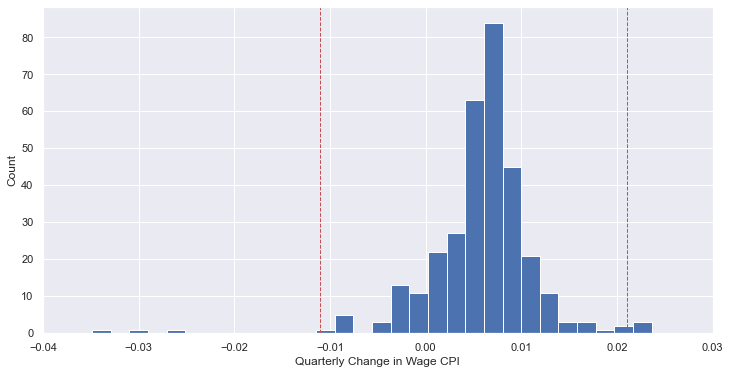

In [4053]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Wage CPI'], bins=30)
plt.xlabel('Quarterly Change in Wage CPI')
plt.ylabel('Count')

x_ticks = np.arange(-0.04, 0.03, 0.01)
plt.xticks(x_ticks)
plt.axvline(u_wage_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_wage_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4054]:
QonQ_r_v_win_a = np.count_nonzero(QonQ_r_v_win['Wage CPI']>=u_wage_rvwin_value)
QonQ_r_v_win_b = np.count_nonzero(QonQ_r_v_win['Wage CPI']<=l_wage_rvwin_value)

print('With a dataframe with',len(QonQ_r_v_win),'observations, the Winsorization breakdown would be','\n',
     QonQ_r_v_win_a,'|', "{:,}%".format(round(((QonQ_r_v_win_a/len(QonQ_r_v_win))*100),1)),'|','Above','\n',
     QonQ_r_v_win_b,'|', "{:,}%".format(round(((QonQ_r_v_win_b/len(QonQ_r_v_win))*100),1)),'|','Below','\n',
     (QonQ_r_v_win_a + QonQ_r_v_win_b),'|',
      "{:,}%".format(round((((QonQ_r_v_win_a + QonQ_r_v_win_b)/len(QonQ_r_v_win))*100),1)),'|','in Total')

With a dataframe with 321 observations, the Winsorization breakdown would be 
 4 | 1.2% | Above 
 4 | 1.2% | Below 
 8 | 2.5% | in Total


Winsorizing those in negative territory.

In [4055]:
# Winsorize
QonQ_r_v_win["Wage CPI"] = winsorize(QonQ_r_v_win["Wage CPI"], limits=[l_wage_rvwin_num, 0])

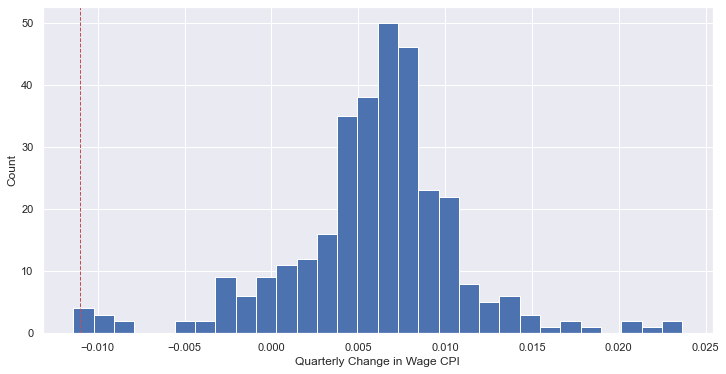

In [4056]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Wage CPI'], bins=30)
plt.xlabel('Quarterly Change in Wage CPI')
plt.ylabel('Count')

# plt.axvline(u_wage_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_wage_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4057]:
prev_wage = round(((q_q_roll_bf_T['Wage CPI'][1])*100),2)
new_wage = round(((QonQ_r_v_win['Wage CPI'].corr(QonQ_r_v_win['Inflation']))*100),2)
spread = round(new_wage - prev_wage,2)
print('This Winsorization resulted in a',spread,'move in the Pearson Score',win(spread))

This Winsorization resulted in a -3.17 move in the Pearson Score we will keep the old un-Winsorized.


In [4058]:
QonQ_r_v_win['Wage CPI'] = QonQ_main_roll_side['Wage CPI']

**WTI** | Winsorizing

C:\Users\rands\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


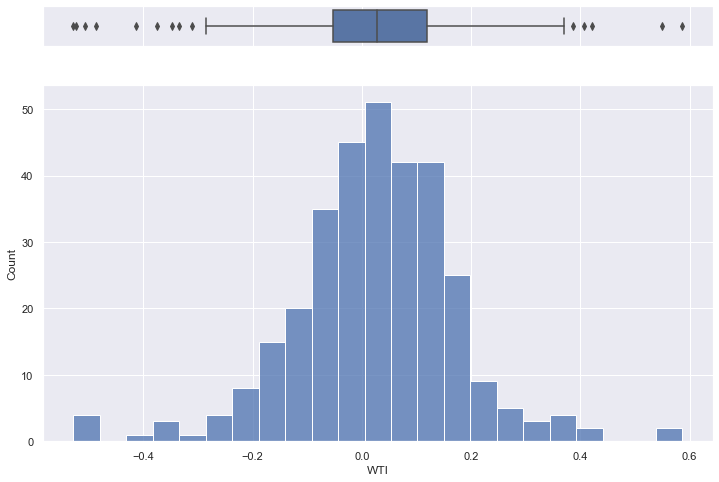

<Figure size 720x432 with 0 Axes>

In [4059]:
sns.set(style="darkgrid")
df = sns.load_dataset("iris")

a4_dims = (12, 8)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=a4_dims, gridspec_kw={"height_ratios": (.10, .90)})
plt.figure(figsize=(10,6))
 
sns.boxplot(QonQ_r_v_win["WTI"], ax=ax_box)
sns.histplot(data=QonQ_r_v_win, x="WTI", ax=ax_hist)
 
ax_box.set(xlabel='')
plt.show()


In [4060]:
# the numbers for the percentile
u_wti_rvwin_per = 99
l_wti_rvwin_per = 1

# the actual percentile
u_wti_rvwin_num = (((u_wti_rvwin_per / 100) - 1) * -1)
l_wti_rvwin_num = l_wti_rvwin_per / 100

# what would result in the dataframe be in the percentiles 
u_wti_rvwin_value = np.percentile(QonQ_r_v_win['WTI'], u_wti_rvwin_per)
l_wti_rvwin_value = np.percentile(QonQ_r_v_win['WTI'], l_wti_rvwin_per)

print('The Upper & Lower Quartiles may be:','\n',
    'Upper |',"{:,}%".format(round((u_wti_rvwin_value),2)),'\n',
     'Lower |',"{:,}%".format(round((l_wti_rvwin_value),2)))


The Upper & Lower Quartiles may be: 
 Upper | 0.4% 
 Lower | -0.47%


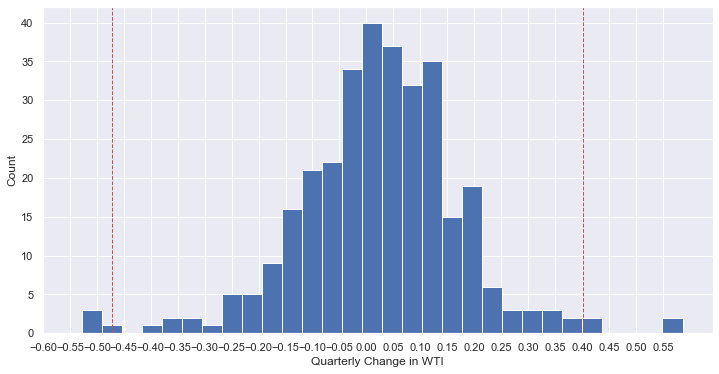

In [4061]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['WTI'], bins=30)
plt.xlabel('Quarterly Change in WTI')
plt.ylabel('Count')

x_ticks = np.arange(-0.6, 0.6, 0.05)
plt.xticks(x_ticks)
plt.axvline(u_wti_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_wti_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4062]:
wti_r_v_win_a = np.count_nonzero(QonQ_r_v_win['WTI']>=u_wti_rvwin_value)
wti_r_v_win_b = np.count_nonzero(QonQ_r_v_win['WTI']<=l_wti_rvwin_value)

print('With a dataframe with',len(QonQ_r_v_win),'observations, the Winsorization breakdown would be','\n',
     wti_r_v_win_a,'|', "{:,}%".format(round(((wti_r_v_win_a/len(QonQ_r_v_win))*100),1)),'|','Above','\n',
     wti_r_v_win_b,'|', "{:,}%".format(round(((wti_r_v_win_b/len(QonQ_r_v_win))*100),1)),'|','Below','\n',
     (QonQ_r_v_win_a + QonQ_r_v_win_b),'|',
      "{:,}%".format(round((((wti_r_v_win_a + wti_r_v_win_b)/len(QonQ_r_v_win))*100),1)),'|','in Total')

With a dataframe with 321 observations, the Winsorization breakdown would be 
 4 | 1.2% | Above 
 4 | 1.2% | Below 
 8 | 2.5% | in Total


That's a lot; let's still Winsorize.

In [4063]:
# Winsorize
QonQ_r_v_win["WTI"] = winsorize(QonQ_r_v_win["WTI"], limits=[l_wti_rvwin_num, u_wti_rvwin_num])

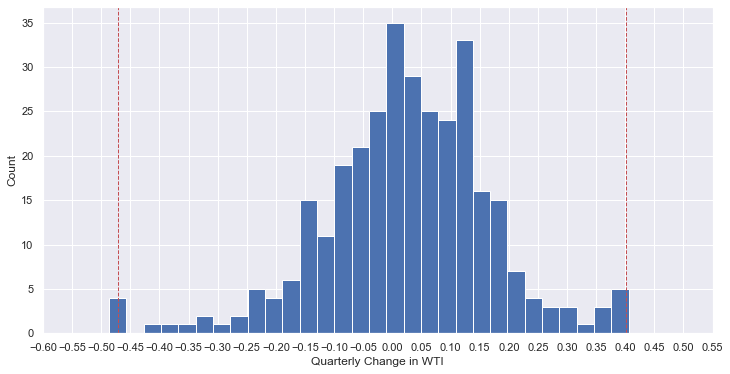

In [4064]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['WTI'], bins=30)
plt.xlabel('Quarterly Change in WTI')
plt.ylabel('Count')

x_ticks = np.arange(-0.6, 0.6, 0.05)
plt.xticks(x_ticks)
plt.axvline(u_wti_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_wti_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4065]:
wti_prev = round(((q_q_roll_bf_T['WTI'][1])*100),2)
wti_new = round(((QonQ_r_v_win['WTI'].corr(QonQ_r_v_win['Inflation']))*100),2)
wti_spread = round(wti_new - wti_prev,2)
print('This Winsorization resulted in a',wti_spread,'move in the Pearson Score',win(wti_spread))

This Winsorization resulted in a 0.07 move in the Pearson Score we will use the new Winsorized.


**Heating Oil** | Winsorizing

C:\Users\rands\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


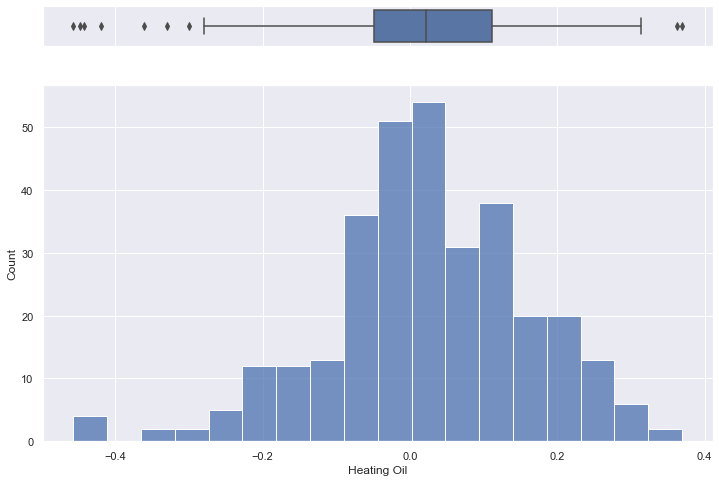

<Figure size 720x432 with 0 Axes>

In [4066]:
sns.set(style="darkgrid")
df = sns.load_dataset("iris")

a4_dims = (12, 8)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=a4_dims, gridspec_kw={"height_ratios": (.10, .90)})
plt.figure(figsize=(10,6))
 
sns.boxplot(QonQ_r_v_win["Heating Oil"], ax=ax_box)
sns.histplot(data=QonQ_r_v_win, x="Heating Oil", ax=ax_hist)
 
ax_box.set(xlabel='')
plt.show()


In [4067]:
# the numbers for the percentile
u_hoil_rvwin_per = 99
l_hoil_rvwin_per = 1.5

# the actual percentile
u_hoil_rvwin_num = (((u_hoil_rvwin_per / 100) - 1) * -1)
l_hoil_rvwin_num = l_hoil_rvwin_per / 100

# what would result in the dataframe be in the percentiles 
u_hoil_rvwin_value = np.percentile(QonQ_r_v_win['Heating Oil'], u_hoil_rvwin_per)
l_hoil_rvwin_value = np.percentile(QonQ_r_v_win['Heating Oil'], l_hoil_rvwin_per)

print('The Upper & Lower Quartiles may be:','\n',
    'Upper |',"{:,}%".format(round((u_hoil_rvwin_value),2)),'\n',
     'Lower |',"{:,}%".format(round((l_hoil_rvwin_value),2)))

The Upper & Lower Quartiles may be: 
 Upper | 0.3% 
 Lower | -0.34%


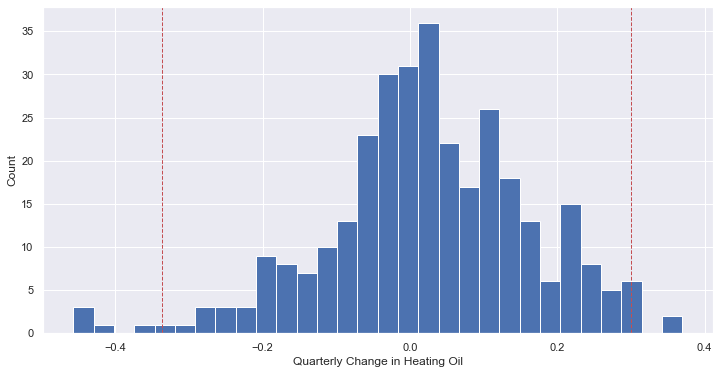

In [4068]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Heating Oil'], bins=30)
plt.xlabel('Quarterly Change in Heating Oil')
plt.ylabel('Count')

plt.axvline(u_hoil_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_hoil_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4069]:
hoil_r_v_win_a = np.count_nonzero(QonQ_r_v_win['Heating Oil']>=u_hoil_rvwin_value)
hoil_r_v_win_b = np.count_nonzero(QonQ_r_v_win['Heating Oil']<=l_hoil_rvwin_value)

print('With a dataframe with',len(QonQ_r_v_win),'observations, the Winsorization breakdown would be','\n',
     hoil_r_v_win_a,'|', "{:,}%".format(round(((hoil_r_v_win_a/len(QonQ_r_v_win))*100),1)),'|','Above','\n',
     hoil_r_v_win_b,'|', "{:,}%".format(round(((hoil_r_v_win_b/len(QonQ_r_v_win))*100),1)),'|','Below','\n',
     (hoil_r_v_win_a + hoil_r_v_win_b),'|',
      "{:,}%".format(round((((hoil_r_v_win_a + hoil_r_v_win_b)/len(QonQ_r_v_win))*100),1)),'|','in Total')

With a dataframe with 321 observations, the Winsorization breakdown would be 
 4 | 1.2% | Above 
 5 | 1.6% | Below 
 9 | 2.8% | in Total


Let's Winsorize.

In [4070]:
# Winsorize
QonQ_r_v_win["Heating Oil"] = winsorize(QonQ_r_v_win["Heating Oil"], limits=[l_hoil_rvwin_num, u_hoil_rvwin_num])

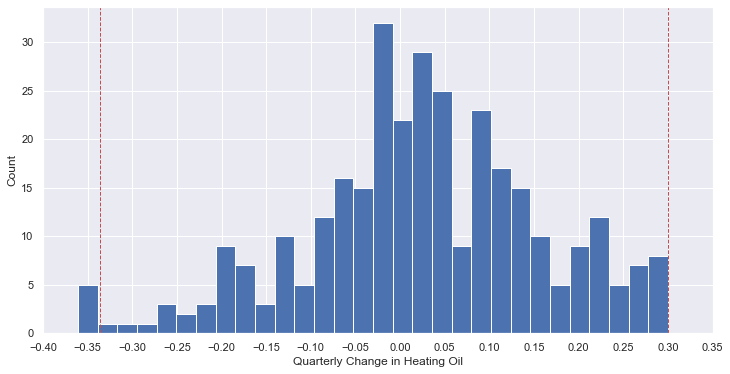

In [4071]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Heating Oil'], bins=30)
plt.xlabel('Quarterly Change in Heating Oil')
plt.ylabel('Count')

x_ticks = np.arange(-0.4, 0.4, 0.05)
plt.xticks(x_ticks)
plt.axvline(u_hoil_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_hoil_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4072]:
hoil_prev = round(((q_q_roll_bf_T['Heating Oil'][1])*100),2)
hoil_new = round(((QonQ_r_v_win['Heating Oil'].corr(QonQ_r_v_win['Inflation']))*100),2)
hoil_spread = round(hoil_new - hoil_prev,2)
print('This Winsorization resulted in a',hoil_spread,'move in the Pearson Score',win(hoil_spread))

This Winsorization resulted in a -1.34 move in the Pearson Score we will keep the old un-Winsorized.


In [4073]:
QonQ_r_v_win['Heating Oil'] = QonQ_main_roll_side['Heating Oil']

**Copper** | Winsorizing

C:\Users\rands\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


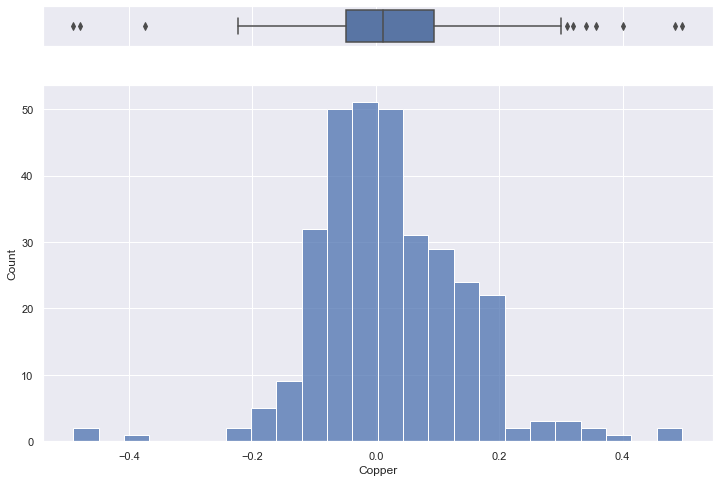

<Figure size 720x432 with 0 Axes>

In [4074]:
sns.set(style="darkgrid")
df = sns.load_dataset("iris")

a4_dims = (12, 8)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=a4_dims, gridspec_kw={"height_ratios": (.10, .90)})
plt.figure(figsize=(10,6))
 
sns.boxplot(QonQ_r_v_win["Copper"], ax=ax_box)
sns.histplot(data=QonQ_r_v_win, x="Copper", ax=ax_hist)
 
ax_box.set(xlabel='')
plt.show()


In [4075]:
# the numbers for the percentile
u_copper_rvwin_per = 99
l_copper_rvwin_per = 1

# the actual percentile
u_copper_rvwin_num = (((u_copper_rvwin_per / 100) - 1) * -1)
l_copper_rvwin_num = l_copper_rvwin_per / 100

# what would result in the dataframe be in the percentiles 
u_copper_rvwin_value = np.percentile(QonQ_r_v_win['Copper'], u_copper_rvwin_per)
l_copper_rvwin_value = np.percentile(QonQ_r_v_win['Copper'], l_copper_rvwin_per)

print('The Upper & Lower Quartiles may be:','\n',
    'Upper |',"{:,}%".format(round((u_copper_rvwin_value),2)),'\n',
     'Lower |',"{:,}%".format(round((l_copper_rvwin_value),2)))

The Upper & Lower Quartiles may be: 
 Upper | 0.35% 
 Lower | -0.22%


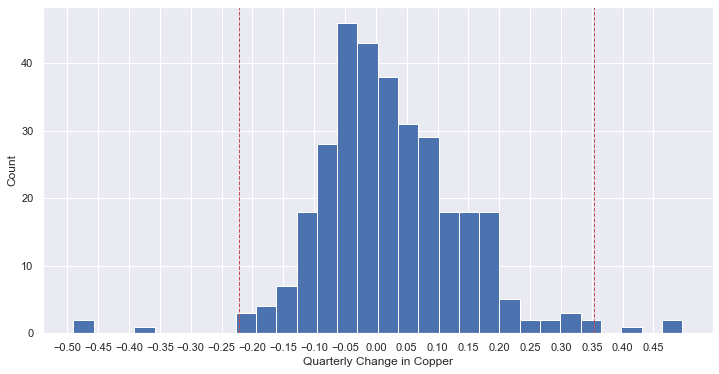

In [4076]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Copper'], bins=30)
plt.xlabel('Quarterly Change in Copper')
plt.ylabel('Count')

x_ticks = np.arange(-0.5, 0.5, 0.05)
plt.xticks(x_ticks)
plt.axvline(u_copper_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_copper_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4077]:
copper_r_v_win_a = np.count_nonzero(QonQ_r_v_win['Copper']>=u_copper_rvwin_value)
copper_r_v_win_b = np.count_nonzero(QonQ_r_v_win['Copper']<=l_copper_rvwin_value)

print('With a dataframe with',len(QonQ_r_v_win),'observations, the Winsorization breakdown would be','\n',
     copper_r_v_win_a,'|', "{:,}%".format(round(((copper_r_v_win_a/len(QonQ_r_v_win))*100),1)),'|','Above','\n',
     copper_r_v_win_b,'|', "{:,}%".format(round(((copper_r_v_win_b/len(QonQ_r_v_win))*100),1)),'|','Below','\n',
     (copper_r_v_win_a + copper_r_v_win_b),'|',
      "{:,}%".format(round((((copper_r_v_win_a + copper_r_v_win_b)/len(QonQ_r_v_win))*100),1)),'|','in Total')

With a dataframe with 321 observations, the Winsorization breakdown would be 
 4 | 1.2% | Above 
 4 | 1.2% | Below 
 8 | 2.5% | in Total


Winsorize.

In [4078]:
# Winsorize
QonQ_r_v_win["Copper"] = winsorize(QonQ_r_v_win["Copper"], limits=[l_copper_rvwin_num, u_copper_rvwin_num])

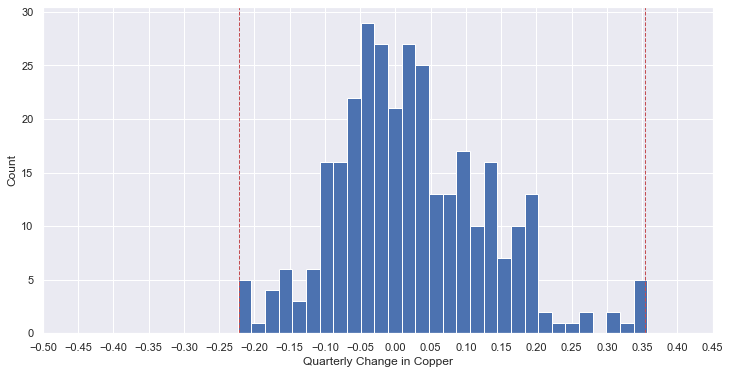

In [4079]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Copper'], bins=30)
plt.xlabel('Quarterly Change in Copper')
plt.ylabel('Count')

x_ticks = np.arange(-0.5, 0.5, 0.05)
plt.xticks(x_ticks)
plt.axvline(u_copper_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_copper_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4080]:
cop_prev = round(((q_q_roll_bf_T['Copper'][1])*100),2)
cop_new = round(((QonQ_r_v_win['Copper'].corr(QonQ_r_v_win['Inflation']))*100),2)
cop_spread = round(cop_new - cop_prev,2)
print('This Winsorization resulted in a',cop_spread,'move in the Pearson Score',win(cop_spread))

This Winsorization resulted in a -4.8 move in the Pearson Score we will keep the old un-Winsorized.


In [4081]:
QonQ_r_v_win['Copper'] = QonQ_main_roll_side['Copper']

**Sugar** | Winsorizing

C:\Users\rands\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


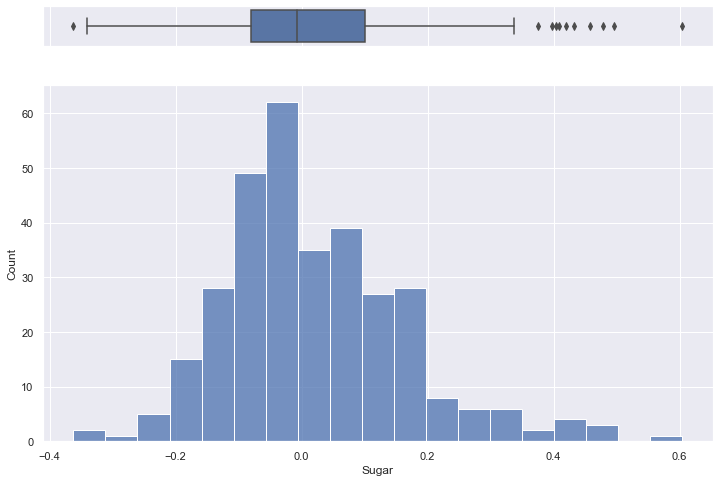

<Figure size 720x432 with 0 Axes>

In [4082]:
sns.set(style="darkgrid")
df = sns.load_dataset("iris")

a4_dims = (12, 8)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=a4_dims, gridspec_kw={"height_ratios": (.10, .90)})
plt.figure(figsize=(10,6))
 
sns.boxplot(QonQ_r_v_win["Sugar"], ax=ax_box)
sns.histplot(data=QonQ_r_v_win, x="Sugar", ax=ax_hist)
 
ax_box.set(xlabel='')
plt.show()


In [4083]:
# the numbers for the percentile
u_sugar_rvwin_per = 99
l_sugar_rvwin_per = 1

# the actual percentile
u_sugar_rvwin_num = (((u_sugar_rvwin_per / 100) - 1) * -1)
l_sugar_rvwin_num = l_sugar_rvwin_per / 100

# what would result in the dataframe be in the percentiles 
u_sugar_rvwin_value = np.percentile(QonQ_r_v_win['Sugar'], u_sugar_rvwin_per)
l_sugar_rvwin_value = np.percentile(QonQ_r_v_win['Sugar'], l_sugar_rvwin_per)

print('The Upper & Lower Quartiles may be:','\n',
    'Upper |',"{:,}%".format(round((u_sugar_rvwin_value),2)),'\n',
     'Lower |',"{:,}%".format(round((l_sugar_rvwin_value),2)))

The Upper & Lower Quartiles may be: 
 Upper | 0.45% 
 Lower | -0.25%


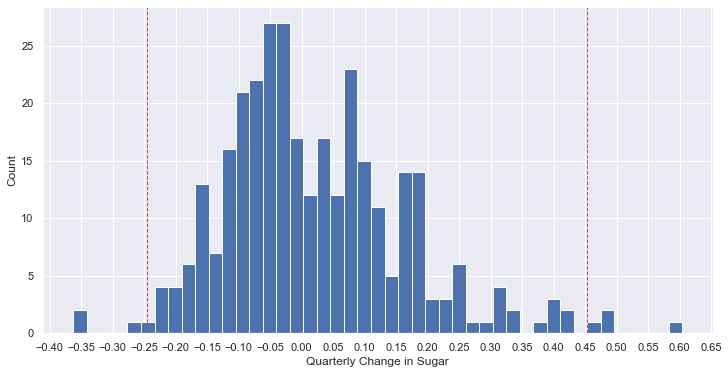

In [4084]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Sugar'], bins=45)
plt.xlabel('Quarterly Change in Sugar')
plt.ylabel('Count')

x_ticks = np.arange(-0.4, 0.7, 0.05)
plt.xticks(x_ticks)
plt.axvline(u_sugar_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_sugar_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4085]:
sugar_r_v_win_a = np.count_nonzero(QonQ_r_v_win['Sugar']>=u_sugar_rvwin_value)
sugar_r_v_win_b = np.count_nonzero(QonQ_r_v_win['Sugar']<=l_sugar_rvwin_value)

print('With a dataframe with',len(QonQ_r_v_win),'observations, the Winsorization breakdown would be','\n',
     sugar_r_v_win_a,'|', "{:,}%".format(round(((sugar_r_v_win_a/len(QonQ_r_v_win))*100),1)),'|','Above','\n',
     sugar_r_v_win_b,'|', "{:,}%".format(round(((sugar_r_v_win_b/len(QonQ_r_v_win))*100),1)),'|','Below','\n',
     (sugar_r_v_win_a + sugar_r_v_win_b),'|',
      "{:,}%".format(round((((sugar_r_v_win_a + sugar_r_v_win_b)/len(QonQ_r_v_win))*100),1)),'|','in Total')

With a dataframe with 321 observations, the Winsorization breakdown would be 
 4 | 1.2% | Above 
 4 | 1.2% | Below 
 8 | 2.5% | in Total


Winsorize

In [4086]:
# Winsorize
QonQ_r_v_win["Sugar"] = winsorize(QonQ_r_v_win["Sugar"], limits=[l_sugar_rvwin_num, u_sugar_rvwin_num])

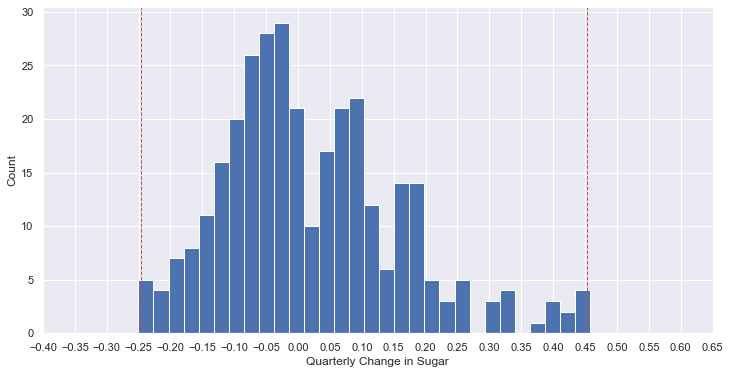

In [4087]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Sugar'], bins=30)
plt.xlabel('Quarterly Change in Sugar')
plt.ylabel('Count')

x_ticks = np.arange(-0.4, 0.7, 0.05)
plt.xticks(x_ticks)
plt.axvline(u_sugar_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_sugar_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4088]:
sugar_prev = round(((q_q_roll_bf_T['Sugar'][1])*100),2)
sugar_new = round(((QonQ_r_v_win['Sugar'].corr(QonQ_r_v_win['Inflation']))*100),2)
sugar_spread = round(sugar_new - sugar_prev,2)
print('This Winsorization resulted in a',sugar_spread,'move in the Pearson Score',win(sugar_spread))

This Winsorization resulted in a 0.14 move in the Pearson Score we will use the new Winsorized.


**Natural Gas** | Winsorizing

C:\Users\rands\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


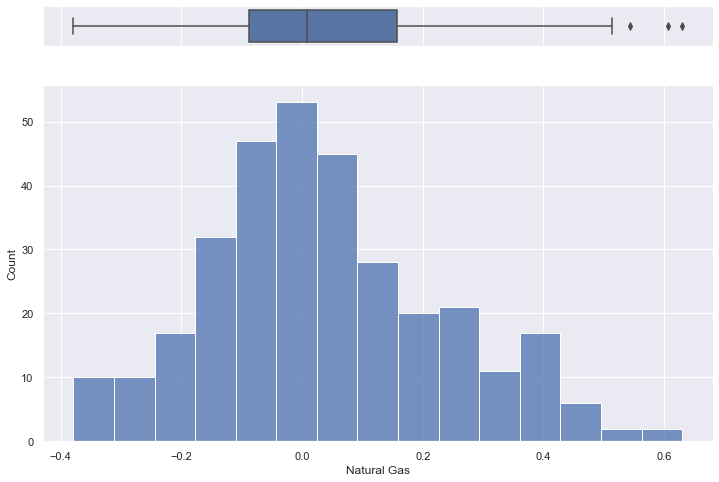

<Figure size 720x432 with 0 Axes>

In [4089]:
sns.set(style="darkgrid")
df = sns.load_dataset("iris")

a4_dims = (12, 8)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=a4_dims, gridspec_kw={"height_ratios": (.10, .90)})
plt.figure(figsize=(10,6))
 
sns.boxplot(QonQ_r_v_win["Natural Gas"], ax=ax_box)
sns.histplot(data=QonQ_r_v_win, x="Natural Gas", ax=ax_hist)
 
ax_box.set(xlabel='')
plt.show()


In [4090]:
# the numbers for the percentile
u_ngas_rvwin_per = 98
l_ngas_rvwin_per = 1

# the actual percentile
u_ngas_rvwin_num = (((u_ngas_rvwin_per / 100) - 1) * -1)
l_ngas_rvwin_num = l_ngas_rvwin_per / 100

# what would result in the dataframe be in the percentiles 
u_ngas_rvwin_value = np.percentile(QonQ_r_v_win['Natural Gas'], u_ngas_rvwin_per)
l_ngas_rvwin_value = np.percentile(QonQ_r_v_win['Natural Gas'], l_ngas_rvwin_per)

print('The Upper & Lower Quartiles may be:','\n',
    'Upper |',"{:,}%".format(round((u_ngas_rvwin_value),2)),'\n',
     'Lower |',"{:,}%".format(round((l_ngas_rvwin_value),2)))

The Upper & Lower Quartiles may be: 
 Upper | 0.45% 
 Lower | -0.34%


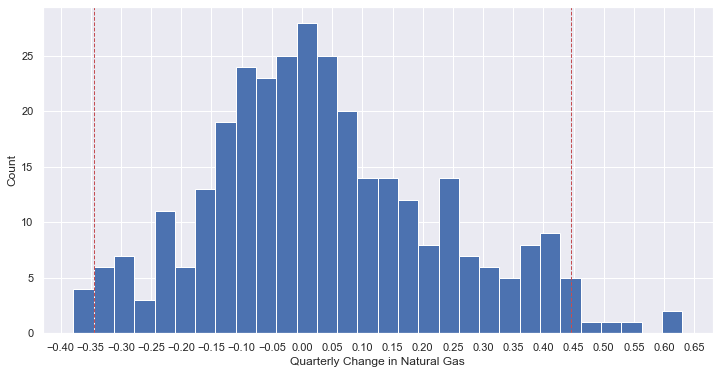

In [4091]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Natural Gas'], bins=30)
plt.xlabel('Quarterly Change in Natural Gas')
plt.ylabel('Count')

x_ticks = np.arange(-0.4, 0.7, 0.05)
plt.xticks(x_ticks)
plt.axvline(u_ngas_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_ngas_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4092]:
ngas_r_v_win_a = np.count_nonzero(QonQ_r_v_win['Natural Gas']>=u_ngas_rvwin_value)
ngas_r_v_win_b = np.count_nonzero(QonQ_r_v_win['Natural Gas']<=l_ngas_rvwin_value)

print('With a dataframe with',len(QonQ_r_v_win),'observations, the Winsorization breakdown would be','\n',
     ngas_r_v_win_a,'|', "{:,}%".format(round(((ngas_r_v_win_a/len(QonQ_r_v_win))*100),1)),'|','Above','\n',
     ngas_r_v_win_b,'|', "{:,}%".format(round(((ngas_r_v_win_b/len(QonQ_r_v_win))*100),1)),'|','Below','\n',
     (ngas_r_v_win_a + ngas_r_v_win_b),'|',
      "{:,}%".format(round((((ngas_r_v_win_a + ngas_r_v_win_b)/len(QonQ_r_v_win))*100),1)),'|','in Total')

With a dataframe with 321 observations, the Winsorization breakdown would be 
 7 | 2.2% | Above 
 4 | 1.2% | Below 
 11 | 3.4% | in Total


That's a fair bit of observations; the `Above` will be Winsorized.

In [4093]:
# Winsorize
QonQ_r_v_win["Natural Gas"] = winsorize(QonQ_r_v_win["Natural Gas"], limits=[0, u_ngas_rvwin_num])

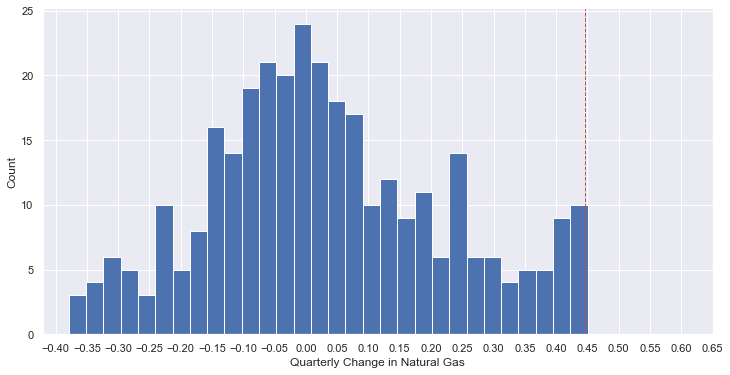

In [4094]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Natural Gas'], bins=30)
plt.xlabel('Quarterly Change in Natural Gas')
plt.ylabel('Count')

x_ticks = np.arange(-0.4, 0.7, 0.05)
plt.xticks(x_ticks)
plt.axvline(u_ngas_rvwin_value, color='r', linestyle='dashed', linewidth=1)
# plt.axvline(l_wage_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4095]:
natg_prev = round(((q_q_roll_bf_T['Natural Gas'][1])*100),2)
natg_new = round(((QonQ_r_v_win['Natural Gas'].corr(QonQ_r_v_win['Inflation']))*100),2)
natg_spread = round(natg_new - natg_prev,2)
print('This Winsorization resulted in a',natg_spread,'move in the Pearson Score',win(natg_spread))

This Winsorization resulted in a 0.31 move in the Pearson Score we will use the new Winsorized.


**Cattle** | Winsorizing

C:\Users\rands\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


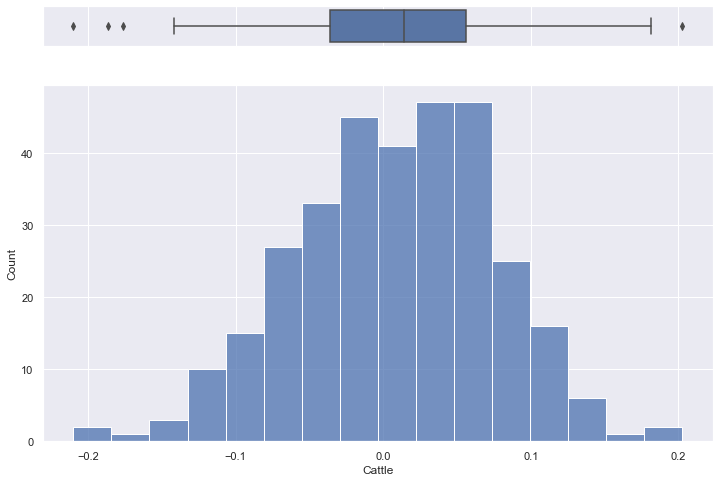

<Figure size 720x432 with 0 Axes>

In [4096]:
sns.set(style="darkgrid")
df = sns.load_dataset("iris")

a4_dims = (12, 8)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=a4_dims, gridspec_kw={"height_ratios": (.10, .90)})
plt.figure(figsize=(10,6))
 
sns.boxplot(QonQ_r_v_win["Cattle"], ax=ax_box)
sns.histplot(data=QonQ_r_v_win, x="Cattle", ax=ax_hist)
 
ax_box.set(xlabel='')
plt.show()


In [4097]:
# the numbers for the percentile
u_cat_rvwin_per = 99.5
l_cat_rvwin_per = 0.5

# the actual percentile
u_cat_rvwin_num = (((u_cat_rvwin_per / 100) - 1) * -1)
l_cat_rvwin_num = l_cat_rvwin_per / 100

# what would result in the dataframe be in the percentiles 
u_cat_rvwin_value = np.percentile(QonQ_r_v_win['Cattle'], u_cat_rvwin_per)
l_cat_rvwin_value = np.percentile(QonQ_r_v_win['Cattle'], l_cat_rvwin_per)

print('The Upper & Lower Quartiles may be:','\n',
    'Upper |',"{:,}%".format(round((u_cat_rvwin_value),2)),'\n',
     'Lower |',"{:,}%".format(round((l_cat_rvwin_value),2)))

The Upper & Lower Quartiles may be: 
 Upper | 0.17% 
 Lower | -0.18%


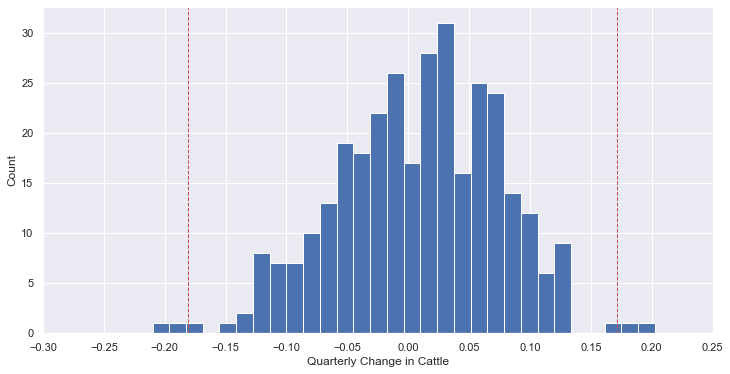

In [4098]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Cattle'], bins=30)
plt.xlabel('Quarterly Change in Cattle')
plt.ylabel('Count')

x_ticks = np.arange(-0.3, 0.3, 0.05)
plt.xticks(x_ticks)
plt.axvline(u_cat_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_cat_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4099]:
cat_r_v_win_a = np.count_nonzero(QonQ_r_v_win['Cattle']>=u_cat_rvwin_value)
cat_r_v_win_b = np.count_nonzero(QonQ_r_v_win['Cattle']<=l_cat_rvwin_value)

print('With a dataframe with',len(QonQ_r_v_win),'observations, the Winsorization breakdown would be','\n',
     cat_r_v_win_a,'|', "{:,}%".format(round(((cat_r_v_win_a/len(QonQ_r_v_win))*100),1)),'|','Above','\n',
     cat_r_v_win_b,'|', "{:,}%".format(round(((cat_r_v_win_b/len(QonQ_r_v_win))*100),1)),'|','Below','\n',
     (cat_r_v_win_a + cat_r_v_win_b),'|',
      "{:,}%".format(round((((cat_r_v_win_a + cat_r_v_win_b)/len(QonQ_r_v_win))*100),1)),'|','in Total')

With a dataframe with 321 observations, the Winsorization breakdown would be 
 2 | 0.6% | Above 
 2 | 0.6% | Below 
 4 | 1.2% | in Total


Winsorize.

In [4100]:
# Winsorize
QonQ_r_v_win["Cattle"] = winsorize(QonQ_r_v_win["Cattle"], limits=[l_cat_rvwin_num, u_cat_rvwin_num])

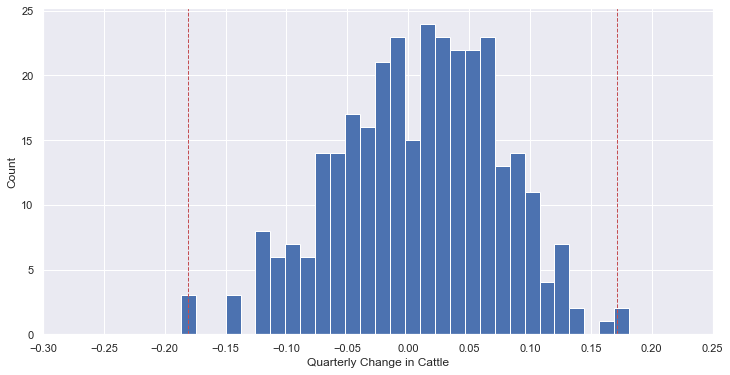

In [4101]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Cattle'], bins=30)
plt.xlabel('Quarterly Change in Cattle')
plt.ylabel('Count')

x_ticks = np.arange(-0.3, 0.3, 0.05)
plt.xticks(x_ticks)
plt.axvline(u_cat_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_cat_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4102]:
cat_prev = round(((q_q_roll_bf_T['Cattle'][1])*100),2)
cat_new = round(((QonQ_r_v_win['Cattle'].corr(QonQ_r_v_win['Inflation']))*100),2)
cat_spread = round(cat_new - cat_prev,2)
print('This Winsorization resulted in a',cat_spread,'move in the Pearson Score',win(cat_spread))

This Winsorization resulted in a -0.13 move in the Pearson Score we will keep the old un-Winsorized.


In [4103]:
QonQ_r_v_win['Cattle'] = QonQ_main_roll_side['Cattle']

**Lean Hogs** | Winsorizing

C:\Users\rands\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


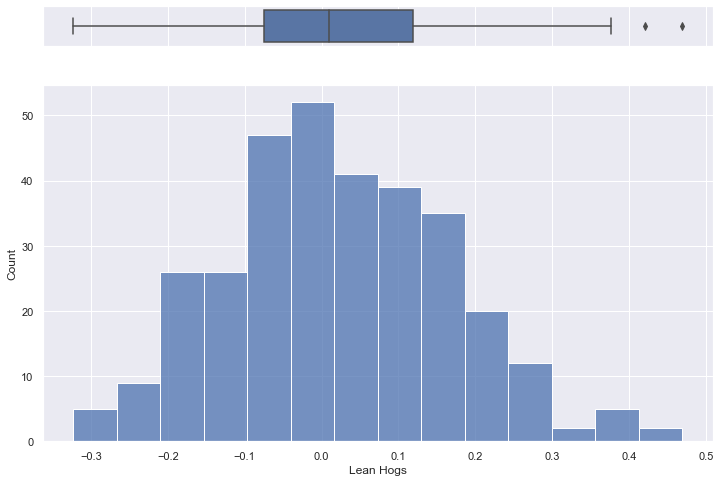

<Figure size 720x432 with 0 Axes>

In [4104]:
sns.set(style="darkgrid")
df = sns.load_dataset("iris")

a4_dims = (12, 8)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=a4_dims, gridspec_kw={"height_ratios": (.10, .90)})
plt.figure(figsize=(10,6))
 
sns.boxplot(QonQ_r_v_win["Lean Hogs"], ax=ax_box)
sns.histplot(data=QonQ_r_v_win, x="Lean Hogs", ax=ax_hist)
 
ax_box.set(xlabel='')
plt.show()


In [4105]:
# the numbers for the percentile
u_lhog_rvwin_per = 99
l_lhog_rvwin_per = 1

# the actual percentile
u_lhog_rvwin_num = (((u_lhog_rvwin_per / 100) - 1) * -1)
l_lhog_rvwin_num = l_lhog_rvwin_per / 100

# what would result in the dataframe be in the percentiles 
u_lhog_rvwin_value = np.percentile(QonQ_r_v_win['Lean Hogs'], u_lhog_rvwin_per)
l_lhog_rvwin_value = np.percentile(QonQ_r_v_win['Lean Hogs'], l_lhog_rvwin_per)

print('The Upper & Lower Quartiles may be:','\n',
    'Upper |',"{:,}%".format(round((u_lhog_rvwin_value),2)),'\n',
     'Lower |',"{:,}%".format(round((l_lhog_rvwin_value),2)))

The Upper & Lower Quartiles may be: 
 Upper | 0.38% 
 Lower | -0.28%


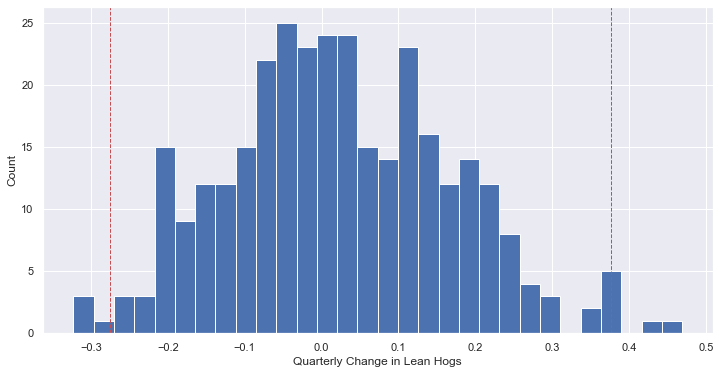

In [4106]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Lean Hogs'], bins=30)
plt.xlabel('Quarterly Change in Lean Hogs')
plt.ylabel('Count')

plt.axvline(u_lhog_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_lhog_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4107]:
lhog_r_v_win_a = np.count_nonzero(QonQ_r_v_win['Lean Hogs']>=u_lhog_rvwin_value)
lhog_r_v_win_b = np.count_nonzero(QonQ_r_v_win['Lean Hogs']<=l_lhog_rvwin_value)

print('With a dataframe with',len(QonQ_r_v_win),'observations, the Winsorization breakdown would be','\n',
     lhog_r_v_win_a,'|', "{:,}%".format(round(((lhog_r_v_win_a/len(QonQ_r_v_win))*100),1)),'|','Above','\n',
     lhog_r_v_win_b,'|', "{:,}%".format(round(((lhog_r_v_win_b/len(QonQ_r_v_win))*100),1)),'|','Below','\n',
     (lhog_r_v_win_a + lhog_r_v_win_b),'|',
      "{:,}%".format(round((((lhog_r_v_win_a + lhog_r_v_win_b)/len(QonQ_r_v_win))*100),1)),'|','in Total')

With a dataframe with 321 observations, the Winsorization breakdown would be 
 4 | 1.2% | Above 
 4 | 1.2% | Below 
 8 | 2.5% | in Total


Winsorize

In [4108]:
# Winsorize
QonQ_r_v_win["Lean Hogs"] = winsorize(QonQ_r_v_win["Lean Hogs"], limits=[l_lhog_rvwin_num, u_lhog_rvwin_num])

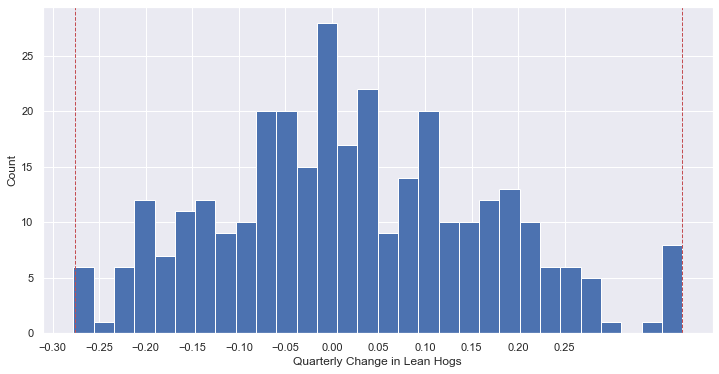

In [4109]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Lean Hogs'], bins=30)
plt.xlabel('Quarterly Change in Lean Hogs')
plt.ylabel('Count')

# x_ticks = np.arange(-0.04, 0.03, 0.01)
plt.xticks(x_ticks)
plt.axvline(u_lhog_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_lhog_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4110]:
lhog_prev = round(((q_q_roll_bf_T['Lean Hogs'][1])*100),2)
lhog_new = round(((QonQ_r_v_win['Lean Hogs'].corr(QonQ_r_v_win['Inflation']))*100),2)
lhog_spread = round(lhog_new - lhog_prev,2)
print('This Winsorization resulted in a',lhog_spread,'move in the Pearson Score',win(lhog_spread))

This Winsorization resulted in a -0.59 move in the Pearson Score we will keep the old un-Winsorized.


In [4111]:
QonQ_r_v_win['Lean Hogs'] = QonQ_main_roll_side['Lean Hogs']

**Soybeans** | Winsorizing

C:\Users\rands\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


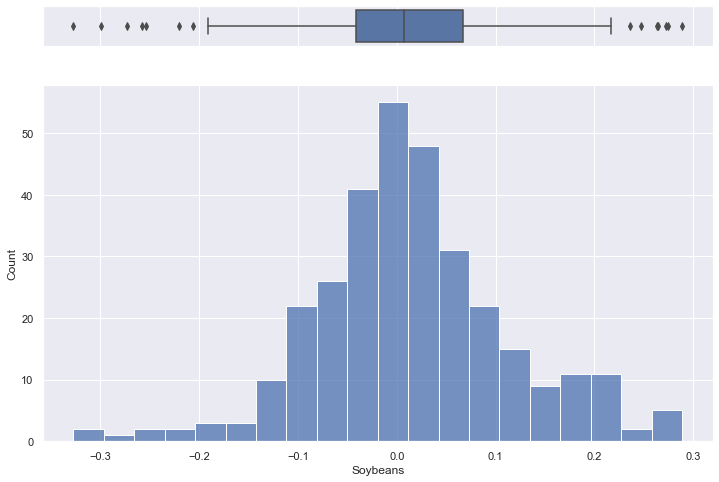

<Figure size 720x432 with 0 Axes>

In [4112]:
sns.set(style="darkgrid")
df = sns.load_dataset("iris")

a4_dims = (12, 8)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=a4_dims, gridspec_kw={"height_ratios": (.10, .90)})
plt.figure(figsize=(10,6))
 
sns.boxplot(QonQ_r_v_win["Soybeans"], ax=ax_box)
sns.histplot(data=QonQ_r_v_win, x="Soybeans", ax=ax_hist)
 
ax_box.set(xlabel='')
plt.show()


In [4113]:
# the numbers for the percentile
u_sb_rvwin_per = 99
l_sb_rvwin_per = 1

# the actual percentile
u_sb_rvwin_num = (((u_sb_rvwin_per / 100) - 1) * -1)
l_sb_rvwin_num = l_sb_rvwin_per / 100

# what would result in the dataframe be in the percentiles 
u_sb_rvwin_value = np.percentile(QonQ_r_v_win['Soybeans'], u_sb_rvwin_per)
l_sb_rvwin_value = np.percentile(QonQ_r_v_win['Soybeans'], l_sb_rvwin_per)

print('The Upper & Lower Quartiles may be:','\n',
    'Upper |',"{:,}%".format(round((u_sb_rvwin_value),2)),'\n',
     'Lower |',"{:,}%".format(round((l_sb_rvwin_value),2)))

The Upper & Lower Quartiles may be: 
 Upper | 0.26% 
 Lower | -0.26%


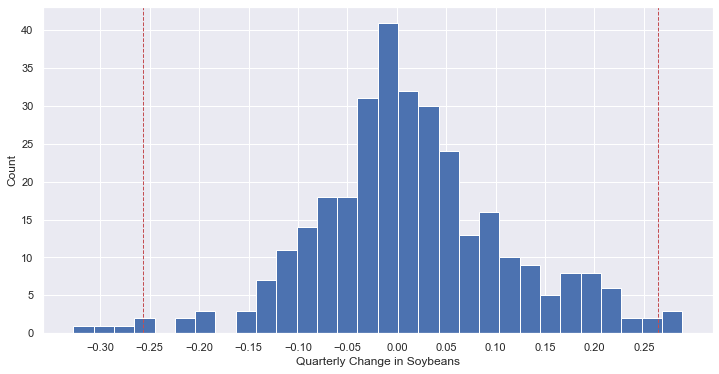

In [4114]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Soybeans'], bins=30)
plt.xlabel('Quarterly Change in Soybeans')
plt.ylabel('Count')

# x_ticks = np.arange(-0.04, 0.03, 0.01)
plt.xticks(x_ticks)
plt.axvline(u_sb_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_sb_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4115]:
sb_r_v_win_a = np.count_nonzero(QonQ_r_v_win['Soybeans']>=u_sb_rvwin_value)
sb_r_v_win_b = np.count_nonzero(QonQ_r_v_win['Soybeans']<=l_sb_rvwin_value)

print('With a dataframe with',len(QonQ_r_v_win),'observations, the Winsorization breakdown would be','\n',
     sb_r_v_win_a,'|', "{:,}%".format(round(((sb_r_v_win_a/len(QonQ_r_v_win))*100),1)),'|','Above','\n',
     sb_r_v_win_b,'|', "{:,}%".format(round(((sb_r_v_win_b/len(QonQ_r_v_win))*100),1)),'|','Below','\n',
     (sb_r_v_win_a + sb_r_v_win_b),'|',
      "{:,}%".format(round((((sb_r_v_win_a + sb_r_v_win_b)/len(QonQ_r_v_win))*100),1)),'|','in Total')

With a dataframe with 321 observations, the Winsorization breakdown would be 
 4 | 1.2% | Above 
 4 | 1.2% | Below 
 8 | 2.5% | in Total


Winsorize

In [4116]:
# Winsorize
QonQ_r_v_win["Soybeans"] = winsorize(QonQ_r_v_win["Soybeans"], limits=[l_sb_rvwin_num, u_sb_rvwin_num])

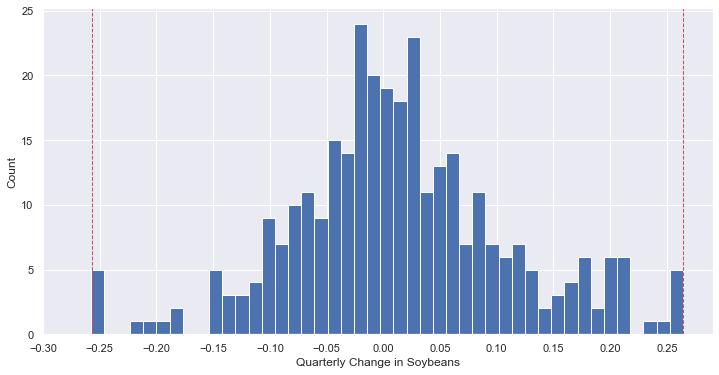

In [4117]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Soybeans'], bins=45)
plt.xlabel('Quarterly Change in Soybeans')
plt.ylabel('Count')

plt.xticks(x_ticks)
plt.axvline(u_sb_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_sb_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4118]:
sbeans_prev = round(((q_q_roll_bf_T['Soybeans'][1])*100),2)
sbeans_new = round(((QonQ_r_v_win['Soybeans'].corr(QonQ_r_v_win['Inflation']))*100),2)
sbeans_spread = round(sbeans_new - sbeans_prev,2)
print('This Winsorization resulted in a',sbeans_spread,'move in the Pearson Score',win(sbeans_spread))

This Winsorization resulted in a -0.93 move in the Pearson Score we will keep the old un-Winsorized.


In [4119]:
QonQ_r_v_win['Soybeans'] = QonQ_main_roll_side['Soybeans']

**Lumber** | Winsorizing

C:\Users\rands\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


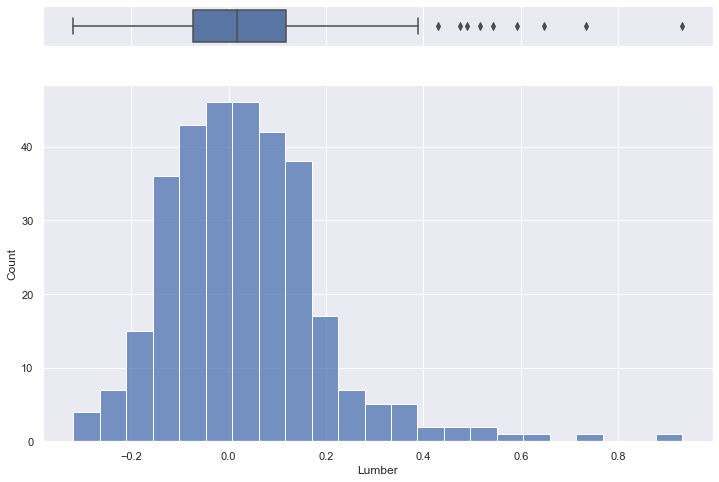

<Figure size 720x432 with 0 Axes>

In [4120]:
sns.set(style="darkgrid")
df = sns.load_dataset("iris")

a4_dims = (12, 8)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=a4_dims, gridspec_kw={"height_ratios": (.10, .90)})
plt.figure(figsize=(10,6))
 
sns.boxplot(QonQ_r_v_win["Lumber"], ax=ax_box)
sns.histplot(data=QonQ_r_v_win, x="Lumber", ax=ax_hist)
 
ax_box.set(xlabel='')
plt.show()


In [4121]:
# the numbers for the percentile
u_lum_rvwin_per = 97.5
l_lum_rvwin_per = 1

# the actual percentile
u_lum_rvwin_num = (((u_lum_rvwin_per / 100) - 1) * -1)
l_lum_rvwin_num = l_lum_rvwin_per / 100

# what would result in the dataframe be in the percentiles 
u_lum_rvwin_value = np.percentile(QonQ_r_v_win['Lumber'], u_lum_rvwin_per)
l_lum_rvwin_value = np.percentile(QonQ_r_v_win['Lumber'], l_lum_rvwin_per)

print('The Upper & Lower Quartiles may be:','\n',
    'Upper |',"{:,}%".format(round((u_lum_rvwin_value),2)),'\n',
     'Lower |',"{:,}%".format(round((l_lum_rvwin_value),2)))

The Upper & Lower Quartiles may be: 
 Upper | 0.43% 
 Lower | -0.26%


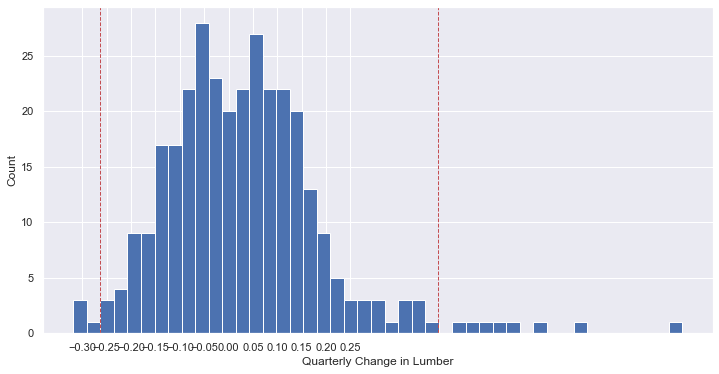

In [4122]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Lumber'], bins=45)
plt.xlabel('Quarterly Change in Lumber')
plt.ylabel('Count')

plt.xticks(x_ticks)
plt.axvline(u_lum_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_lum_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4123]:
lum_r_v_win_a = np.count_nonzero(QonQ_r_v_win['Lumber']>=u_lum_rvwin_value)
lum_r_v_win_b = np.count_nonzero(QonQ_r_v_win['Lumber']<=l_lum_rvwin_value)

print('With a dataframe with',len(QonQ_r_v_win),'observations, the Winsorization breakdown would be','\n',
     lum_r_v_win_a,'|', "{:,}%".format(round(((lum_r_v_win_a/len(QonQ_r_v_win))*100),1)),'|','Above','\n',
     lum_r_v_win_b,'|', "{:,}%".format(round(((lum_r_v_win_b/len(QonQ_r_v_win))*100),1)),'|','Below','\n',
     (lum_r_v_win_a + lum_r_v_win_b),'|',
      "{:,}%".format(round((((lum_r_v_win_a + lum_r_v_win_b)/len(QonQ_r_v_win))*100),1)),'|','in Total')

With a dataframe with 321 observations, the Winsorization breakdown would be 
 9 | 2.8% | Above 
 4 | 1.2% | Below 
 13 | 4.0% | in Total


Focusing only on those above.

In [4124]:
# Winsorize
QonQ_r_v_win["Lumber"] = winsorize(QonQ_r_v_win["Lumber"], limits=[0, u_lum_rvwin_num])

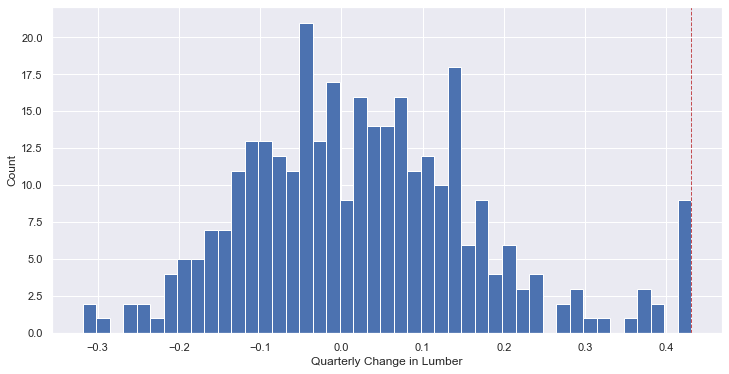

In [4125]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Lumber'], bins=45)
plt.xlabel('Quarterly Change in Lumber')
plt.ylabel('Count')

# plt.xticks(x_ticks)
plt.axvline(u_lum_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4126]:
lum_prev = round(((q_q_roll_bf_T['Lumber'][1])*100),2)
lum_new = round(((QonQ_r_v_win['Lumber'].corr(QonQ_r_v_win['Inflation']))*100),2)
lum_spread = round(lum_new - lum_prev,2)
print('This Winsorization resulted in a',lum_spread,'move in the Pearson Score',win(lum_spread))

This Winsorization resulted in a 0.02 move in the Pearson Score we will use the new Winsorized.


**Capacity Utilization** | Winsorizing

C:\Users\rands\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


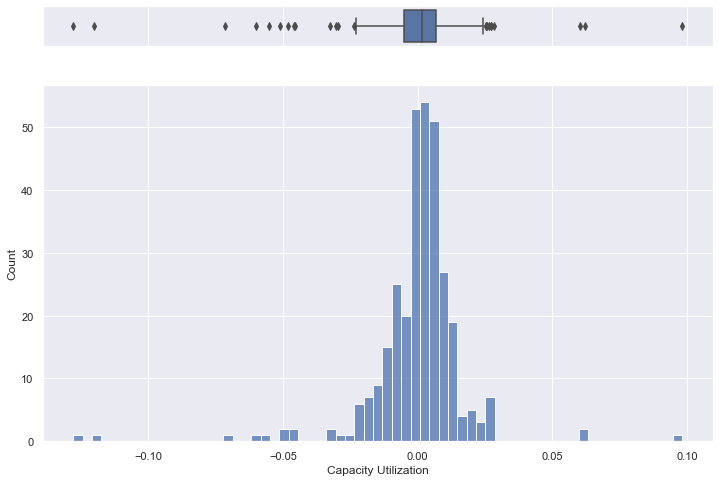

<Figure size 720x432 with 0 Axes>

In [4127]:
a4_dims = (12, 8)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=a4_dims, gridspec_kw={"height_ratios": (.10, .90)})
plt.figure(figsize=(10,6))
 
sns.boxplot(QonQ_r_v_win["Capacity Utilization"], ax=ax_box)
sns.histplot(data=QonQ_r_v_win, x="Capacity Utilization", ax=ax_hist)
 
ax_box.set(xlabel='')
plt.show()


In [4128]:
# the numbers for the percentile
u_caput_rvwin_per = 99
l_caput_rvwin_per = 1

# the actual percentile
u_caput_rvwin_num = (((u_caput_rvwin_per / 100) - 1) * -1)
l_caput_rvwin_num = l_caput_rvwin_per / 100

# what would result in the dataframe be in the percentiles 
u_caput_rvwin_value = np.percentile(QonQ_r_v_win['Capacity Utilization'], u_caput_rvwin_per)
l_caput_rvwin_value = np.percentile(QonQ_r_v_win['Capacity Utilization'], l_caput_rvwin_per)

print('The Upper & Lower Quartiles may be:','\n',
    'Upper |',"{:,}%".format(round((u_caput_rvwin_value),2)),'\n',
     'Lower |',"{:,}%".format(round((l_caput_rvwin_value),2)))

The Upper & Lower Quartiles may be: 
 Upper | 0.03% 
 Lower | -0.06%


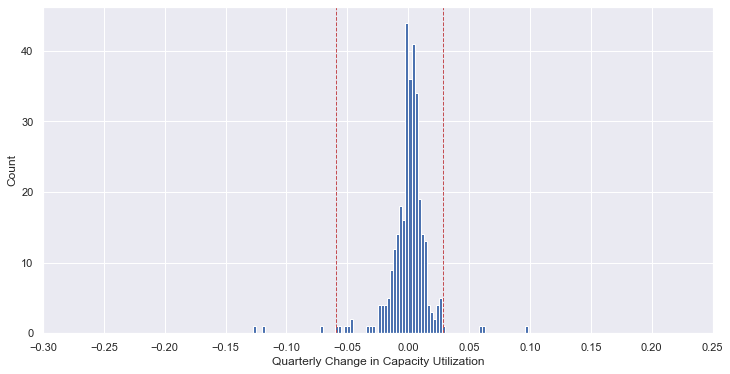

In [4129]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Capacity Utilization'], bins=90)
plt.xlabel('Quarterly Change in Capacity Utilization')
plt.ylabel('Count')

plt.xticks(x_ticks)
plt.axvline(u_caput_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_caput_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4130]:
caput_r_v_win_a = np.count_nonzero(QonQ_r_v_win['Capacity Utilization']>=u_caput_rvwin_value)
caput_r_v_win_b = np.count_nonzero(QonQ_r_v_win['Capacity Utilization']<=l_caput_rvwin_value)

print('With a dataframe with',len(QonQ_r_v_win),'observations, the Winsorization breakdown would be','\n',
     caput_r_v_win_a,'|', "{:,}%".format(round(((caput_r_v_win_a/len(QonQ_r_v_win))*100),1)),'|','Above','\n',
     caput_r_v_win_b,'|', "{:,}%".format(round(((caput_r_v_win_b/len(QonQ_r_v_win))*100),1)),'|','Below','\n',
     (caput_r_v_win_a + caput_r_v_win_b),'|',
      "{:,}%".format(round((((caput_r_v_win_a + caput_r_v_win_b)/len(QonQ_r_v_win))*100),1)),'|','in Total')

With a dataframe with 321 observations, the Winsorization breakdown would be 
 4 | 1.2% | Above 
 4 | 1.2% | Below 
 8 | 2.5% | in Total


Winsorize

In [4131]:
# Winsorize
QonQ_r_v_win["Capacity Utilization"] = winsorize(QonQ_r_v_win["Capacity Utilization"], limits=[l_caput_rvwin_num, u_caput_rvwin_num])

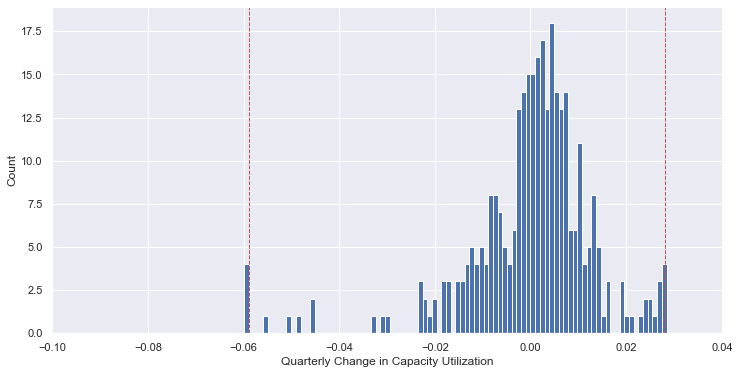

In [4132]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Capacity Utilization'], bins=90)
plt.xlabel('Quarterly Change in Capacity Utilization')
plt.ylabel('Count')

x_ticks = np.arange(-0.1, 0.05, 0.02)
plt.xticks(x_ticks)
plt.axvline(u_caput_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_caput_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4133]:
capu_prev = round(((q_q_roll_bf_T['Capacity Utilization'][1])*100),2)
capu_new = round(((QonQ_r_v_win['Capacity Utilization'].corr(QonQ_r_v_win['Inflation']))*100),2)
capu_spread = round(capu_new - capu_prev,2)
print('This Winsorization resulted in a',capu_spread,'move in the Pearson Score',win(capu_spread))

This Winsorization resulted in a 1.8 move in the Pearson Score we will use the new Winsorized.


**Corn** | Winsorizing

C:\Users\rands\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


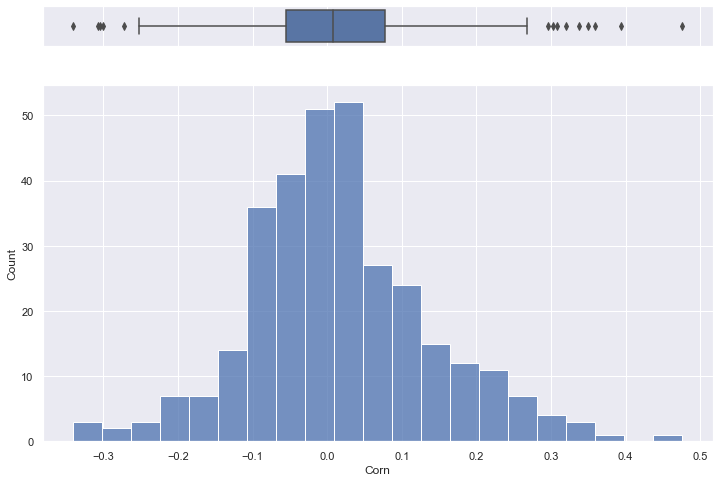

<Figure size 720x432 with 0 Axes>

In [4134]:
sns.set(style="darkgrid")
df = sns.load_dataset("iris")

a4_dims = (12, 8)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=a4_dims, gridspec_kw={"height_ratios": (.10, .90)})
plt.figure(figsize=(10,6))
 
sns.boxplot(QonQ_r_v_win["Corn"], ax=ax_box)
sns.histplot(data=QonQ_r_v_win, x="Corn", ax=ax_hist)
 
ax_box.set(xlabel='')
plt.show()


In [4135]:
# the numbers for the percentile
u_corn_rvwin_per = 99
l_corn_rvwin_per = 1

# the actual percentile
u_corn_rvwin_num = (((u_corn_rvwin_per / 100) - 1) * -1)
l_corn_rvwin_num = l_corn_rvwin_per / 100

# what would result in the dataframe be in the percentiles 
u_corn_rvwin_value = np.percentile(QonQ_r_v_win['Corn'], u_corn_rvwin_per)
l_corn_rvwin_value = np.percentile(QonQ_r_v_win['Corn'], l_corn_rvwin_per)

print('The Upper & Lower Quartiles may be:','\n',
    'Upper |',"{:,}%".format(round((u_corn_rvwin_value),2)),'\n',
     'Lower |',"{:,}%".format(round((l_corn_rvwin_value),2)))

The Upper & Lower Quartiles may be: 
 Upper | 0.35% 
 Lower | -0.29%


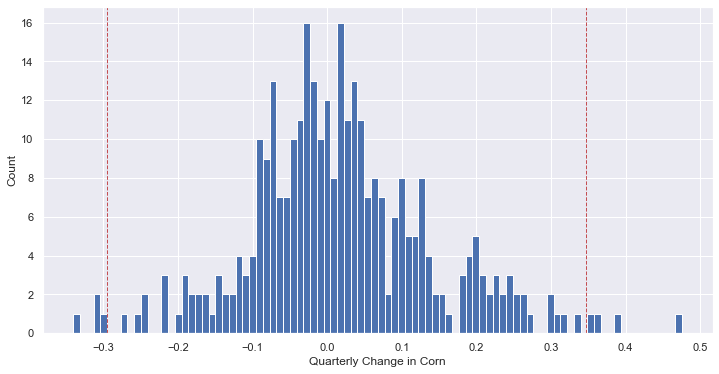

In [4136]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Corn'], bins=90)
plt.xlabel('Quarterly Change in Corn')
plt.ylabel('Count')

plt.axvline(u_corn_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_corn_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4137]:
corn_r_v_win_a = np.count_nonzero(QonQ_r_v_win['Corn']>=u_corn_rvwin_value)
corn_r_v_win_b = np.count_nonzero(QonQ_r_v_win['Corn']<=l_corn_rvwin_value)

print('With a dataframe with',len(QonQ_r_v_win),'observations, the Winsorization breakdown would be','\n',
     corn_r_v_win_a,'|', "{:,}%".format(round(((corn_r_v_win_a/len(QonQ_r_v_win))*100),1)),'|','Above','\n',
     corn_r_v_win_b,'|', "{:,}%".format(round(((corn_r_v_win_b/len(QonQ_r_v_win))*100),1)),'|','Below','\n',
     (corn_r_v_win_a + corn_r_v_win_b),'|',
      "{:,}%".format(round((((corn_r_v_win_a + corn_r_v_win_b)/len(QonQ_r_v_win))*100),1)),'|','in Total')

With a dataframe with 321 observations, the Winsorization breakdown would be 
 4 | 1.2% | Above 
 4 | 1.2% | Below 
 8 | 2.5% | in Total


Winsorize

In [4138]:
# Winsorize
QonQ_r_v_win["Corn"] = winsorize(QonQ_r_v_win["Corn"], limits=[l_corn_rvwin_num, u_corn_rvwin_num])

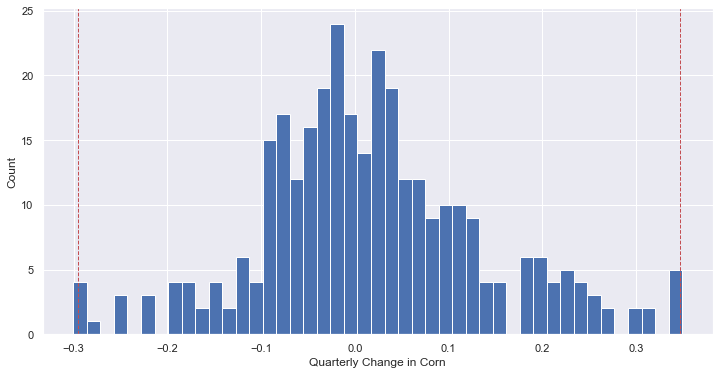

In [4139]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Corn'], bins=45)
plt.xlabel('Quarterly Change in Corn')
plt.ylabel('Count')

plt.axvline(u_corn_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_corn_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4140]:
corn_prev = round(((q_q_roll_bf_T['Corn'][1])*100),2)
corn_new = round(((QonQ_r_v_win['Corn'].corr(QonQ_r_v_win['Inflation']))*100),2)
corn_spread = round(corn_new - corn_prev,2)
print('This Winsorization resulted in a',corn_spread,'move in the Pearson Score',win(corn_spread))

This Winsorization resulted in a -0.38 move in the Pearson Score we will keep the old un-Winsorized.


In [4141]:
QonQ_r_v_win['Corn'] = QonQ_main_roll_side['Corn']

**M2 Velocity** | Winsorizing

C:\Users\rands\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


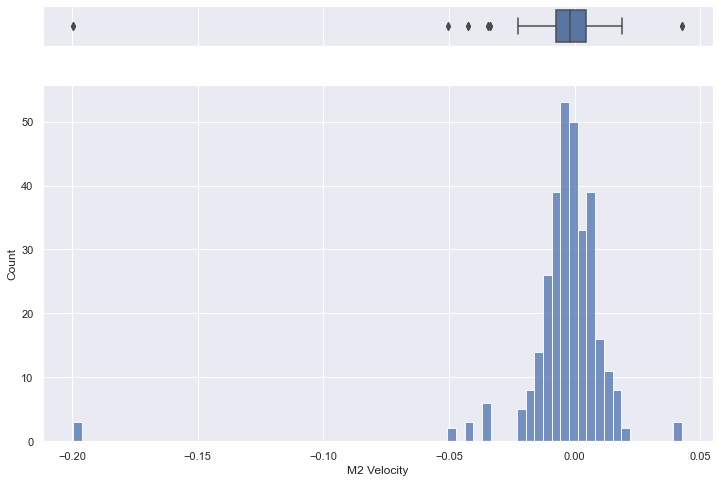

<Figure size 720x432 with 0 Axes>

In [4142]:
sns.set(style="darkgrid")
df = sns.load_dataset("iris")

a4_dims = (12, 8)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=a4_dims, gridspec_kw={"height_ratios": (.10, .90)})
plt.figure(figsize=(10,6))
 
sns.boxplot(QonQ_r_v_win["M2 Velocity"], ax=ax_box)
sns.histplot(data=QonQ_r_v_win, x="M2 Velocity", ax=ax_hist)
 
ax_box.set(xlabel='')
plt.show()


In [4143]:
# the numbers for the percentile
u_m2_rvwin_per = 99.25
l_m2_rvwin_per = 1.5

# the actual percentile
u_m2_rvwin_num = (((u_m2_rvwin_per / 100) - 1) * -1)
l_m2_rvwin_num = l_m2_rvwin_per / 100

# what would result in the dataframe be in the percentiles 
u_m2_rvwin_value = np.percentile(QonQ_r_v_win['M2 Velocity'], u_m2_rvwin_per)
l_m2_rvwin_value = np.percentile(QonQ_r_v_win['M2 Velocity'], l_m2_rvwin_per)

print('The Upper & Lower Quartiles may be:','\n',
    'Upper |',"{:,}%".format(round((u_m2_rvwin_value),2)),'\n',
     'Lower |',"{:,}%".format(round((l_m2_rvwin_value),2)))

The Upper & Lower Quartiles may be: 
 Upper | 0.03% 
 Lower | -0.04%


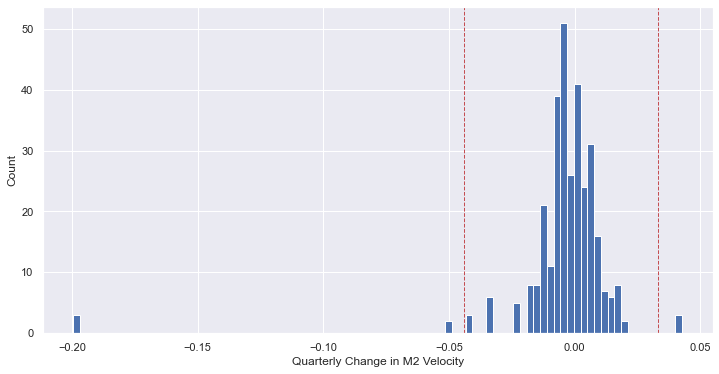

In [4144]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['M2 Velocity'], bins=90)
plt.xlabel('Quarterly Change in M2 Velocity')
plt.ylabel('Count')

plt.axvline(u_m2_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_m2_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4145]:
m2_r_v_win_a = np.count_nonzero(QonQ_r_v_win['M2 Velocity']>=u_m2_rvwin_value)
m2_r_v_win_b = np.count_nonzero(QonQ_r_v_win['M2 Velocity']<=l_m2_rvwin_value)

print('With a dataframe with',len(QonQ_r_v_win),'observations, the Winsorization breakdown would be','\n',
     m2_r_v_win_a,'|', "{:,}%".format(round(((m2_r_v_win_a/len(QonQ_r_v_win))*100),1)),'|','Above','\n',
     m2_r_v_win_b,'|', "{:,}%".format(round(((m2_r_v_win_b/len(QonQ_r_v_win))*100),1)),'|','Below','\n',
     (m2_r_v_win_a + m2_r_v_win_b),'|',
      "{:,}%".format(round((((m2_r_v_win_a + m2_r_v_win_b)/len(QonQ_r_v_win))*100),1)),'|','in Total')

With a dataframe with 321 observations, the Winsorization breakdown would be 
 3 | 0.9% | Above 
 5 | 1.6% | Below 
 8 | 2.5% | in Total


Winsorize

In [4146]:
# Winsorize
QonQ_r_v_win["M2 Velocity"] = winsorize(QonQ_r_v_win["M2 Velocity"], limits=[l_m2_rvwin_num, u_m2_rvwin_num])

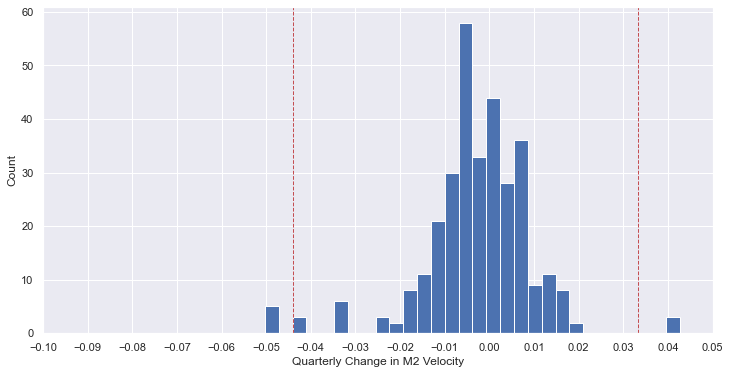

In [4147]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['M2 Velocity'], bins=30)
plt.xlabel('Quarterly Change in M2 Velocity')
plt.ylabel('Count')

x_ticks = np.arange(-0.1, 0.05, 0.01)
plt.xticks(x_ticks)
plt.axvline(u_m2_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_m2_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4148]:
m2_prev = round(((q_q_roll_bf_T['M2 Velocity'][1])*100),2)
m2_new = round(((QonQ_r_v_win['M2 Velocity'].corr(QonQ_r_v_win['Inflation']))*100),2)
m2_spread = round(m2_new - m2_prev,2)
print('This Winsorization resulted in a',m2_spread,'move in the Pearson Score',win(m2_spread))


This Winsorization resulted in a -0.64 move in the Pearson Score we will keep the old un-Winsorized.


In [4149]:
QonQ_r_v_win['M2 Velocity'] = QonQ_main_roll_side['M2 Velocity']

**GDP** | Winsorizing

C:\Users\rands\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


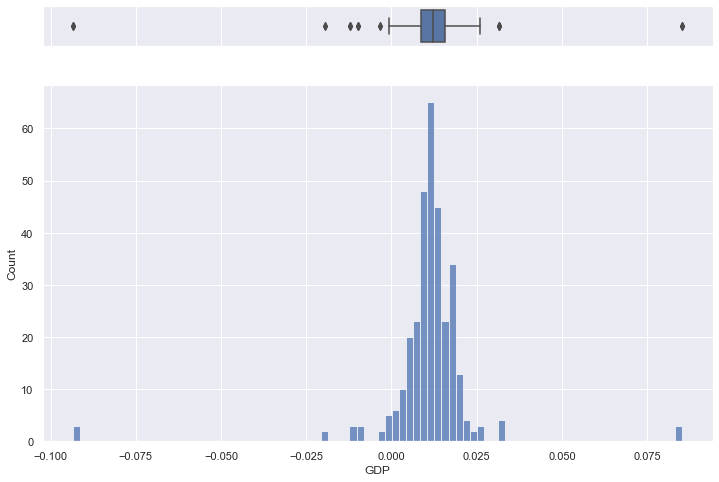

<Figure size 720x432 with 0 Axes>

In [4150]:
a4_dims = (12, 8)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=a4_dims, gridspec_kw={"height_ratios": (.10, .90)})
plt.figure(figsize=(10,6))
 
sns.boxplot(QonQ_r_v_win["GDP"], ax=ax_box)
sns.histplot(data=QonQ_r_v_win, x="GDP", ax=ax_hist)
 
ax_box.set(xlabel='')
plt.show()


In [4151]:
# the numbers for the percentile
u_gdp_rvwin_per = 99
l_gdp_rvwin_per = 1

# the actual percentile
u_gdp_rvwin_num = (((u_gdp_rvwin_per / 100) - 1) * -1)
l_gdp_rvwin_num = l_gdp_rvwin_per / 100

# what would result in the dataframe be in the percentiles 
u_gdp_rvwin_value = np.percentile(QonQ_r_v_win['GDP'], u_gdp_rvwin_per)
l_gdp_rvwin_value = np.percentile(QonQ_r_v_win['GDP'], l_gdp_rvwin_per)

print('The Upper & Lower Quartiles may be:','\n',
    'Upper |',"{:,}%".format(round((u_gdp_rvwin_value),2)),'\n',
     'Lower |',"{:,}%".format(round((l_gdp_rvwin_value),2)))

The Upper & Lower Quartiles may be: 
 Upper | 0.03% 
 Lower | -0.02%


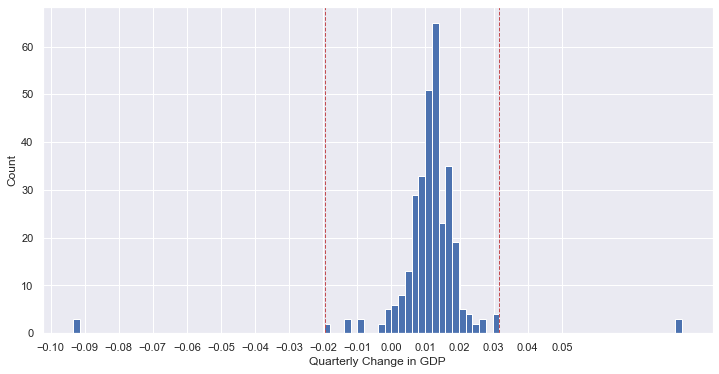

In [4152]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['GDP'], bins=90)
plt.xlabel('Quarterly Change in GDP')
plt.ylabel('Count')

plt.xticks(x_ticks)
plt.axvline(u_gdp_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_gdp_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4153]:
gdp_r_v_win_a = np.count_nonzero(QonQ_r_v_win['GDP']>=u_gdp_rvwin_value)
gdp_r_v_win_b = np.count_nonzero(QonQ_r_v_win['GDP']<=l_gdp_rvwin_value)

print('With a dataframe with',len(QonQ_r_v_win),'observations, the Winsorization breakdown would be','\n',
     gdp_r_v_win_a,'|', "{:,}%".format(round(((gdp_r_v_win_a/len(QonQ_r_v_win))*100),1)),'|','Above','\n',
     gdp_r_v_win_b,'|', "{:,}%".format(round(((gdp_r_v_win_b/len(QonQ_r_v_win))*100),1)),'|','Below','\n',
     (gdp_r_v_win_a + gdp_r_v_win_b),'|',
      "{:,}%".format(round((((gdp_r_v_win_a + gdp_r_v_win_b)/len(QonQ_r_v_win))*100),1)),'|','in Total')

With a dataframe with 321 observations, the Winsorization breakdown would be 
 7 | 2.2% | Above 
 5 | 1.6% | Below 
 12 | 3.7% | in Total


Although a notable amount, those are certainly outliers. Winsorize.

In [4154]:
# Winsorize
QonQ_r_v_win["GDP"] = winsorize(QonQ_r_v_win["GDP"], limits=[l_gdp_rvwin_num, u_gdp_rvwin_num])

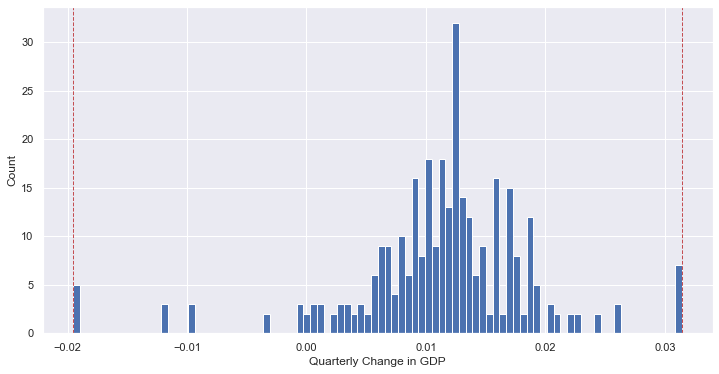

In [4155]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['GDP'], bins=90)
plt.xlabel('Quarterly Change in GDP')
plt.ylabel('Count')

plt.axvline(u_gdp_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_gdp_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4156]:
gdp_prev = round(((q_q_roll_bf_T['GDP'][1])*100),2)
gdp_new = round(((QonQ_r_v_win['GDP'].corr(QonQ_r_v_win['Inflation']))*100),2)
gdp_spread = round(gdp_new - gdp_prev,2)
print('This Winsorization resulted in a',gdp_spread,'move in the Pearson Score',win(gdp_spread))

This Winsorization resulted in a 4.4 move in the Pearson Score we will use the new Winsorized.


**Wheat** | Winsorizing

C:\Users\rands\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


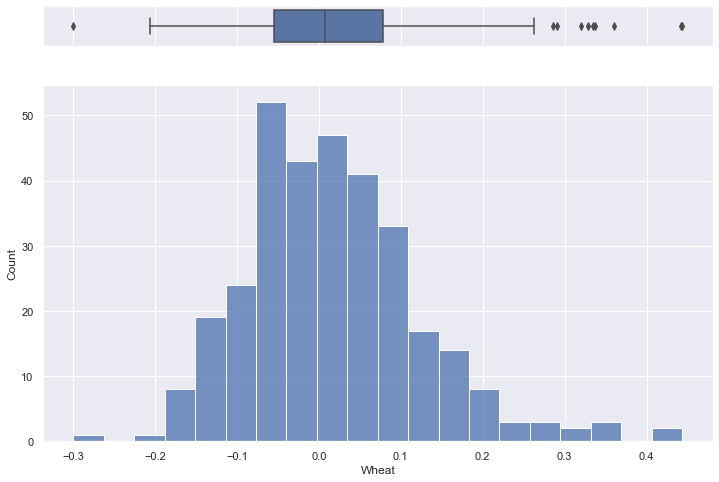

<Figure size 720x432 with 0 Axes>

In [4157]:
sns.set(style="darkgrid")
df = sns.load_dataset("iris")

a4_dims = (12, 8)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=a4_dims, gridspec_kw={"height_ratios": (.10, .90)})
plt.figure(figsize=(10,6))
 
sns.boxplot(QonQ_r_v_win["Wheat"], ax=ax_box)
sns.histplot(data=QonQ_r_v_win, x="Wheat", ax=ax_hist)
 
ax_box.set(xlabel='')
plt.show()


In [4158]:
# the numbers for the percentile
u_wht_rvwin_per = 99
l_wht_rvwin_per = 1

# the actual percentile
u_wht_rvwin_num = (((u_wht_rvwin_per / 100) - 1) * -1)
l_wht_rvwin_num = l_wht_rvwin_per / 100

# what would result in the dataframe be in the percentiles 
u_wht_rvwin_value = np.percentile(QonQ_r_v_win['Wheat'], u_wht_rvwin_per)
l_wht_rvwin_value = np.percentile(QonQ_r_v_win['Wheat'], l_wht_rvwin_per)

print('The Upper & Lower Quartiles may be:','\n',
    'Upper |',"{:,}%".format(round((u_wht_rvwin_value),2)),'\n',
     'Lower |',"{:,}%".format(round((l_wht_rvwin_value),2)))

The Upper & Lower Quartiles may be: 
 Upper | 0.34% 
 Lower | -0.19%


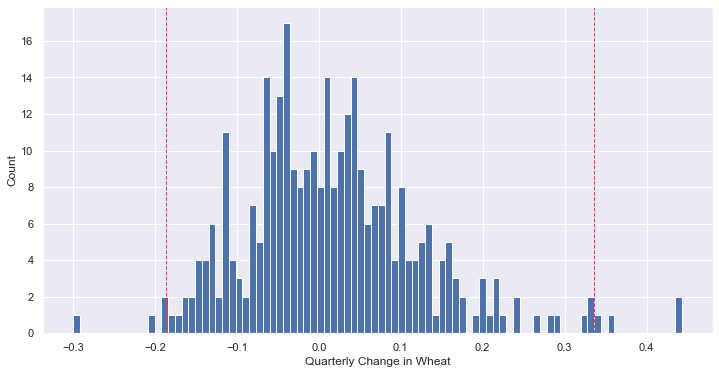

In [4159]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Wheat'], bins=90)
plt.xlabel('Quarterly Change in Wheat')
plt.ylabel('Count')

plt.axvline(u_wht_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_wht_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4160]:
wht_r_v_win_a = np.count_nonzero(QonQ_r_v_win['Wheat']>=u_wht_rvwin_value)
wht_r_v_win_b = np.count_nonzero(QonQ_r_v_win['Wheat']<=l_wht_rvwin_value)

print('With a dataframe with',len(QonQ_r_v_win),'observations, the Winsorization breakdown would be','\n',
     wht_r_v_win_a,'|', "{:,}%".format(round(((wht_r_v_win_a/len(QonQ_r_v_win))*100),1)),'|','Above','\n',
     wht_r_v_win_b,'|', "{:,}%".format(round(((wht_r_v_win_b/len(QonQ_r_v_win))*100),1)),'|','Below','\n',
     (wht_r_v_win_a + wht_r_v_win_b),'|',
      "{:,}%".format(round((((wht_r_v_win_a + wht_r_v_win_b)/len(QonQ_r_v_win))*100),1)),'|','in Total')

With a dataframe with 321 observations, the Winsorization breakdown would be 
 4 | 1.2% | Above 
 4 | 1.2% | Below 
 8 | 2.5% | in Total


Winsorize

In [4161]:
# Winsorize
QonQ_r_v_win["Wheat"] = winsorize(QonQ_r_v_win["Wheat"], limits=[l_wht_rvwin_num, u_wht_rvwin_num])

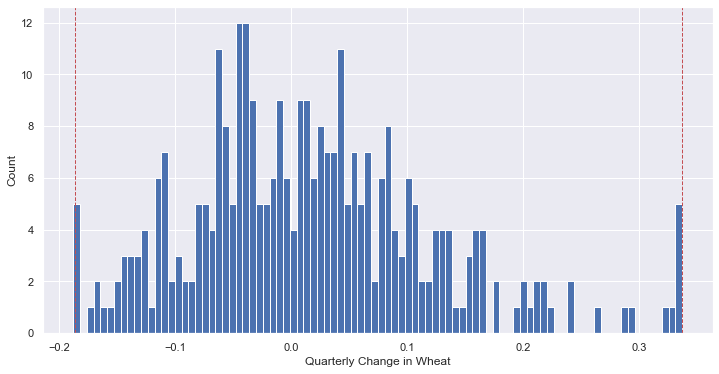

In [4162]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Wheat'], bins=90)
plt.xlabel('Quarterly Change in Wheat')
plt.ylabel('Count')

plt.axvline(u_wht_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_wht_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4163]:
wht_prev = round(((q_q_roll_bf_T['Wheat'][1])*100),2)
wht_new = round(((QonQ_r_v_win['Wheat'].corr(QonQ_r_v_win['Inflation']))*100),2)
wht_spread = round(wht_new - wht_prev,2)
print('This Winsorization resulted in a',wht_spread,'move in the Pearson Score',win(wht_spread))

This Winsorization resulted in a -2.29 move in the Pearson Score we will keep the old un-Winsorized.


In [4164]:
QonQ_r_v_win['Wheat'] = QonQ_main_roll_side['Wheat']

**PMI** | Winsorizing

C:\Users\rands\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


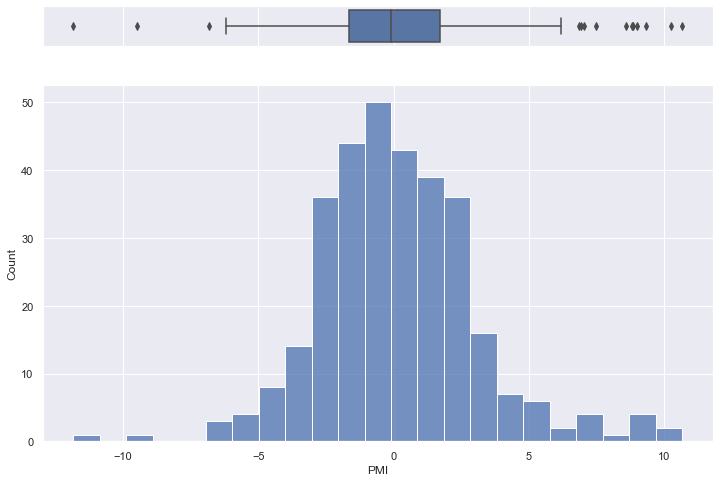

<Figure size 720x432 with 0 Axes>

In [4165]:
sns.set(style="darkgrid")
df = sns.load_dataset("iris")

a4_dims = (12, 8)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=a4_dims, gridspec_kw={"height_ratios": (.10, .90)})
plt.figure(figsize=(10,6))
 
sns.boxplot(QonQ_r_v_win["PMI"], ax=ax_box)
sns.histplot(data=QonQ_r_v_win, x="PMI", ax=ax_hist)
 
ax_box.set(xlabel='')
plt.show()


In [4166]:
# the numbers for the percentile
u_pmi_rvwin_per = 99
l_pmi_rvwin_per = 1

# the actual percentile
u_pmi_rvwin_num = (((u_pmi_rvwin_per / 100) - 1) * -1)
l_pmi_rvwin_num = l_pmi_rvwin_per / 100

# what would result in the dataframe be in the percentiles 
u_pmi_rvwin_value = np.percentile(QonQ_r_v_win['PMI'], u_pmi_rvwin_per)
l_pmi_rvwin_value = np.percentile(QonQ_r_v_win['PMI'], l_pmi_rvwin_per)

print('The Upper & Lower Quartiles may be:','\n',
    'Upper |',round((u_pmi_rvwin_value),2),'\n',
     'Lower |',round((l_pmi_rvwin_value),2))

The Upper & Lower Quartiles may be: 
 Upper | 8.97 
 Lower | -6.18


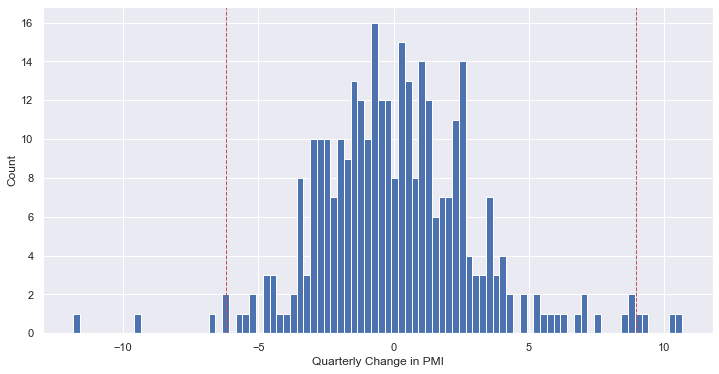

In [4167]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['PMI'], bins=90)
plt.xlabel('Quarterly Change in PMI')
plt.ylabel('Count')

plt.axvline(u_pmi_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_pmi_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4168]:
pmi_r_v_win_a = np.count_nonzero(QonQ_r_v_win['PMI']>=u_pmi_rvwin_value)
pmi_r_v_win_b = np.count_nonzero(QonQ_r_v_win['PMI']<=l_pmi_rvwin_value)

print('With a dataframe with',len(QonQ_r_v_win),'observations, the Winsorization breakdown would be','\n',
     pmi_r_v_win_a,'|', "{:,}%".format(round(((pmi_r_v_win_a/len(QonQ_r_v_win))*100),1)),'|','Above','\n',
     pmi_r_v_win_b,'|', "{:,}%".format(round(((pmi_r_v_win_b/len(QonQ_r_v_win))*100),1)),'|','Below','\n',
     (pmi_r_v_win_a + pmi_r_v_win_b),'|',
      "{:,}%".format(round((((pmi_r_v_win_a + pmi_r_v_win_b)/len(QonQ_r_v_win))*100),1)),'|','in Total')

With a dataframe with 321 observations, the Winsorization breakdown would be 
 4 | 1.2% | Above 
 4 | 1.2% | Below 
 8 | 2.5% | in Total


Winsorize

In [4169]:
# Winsorize
QonQ_r_v_win["PMI"] = winsorize(QonQ_r_v_win["PMI"], limits=[l_pmi_rvwin_num, u_pmi_rvwin_num])

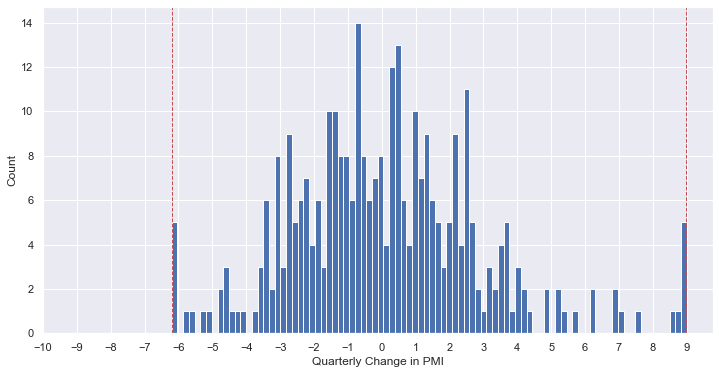

In [4170]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['PMI'], bins=90)
plt.xlabel('Quarterly Change in PMI')
plt.ylabel('Count')

x_ticks = np.arange(-10, 10, 1)
plt.xticks(x_ticks)
plt.axvline(u_pmi_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_pmi_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4171]:
pmi_prev = round(((q_q_roll_bf_T['PMI'][1])*100),2)
pmi_new = round(((QonQ_r_v_win['PMI'].corr(QonQ_r_v_win['Inflation']))*100),2)
pmi_spread = round(pmi_new - pmi_prev,2)
print('This Winsorization resulted in a',pmi_spread,'move in the Pearson Score',win(pmi_spread))

This Winsorization resulted in a -3.98 move in the Pearson Score we will keep the old un-Winsorized.


In [4172]:
QonQ_r_v_win['PMI'] = QonQ_main_roll_side['PMI']

**USD Index** | Winsorizing

C:\Users\rands\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


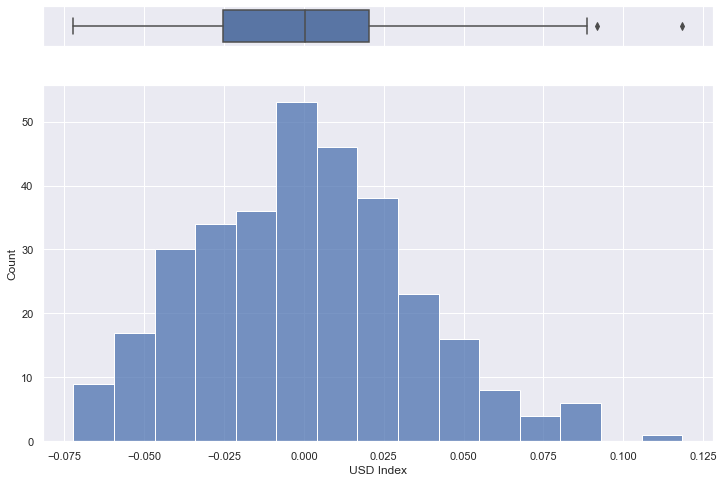

<Figure size 720x432 with 0 Axes>

In [4173]:
sns.set(style="darkgrid")
df = sns.load_dataset("iris")

a4_dims = (12, 8)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=a4_dims, gridspec_kw={"height_ratios": (.10, .90)})
plt.figure(figsize=(10,6))
 
sns.boxplot(QonQ_r_v_win["USD Index"], ax=ax_box)
sns.histplot(data=QonQ_r_v_win, x="USD Index", ax=ax_hist)
 
ax_box.set(xlabel='')
plt.show()
    

In [4174]:
# the numbers for the percentile
u_usd_rvwin_per = 99.75
l_usd_rvwin_per = 1

# the actual percentile
u_usd_rvwin_num = (((u_usd_rvwin_per / 100) - 1) * -1)
l_usd_rvwin_num = l_usd_rvwin_per / 100

# what would result in the dataframe be in the percentiles 
u_usd_rvwin_value = np.percentile(QonQ_r_v_win['USD Index'], u_usd_rvwin_per)
l_usd_rvwin_value = np.percentile(QonQ_r_v_win['USD Index'], l_usd_rvwin_per)

print('The Upper & Lower Quartiles may be:','\n',
    'Upper |',"{:,}%".format(round((u_usd_rvwin_value),2)),'\n',
     'Lower |',"{:,}%".format(round((l_usd_rvwin_value),2)))

The Upper & Lower Quartiles may be: 
 Upper | 0.1% 
 Lower | -0.07%


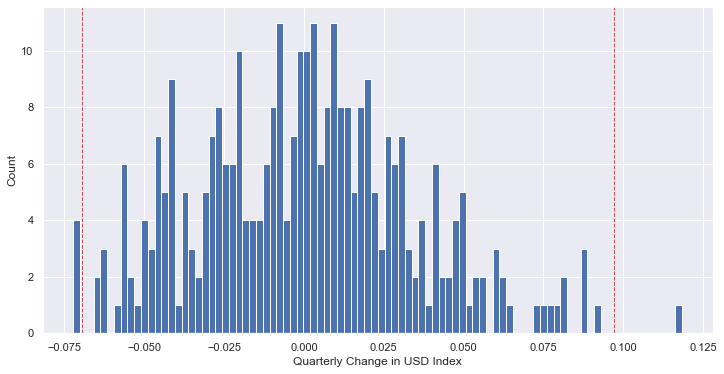

In [4175]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['USD Index'], bins=90)
plt.xlabel('Quarterly Change in USD Index')
plt.ylabel('Count')

plt.axvline(u_usd_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_usd_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4176]:
usd_r_v_win_a = np.count_nonzero(QonQ_r_v_win['USD Index']>=u_usd_rvwin_value)
usd_r_v_win_b = np.count_nonzero(QonQ_r_v_win['USD Index']<=l_usd_rvwin_value)

print('With a dataframe with',len(QonQ_r_v_win),'observations, the Winsorization breakdown would be','\n',
     usd_r_v_win_a,'|', "{:,}%".format(round(((usd_r_v_win_a/len(QonQ_r_v_win))*100),1)),'|','Above','\n',
     usd_r_v_win_b,'|', "{:,}%".format(round(((usd_r_v_win_b/len(QonQ_r_v_win))*100),1)),'|','Below','\n',
     (usd_r_v_win_a + usd_r_v_win_b),'|',
      "{:,}%".format(round((((usd_r_v_win_a + usd_r_v_win_b)/len(QonQ_r_v_win))*100),1)),'|','in Total')

With a dataframe with 321 observations, the Winsorization breakdown would be 
 1 | 0.3% | Above 
 4 | 1.2% | Below 
 5 | 1.6% | in Total


Let's look adjust the outlier at the top in a manual way to 0.10.

In [4177]:
# Winsorize
# QonQ_r_v_win["USD Index"] = winsorize(QonQ_r_v_win["USD Index"], limits=[l_usd_rvwin_num, u_usd_rvwin_num])
QonQ_r_v_win.loc[QonQ_r_v_win['USD Index'] > 0.1, 'USD Index'] = 0.1

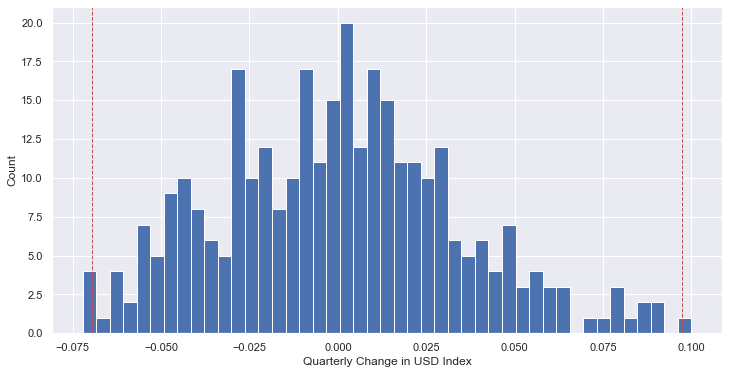

In [4178]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['USD Index'], bins=45)
plt.xlabel('Quarterly Change in USD Index')
plt.ylabel('Count')

plt.axvline(u_usd_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_usd_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4179]:
usd_prev = round(((q_q_roll_bf_T['USD Index'][1])*100),2)
usd_new = round(((QonQ_r_v_win['USD Index'].corr(QonQ_r_v_win['Inflation']))*100),2) * -1
usd_spread = round(usd_new - usd_prev,2)
print('This Winsorization resulted in a',usd_spread,'move in the Pearson Score',win(usd_spread))


This Winsorization resulted in a -0.78 move in the Pearson Score we will keep the old un-Winsorized.


In [4180]:
QonQ_r_v_win['USD Index'] = QonQ_main_roll_side['USD Index']

**Unemployment Rate** | Winsorizing

C:\Users\rands\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


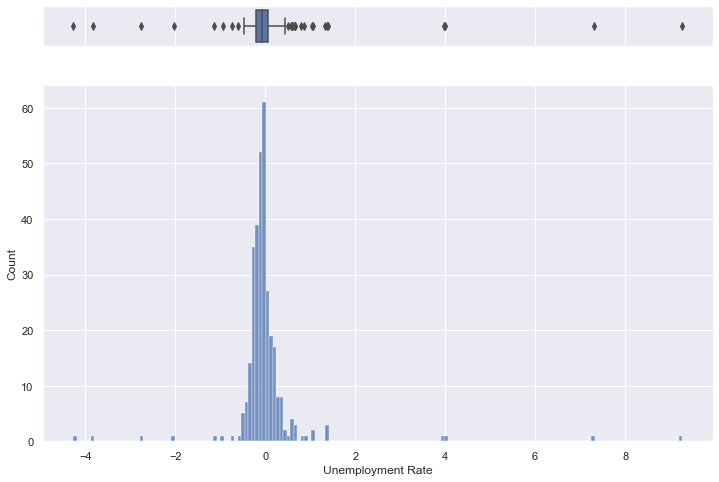

<Figure size 720x432 with 0 Axes>

In [4181]:
sns.set(style="darkgrid")
df = sns.load_dataset("iris")

a4_dims = (12, 8)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=a4_dims, gridspec_kw={"height_ratios": (.10, .90)})
plt.figure(figsize=(10,6))
 
sns.boxplot(QonQ_r_v_win["Unemployment Rate"], ax=ax_box)
sns.histplot(data=QonQ_r_v_win, x="Unemployment Rate", ax=ax_hist)
 
ax_box.set(xlabel='')
plt.show()


In [4182]:
# the numbers for the percentile
u_unem_rvwin_per = 98.823
l_unem_rvwin_per = 0.95

# the actual percentile
u_unem_rvwin_num = (((u_unem_rvwin_per / 100) - 1) * -1)
l_unem_rvwin_num = l_unem_rvwin_per / 100

# what would result in the dataframe be in the percentiles 
u_unem_rvwin_value = np.percentile(QonQ_r_v_win['Unemployment Rate'], u_unem_rvwin_per)
l_unem_rvwin_value = np.percentile(QonQ_r_v_win['Unemployment Rate'], l_unem_rvwin_per)

print('The Upper & Lower Quartiles may be:','\n',
    'Upper |',round((u_unem_rvwin_value),2),'\n',
     'Lower |',round((l_unem_rvwin_value),2))

The Upper & Lower Quartiles may be: 
 Upper | 2.0 
 Lower | -2.0


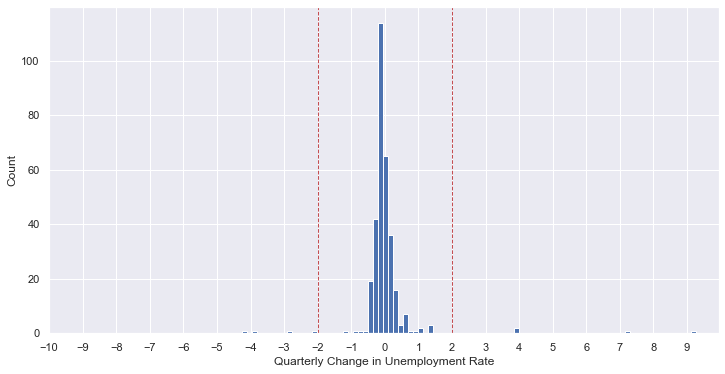

In [4183]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Unemployment Rate'], bins=90)
plt.xlabel('Quarterly Change in Unemployment Rate')
plt.ylabel('Count')

plt.xticks(x_ticks)
plt.axvline(u_unem_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_unem_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4184]:
unem_r_v_win_a = np.count_nonzero(QonQ_r_v_win['Unemployment Rate']>=u_unem_rvwin_value)
unem_r_v_win_b = np.count_nonzero(QonQ_r_v_win['Unemployment Rate']<=l_unem_rvwin_value)

print('With a dataframe with',len(QonQ_r_v_win),'observations, the Winsorization breakdown would be','\n',
     unem_r_v_win_a,'|', "{:,}%".format(round(((unem_r_v_win_a/len(QonQ_r_v_win))*100),1)),'|','Above','\n',
     unem_r_v_win_b,'|', "{:,}%".format(round(((unem_r_v_win_b/len(QonQ_r_v_win))*100),1)),'|','Below','\n',
     (unem_r_v_win_a + unem_r_v_win_b),'|',
      "{:,}%".format(round((((unem_r_v_win_a + unem_r_v_win_b)/len(QonQ_r_v_win))*100),1)),'|','in Total')

With a dataframe with 321 observations, the Winsorization breakdown would be 
 4 | 1.2% | Above 
 4 | 1.2% | Below 
 8 | 2.5% | in Total


Winsorize

In [4185]:
# Winsorize
QonQ_r_v_win["Unemployment Rate"] = winsorize(QonQ_r_v_win["Unemployment Rate"], limits=[l_unem_rvwin_num, u_unem_rvwin_num])

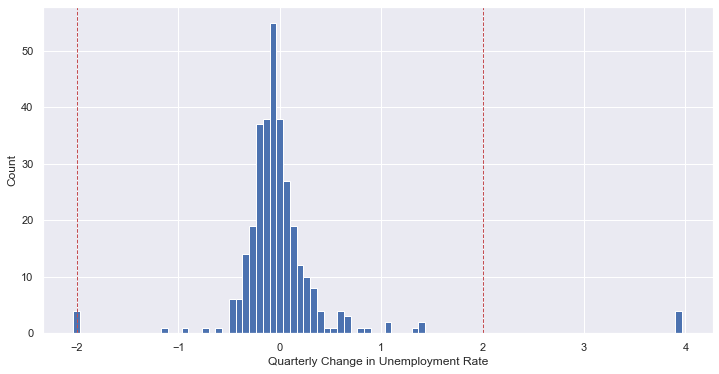

In [4186]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Unemployment Rate'], bins=90)
plt.xlabel('Quarterly Change in Unemployment Rate')
plt.ylabel('Count')

plt.axvline(u_unem_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_unem_rvwin_value, color='r', linestyle='dashed', linewidth=1)

That may not have worked on the positive side; reverting to the manual approach.

In [4187]:
QonQ_r_v_win.loc[QonQ_r_v_win['Unemployment Rate'] > 1, 'Unemployment Rate'] = 1
QonQ_r_v_win.loc[QonQ_r_v_win['Unemployment Rate'] < -1, 'Unemployment Rate'] = -1

Text(0, 0.5, 'Count')

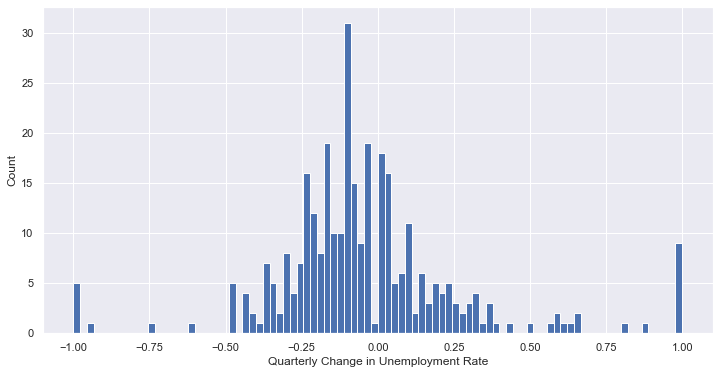

In [4188]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Unemployment Rate'], bins=90)
plt.xlabel('Quarterly Change in Unemployment Rate')
plt.ylabel('Count')

# plt.axvline(u_unem_rvwin_value, color='r', linestyle='dashed', linewidth=1)
# plt.axvline(l_unem_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4189]:
unem_prev = round(((q_q_roll_bf_T['Unemployment Rate'][1])*100),2)
unem_new = round(((QonQ_r_v_win['Unemployment Rate'].corr(QonQ_r_v_win['Inflation']))*100),2) * -1
unem_spread = round(unem_new - unem_prev,2)
print('This Winsorization resulted in a',unem_spread,'move in the Pearson Score',win(unem_spread))

This Winsorization resulted in a 4.6 move in the Pearson Score we will use the new Winsorized.


**Initial Jobless Claims** | Winsorizing

C:\Users\rands\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


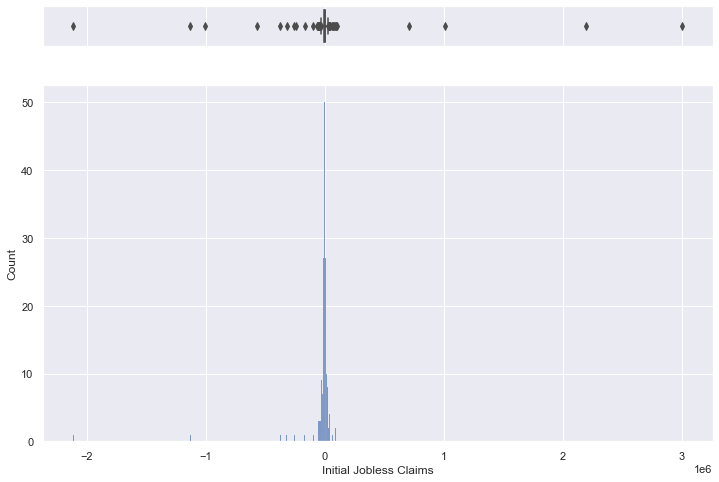

<Figure size 720x432 with 0 Axes>

In [4190]:
sns.set(style="darkgrid")
df = sns.load_dataset("iris")

a4_dims = (12, 8)
f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=a4_dims, gridspec_kw={"height_ratios": (.10, .90)})
plt.figure(figsize=(10,6))
 
sns.boxplot(QonQ_r_v_win["Initial Jobless Claims"], ax=ax_box)
sns.histplot(data=QonQ_r_v_win, x="Initial Jobless Claims", ax=ax_hist)
 
ax_box.set(xlabel='')
plt.show()


In [4191]:
# the numbers for the percentile
u_ijc_rvwin_per = 98
l_ijc_rvwin_per = 2

# the actual percentile
u_ijc_rvwin_num = (((u_ijc_rvwin_per / 100) - 1) * -1)
l_ijc_rvwin_num = l_ijc_rvwin_per / 100

# what would result in the dataframe be in the percentiles 
u_ijc_rvwin_value = np.percentile(QonQ_r_v_win['Initial Jobless Claims'], u_ijc_rvwin_per)
l_ijc_rvwin_value = np.percentile(QonQ_r_v_win['Initial Jobless Claims'], l_ijc_rvwin_per)

print('The Upper & Lower Quartiles may be:','\n',
    'Upper |',round((u_ijc_rvwin_value),2),'\n',
     'Lower |',round((l_ijc_rvwin_value),2))

The Upper & Lower Quartiles may be: 
 Upper | 88000.0 
 Lower | -251100.0


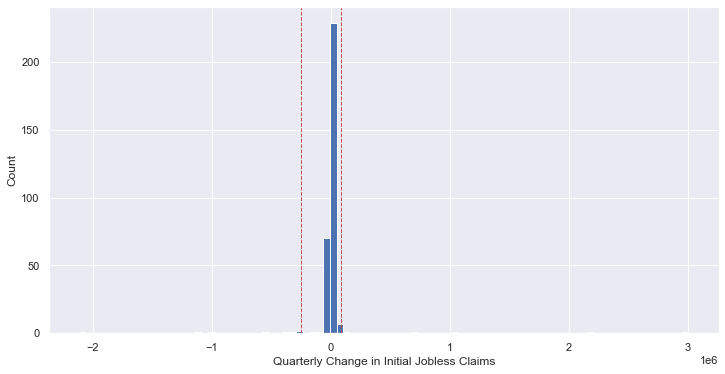

In [4192]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Initial Jobless Claims'], bins=90)
plt.xlabel('Quarterly Change in Initial Jobless Claims')
plt.ylabel('Count')

plt.axvline(u_ijc_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_ijc_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4193]:
ijc_r_v_win_a = np.count_nonzero(QonQ_r_v_win['Initial Jobless Claims']>=u_ijc_rvwin_value)
ijc_r_v_win_b = np.count_nonzero(QonQ_r_v_win['Initial Jobless Claims']<=l_ijc_rvwin_value)

print('With a dataframe with',len(QonQ_r_v_win),'observations, the Winsorization breakdown would be','\n',
     ijc_r_v_win_a,'|', "{:,}%".format(round(((ijc_r_v_win_a/len(QonQ_r_v_win))*100),1)),'|','Above','\n',
     ijc_r_v_win_b,'|', "{:,}%".format(round(((ijc_r_v_win_b/len(QonQ_r_v_win))*100),1)),'|','Below','\n',
     (ijc_r_v_win_a + ijc_r_v_win_b),'|',
      "{:,}%".format(round((((ijc_r_v_win_a + ijc_r_v_win_b)/len(QonQ_r_v_win))*100),1)),'|','in Total')

With a dataframe with 321 observations, the Winsorization breakdown would be 
 7 | 2.2% | Above 
 7 | 2.2% | Below 
 14 | 4.4% | in Total


Winsorize

In [4194]:
# Winsorize
QonQ_r_v_win["Initial Jobless Claims"] = winsorize(QonQ_r_v_win["Initial Jobless Claims"], limits=[l_ijc_rvwin_num, u_ijc_rvwin_num])

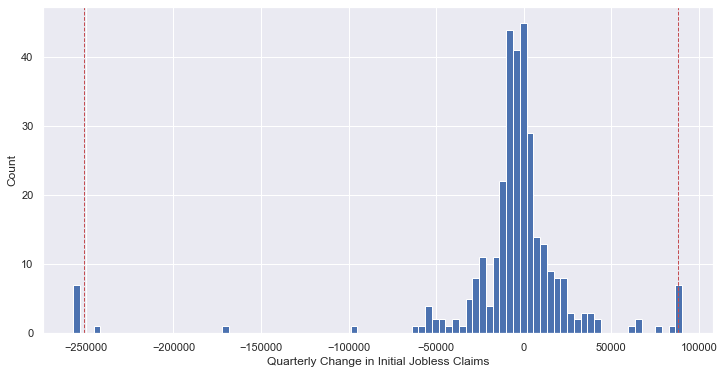

In [4195]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Initial Jobless Claims'], bins=90)
plt.xlabel('Quarterly Change in Initial Jobless Claims')
plt.ylabel('Count')

# x_ticks = np.arange(-0.04, 0.03, 0.01)
# plt.xticks(x_ticks)
plt.axvline(u_ijc_rvwin_value, color='r', linestyle='dashed', linewidth=1)
plt.axvline(l_ijc_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4196]:
lower = -50000
upper = 50000

QonQ_r_v_win.loc[QonQ_r_v_win['Initial Jobless Claims'] > 50000,'Initial Jobless Claims']= upper
QonQ_r_v_win.loc[QonQ_r_v_win['Initial Jobless Claims'] < -50000,'Initial Jobless Claims']= lower

Text(0, 0.5, 'Count')

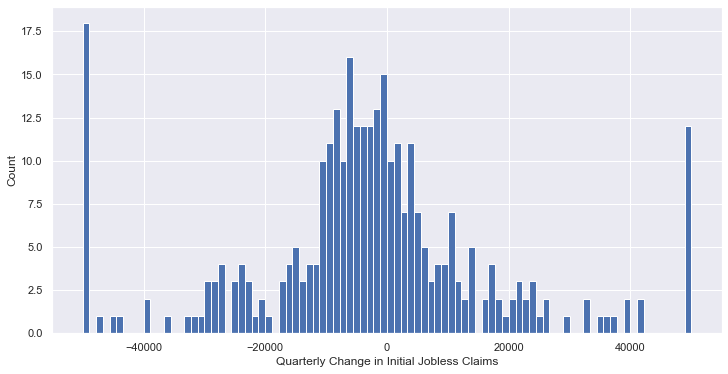

In [4197]:
# taking a look at where these land
plt.figure(figsize=(12,6))
plt.hist(QonQ_r_v_win['Initial Jobless Claims'], bins=90)
plt.xlabel('Quarterly Change in Initial Jobless Claims')
plt.ylabel('Count')

# x_ticks = np.arange(-0.04, 0.03, 0.01)
# plt.xticks(x_ticks)
# plt.axvline(u_ijc_rvwin_value, color='r', linestyle='dashed', linewidth=1)
# plt.axvline(l_ijc_rvwin_value, color='r', linestyle='dashed', linewidth=1)

In [4198]:
ijcl_prev = round(((q_q_roll_bf_T['Initial Jobless Claims'][1])*100),2)
ijcl_new = round(((QonQ_r_v_win['Initial Jobless Claims'].corr(QonQ_r_v_win['Inflation']))*100),2)*-1
ijcl_spread = round(wti_new + wti_prev,2)
print('This Winsorization resulted in a',ijcl_spread,'move in the Pearson Score',win(ijcl_spread))

This Winsorization resulted in a 108.13 move in the Pearson Score we will use the new Winsorized.


**Taking a Look**

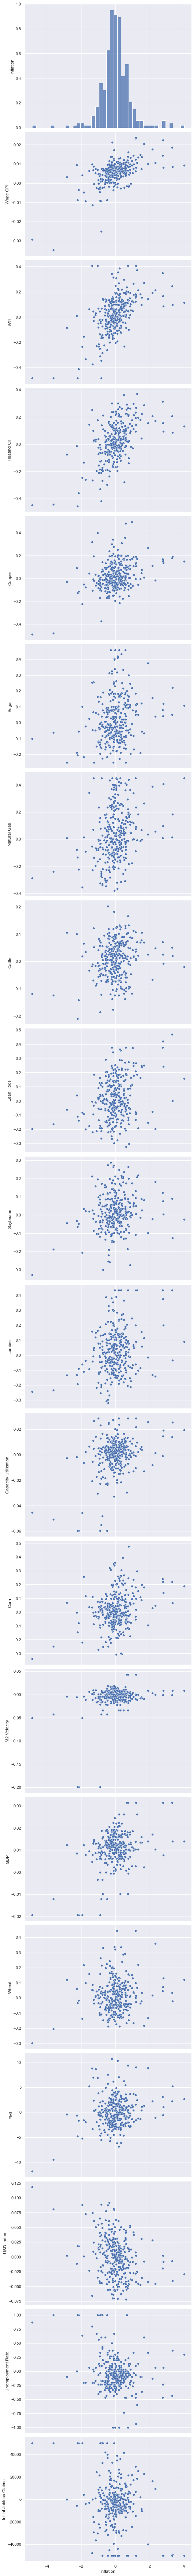

In [4199]:
sns.pairplot(QonQ_r_v_win,
            y_vars = ['Inflation','Wage CPI','WTI','Heating Oil','Copper','Sugar',
                     'Natural Gas','Cattle','Lean Hogs','Soybeans','Lumber',
                     'Capacity Utilization','Corn','M2 Velocity','GDP','Wheat','PMI',
                     'USD Index','Unemployment Rate','Initial Jobless Claims'],
            x_vars = ['Inflation'],
             height=5, aspect=1.5,
            )

**Adding in Pearson**

In [4200]:
QonQ_r_v_win.corr(method='pearson')

Inflation  Wage CPI       WTI  Heating Oil    Copper  \
Inflation                1.000000  0.595358  0.541041     0.542445  0.372813   
Wage CPI                 0.595358  1.000000  0.715988     0.725743  0.517990   
WTI                      0.541041  0.715988  1.000000     0.914654  0.571744   
Heating Oil              0.542445  0.725743  0.914654     1.000000  0.550684   
Copper                   0.372813  0.517990  0.571744     0.550684  1.000000   
Sugar                    0.220639  0.231294  0.228138     0.270096  0.305841   
Natural Gas              0.292725  0.390025  0.346751     0.463075  0.166945   
Cattle                   0.162077  0.249568  0.172328     0.233310  0.127142   
Lean Hogs                0.291943  0.296192  0.332416     0.201871  0.215793   
Soybeans                 0.199634  0.250109  0.286688     0.257833  0.268939   
Lumber                   0.255685  0.234544  0.313654     0.235195  0.250314   
Capacity Utilization     0.367072  0.405005  0.444188     0.476720  0.363503   
Corn                     0.293481  0.246192  0.164490     0.156077  0.171532   
M2 Velocity              0.281344  0.335991  0.414455     0.390383  0.265222   
GDP                      0.387090  0.415809  0.439515     0.414066  0.328523   
Wheat                    0.125293  0.144276  0.048348     0.068688  0.155670   
PMI                      0.223222  0.320950  0.468606     0.383965  0.463192   
USD Index               -0.307158 -0.383304 -0.407189    -0.402501 -0.413288   
Unemployment Rate       -0.261978 -0.282681 -0.273983    -0.315285 -0.179692   
Initial Jobless Claims  -0.297205 -0.232268 -0.368295    -0.288212 -0.347054   

                           Sugar  Natural Gas    Cattle  Lean Hogs  Soybeans  \
Inflation               0.220639     0.292725  0.162077   0.291943  0.199634   
Wage CPI                0.231294     0.390025  0.249568   0.296192  0.250109   
WTI                     0.228138     0.346751  0.172328   0.332416  0.286688   
Heating Oil             0.270096     0.463075  0.233310   0.201871  0.257833   
Copper                  0.305841     0.166945  0.127142   0.215793  0.268939   
Sugar                   1.000000     0.227228  0.111183  -0.105855  0.156477   
Natural Gas             0.227228     1.000000  0.141510   0.092469  0.108481   
Cattle                  0.111183     0.141510  1.000000   0.135960  0.083687   
Lean Hogs              -0.105855     0.092469  0.135960   1.000000  0.232522   
Soybeans                0.156477     0.108481  0.083687   0.232522  1.000000   
Lumber                  0.039004    -0.087688  0.253958   0.317668  0.237998   
Capacity Utilization    0.162551     0.283798  0.337982   0.190283  0.172929   
Corn                    0.108236     0.116825  0.076798   0.248014  0.727726   
M2 Velocity             0.131981     0.147536  0.265988   0.120134  0.070406   
GDP                     0.044654     0.165158  0.205602   0.247585  0.111355   
Wheat                   0.088454     0.036587  0.059626  -0.085270  0.459035   
PMI                     0.137791     0.042967  0.197677   0.158024  0.177084   
USD Index              -0.161475    -0.242780 -0.080543  -0.010782 -0.275479   
Unemployment Rate      -0.041276    -0.162368 -0.330221  -0.165353 -0.137939   
Initial Jobless Claims -0.169258    -0.096247 -0.243961  -0.159092 -0.124204   

                          Lumber  Capacity Utilization      Corn  M2 Velocity  \
Inflation               0.255685              0.367072  0.293481     0.281344   
Wage CPI                0.234544              0.405005  0.246192     0.335991   
WTI                     0.313654              0.444188  0.164490     0.414455   
Heating Oil             0.235195              0.476720  0.156077     0.390383   
Copper                  0.250314              0.363503  0.171532     0.265222   
Sugar                   0.039004              0.162551  0.108236     0.131981   
Natural Gas            -0.087688              0.283798  0.116825     0.147536   
Cattle        

Text(0.5, 1.0, 'Quarter on Quarter Comparison with Rolling Averages (Winsorized) )')

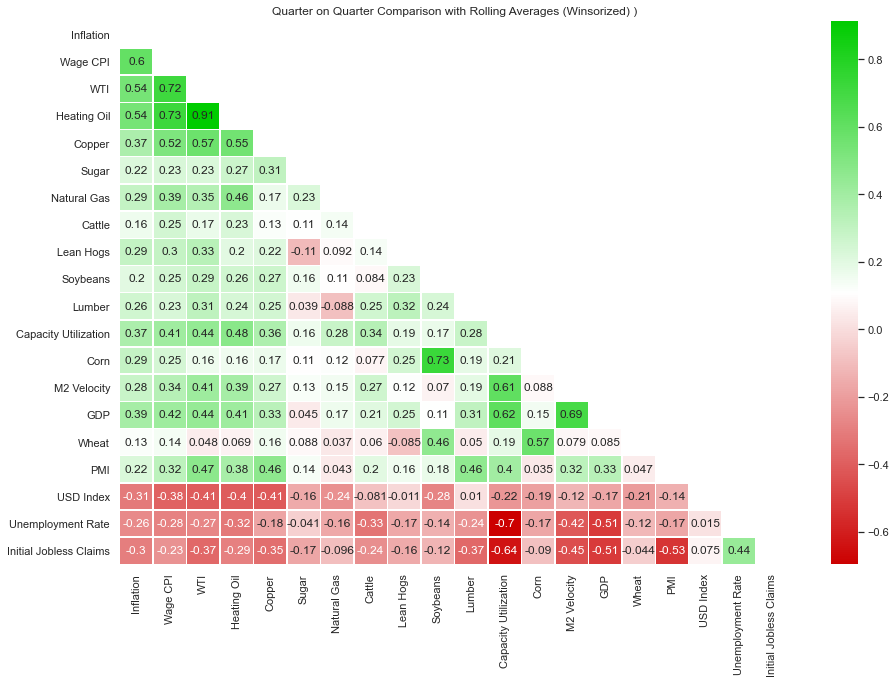

In [4276]:
sns.set(style="whitegrid")
plt.subplots(figsize=(15,10))
matrix = np.triu(QonQ_r_v_win.corr())
sns.heatmap(QonQ_r_v_win.corr(), mask=matrix, linewidths=.5, cmap=GnRd, annot=True)
plt.title('Quarter on Quarter Comparison with Rolling Averages (Winsorized) )')

In [4202]:
# looking at the average pearson coefficient
q_q_r_win = QonQ_r_v_win.corr(method='pearson')
q_q_r_win = pd.DataFrame(q_q_r_win['Inflation'])
q_q_r_win = q_q_r_win.iloc[1: , :]
q_q_r_win['AbsAmount'] = q_q_r_win['Inflation'].abs()
q_q_r_win_av = q_q_r_win['AbsAmount'].mean()

In [4203]:
QonQ_r_v_win = QonQ_r_v_win.sort_values(by="Date", ascending=False)
QonQ_r_v_win_csv = pd.DataFrame(QonQ_r_v_win)

QonQ_r_v_win_csv.to_excel('./_Inflation_Capstone/data/1.0_Segmented_by_periods/QonQ_roll_winsorized.xlsx')
print('Finished')

Finished


**Comparing them all**

In [4204]:
print('The Average Pearson coefficients below:','\n','\n',
     "{:,}%".format(round((q_q_main_av*100),2)),'  | Quarter on Quarter','\n',
     "{:,}%".format(round((m_m_main_av*100),2)),' | Month on Month','\n',
     "{:,}%".format(round((q_q_pf_av*100),2)),' | Quarterly Changes | Variables ( past ) & Inflation ( forwards )','\n',
     "{:,}%".format(round((q_q_roll_av*100),2)),' | Quarter on Quarter with Rolling Averages','\n','\n',
     "{:,}%".format(round((q_q_r_win_av*100),2)),' | Quarter on Quarter with Rolling Averages ( Winsorized )'
     )

The Average Pearson coefficients below: 
 
 22.7%   | Quarter on Quarter 
 18.22%  | Month on Month 
 12.14%  | Quarterly Changes | Variables ( past ) & Inflation ( forwards ) 
 30.64%  | Quarter on Quarter with Rolling Averages 
 
 31.67%  | Quarter on Quarter with Rolling Averages ( Winsorized )


# 2.11 Project Final Summary<a id='p_final_summary'></a>

To end this section, it is **confirmed that the following will move to the next section**:
   * Quarter on Quarter with Rolling Averages ( Winsorized )

It is also confirmed that Winsorization only worked well on certain variables; those will be outlined below for reference before saving. 

In [4224]:
q_q_r_win_b = pd.DataFrame([])
q_q_r_win_b = pd.DataFrame(q_q_r_win.copy())
q_q_r_win_b = q_q_r_win_b.drop(columns=['Inflation'])
q_q_r_win_b.columns = ['Win_p']

In [4225]:
q_q_roll_b = pd.DataFrame([])
q_q_roll_b = pd.DataFrame(q_q_roll_bf.copy())
q_q_roll_b = q_q_roll_b.drop(columns=['Inflation'])
q_q_roll_b.columns = ['NoWinzor_p']

In [4227]:
q_q_comp = pd.DataFrame([])
q_q_comp = pd.concat([q_q_roll_b['NoWinzor_p'],q_q_r_win_b['Win_p']],
                    axis = 1, ignore_index=False)
# q_q_comp.columns = ['Roll_av','Wins_av']
q_q_comp['Win_plus'] = q_q_comp['Win_p'] - q_q_comp['NoWinzor_p']
q_q_comp['Winsorized?'] = np.where(q_q_comp['Win_plus']==0, 'n/a', 'Winsorized')

In [4228]:
q_q_comp.head(20)

NoWinzor_p     Win_p  Win_plus Winsorized?
Wage CPI                  0.595358  0.595358  0.000000         n/a
WTI                       0.540347  0.541041  0.000694  Winsorized
Heating Oil               0.542445  0.542445  0.000000         n/a
Copper                    0.372813  0.372813  0.000000         n/a
Sugar                     0.219235  0.220639  0.001405  Winsorized
Natural Gas               0.289579  0.292725  0.003146  Winsorized
Cattle                    0.162077  0.162077  0.000000         n/a
Lean Hogs                 0.291943  0.291943  0.000000         n/a
Soybeans                  0.199634  0.199634  0.000000         n/a
Lumber                    0.255493  0.255685  0.000191  Winsorized
Capacity Utilization      0.349075  0.367072  0.017997  Winsorized
Corn                      0.293481  0.293481  0.000000         n/a
M2 Velocity               0.281344  0.281344  0.000000         n/a
GDP                       0.343129  0.387090  0.043961  Winsorized
Wheat                     0.125293  0.125293  0.000000         n/a
PMI                       0.223222  0.223222  0.000000         n/a
USD Index                 0.307158  0.307158  0.000000         n/a
Unemployment Rate         0.215974  0.261978  0.046005  Winsorized
Initial Jobless Claims    0.272464  0.297205  0.024741  Winsorized

In [4258]:
v_w_sum = q_q_comp['Winsorized?'].str.count("Winsorized").sum()

qq_mean_df = pd.DataFrame(q_q_comp.groupby('Winsorized?')['Win_plus'].mean()).T
qq_mean = round((qq_mean_df['Winsorized'][0]*10000),2)

qq_max_df = pd.DataFrame(q_q_comp.groupby('Winsorized?')['Win_plus'].max()).T
qq_max = round((qq_max_df['Winsorized'][0]*10000),2)

qq_min_df = pd.DataFrame(q_q_comp.groupby('Winsorized?')['Win_plus'].min()).T
qq_min = round((qq_min_df['Winsorized'][0]*10000),2)

In [4273]:
print('There were',v_w_sum,'variables Winsorized with an increase of the Pearson Coefficients as below:','\n','\n',
     'Average |',qq_mean,'bps','\n','\n',
     'Max | ',qq_max, 'bps','\n',
     'Min | ',qq_min, '  bps')

There were 8 variables Winsorized with an increase of the Pearson Coefficients as below: 
 
 Average | 172.67 bps 
 
 Max |  460.05 bps 
 Min |  1.91   bps


**Saving** for the next section

In [4274]:
# to csv
QonQ_r_v_win = QonQ_r_v_win.sort_values(by="Date", ascending=False)
QonQ_r_v_win_csv = pd.DataFrame(QonQ_r_v_win)

QonQ_r_v_win_csv.to_excel('./_Inflation_Capstone/data/1.0_Segmented_by_periods/QonQ_roll_winsorized.xlsx')
print('Finished')

Finished


In [4277]:
# to pickle
QonQ_r_v_win.to_pickle('./_Inflation_Capstone/data/1.0_Segmented_by_periods/QonQ_roll_winsorized.pkl')
print('Finished')

Finished
